<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Neste/Neste_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "NESTE.HE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02   3.57   3.70   3.57   3.70       1.19  1121418
2009-01-05   3.79   3.91   3.76   3.87       1.25  3431010
2009-01-07   3.97   4.00   3.85   3.85       1.24  3105822
2009-01-08   3.82   3.88   3.77   3.86       1.24  1905417
2009-01-09   3.89   3.91   3.70   3.71       1.19  3559104
...           ...    ...    ...    ...        ...      ...
2018-12-19  23.33  23.77  23.16  23.57      23.30  1049256
2018-12-20  23.21  23.35  22.59  22.59      22.33  1143492
2018-12-21  22.60  22.63  22.03  22.36      22.10  1783161
2018-12-27  22.50  22.77  22.15  22.24      21.98  1183863
2018-12-28  22.43  22.48  22.00  22.45      22.19   793566

[2512 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2512.000000  2512.000000  2512.000000  2512.000000  2512.000000  2.512000e+03
mean      7.702719     7.798694     7.612174     7.706919     5.884490  2.633797e+06
std       5.825237     5.895338     5.771711     5.833837     6.069698  1.610000e+06
min       2.100000     2.140000     2.050000     2.060000     0.940000  0.000000e+00
25%       3.700000     3.740000     3.650000     3.690000     1.680000  1.664950e+06
50%       4.870000     4.910000     4.815000     4.860000     3.000000  2.279858e+06
75%      10.385000    10.507500    10.215000    10.397500     8.485000  3.126622e+06
max      25.410000    25.510000    25.130000    25.370000    24.210000  2.023456e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-16   2.99   3.06   2.97   3.03       0.98  3219276   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   3.034576   3.227127  -3.184400   2.968556   3.045753   3.098179       3.030       3.050   3.233061   3.01750   2.991844   3.0300   3.016389   3.01750   2.986667   3.223437                3.127386                  3.01750                2.907614                3.182329                  3.01750                2.852671                3.237273                  3.01750                2.797727                3.292216                  3.01750                2.742784   3.045753   3.007808   3.190778                3.155640                 3.045753                2.935867                3.210583                 3.045753                2.880924                3.265526                 3.045753                2.825981                3.320469                 3.045753   
2009-03-17   3.04   3.06   2.99   3.00       0.97  2302839   17          1         76             31             0               0               0                 0      3        1    12        1             4          12   3.032847   3.222270  -3.178912   2.967635   3.035586   3.097439       3.030       3.050   3.207216   3.01500   2.992941   3.0255   3.012500   3.01500   3.015000   3.196792                3.125454                  3.01500                2.904546                3.180680                  3.01500                2.849320                3.235907                  3.01500                2.794093                3.291134                  3.01500                2.738866   3.035586   3.002698   3.165255                3.146039                 3.035586                2.925132                3.201266                 3.035586                2.869905                3.256493                 3.035586                2.814679                3.311720                 3.035586   
2009-03-18   3.04   3.06   2.98   3.02       

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2.462000e+03  2462.000000  2462.000000  2462.000000    2462.000000   2462.000000     2462.000000     2462.000000       2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000   
mean      7.787120     7.883960     7.696487     7.791946     5.981007  2.618480e+06    15.774574     1.985378   185.871243      30.457758      0.032088        0.028432        0.008936          0.008123     6.613323     2.539399    27.017872     1.985378      2.016247    27.017872     7.763410     7.699687     0.523001     7.792278     7.763865     7.763115     7.765211     7.764699     7.719717     7.764048     7.792236     7.764167     7.773446     7.764048     7.786049     7.706998                8.054653                 7.764048                7.473442                8.199955                 7.764048                7.328140                8.345258                 7.764048                7.182837                8.490561                 7.764048                7.037534     7.763865     7.785980     7.715506                8.054470                 7.763865                7.473260                8.199773                 7.763865                7.327957                8.345076   
std       5.853492     5.924039     5.799200     5.861754     6.092731  1.610642e+06     8.730045     1.407225   103.153614       0.789793      0.176269        0.166238        0.094125          0.089782     3.382550     1.105503    14.751927     1.407225      1.410668    14.751927     5.841424     5.766242     9.634688     5.864086     5.831588     5.832273     5.833763     5.833845     5.788142     5.833831     5.862984     5.834909     5.842733     5.833831     5.856817     5.773615                6.024514                 5.833831                5.653318                6.123374                 5.833831                5.567186                6.224431                 5.833831                5.483977                6.327580                 5.833831                5.403828     5.831588     5.855486     5.782777                6.022944                 5.831588                5.650361                6.122125                 5.831588                5.563857                6.223494   
min       2.100000     2.140000     2.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-16  0.038181  0.039367  0.039861  0.041613   0.000430  3219276   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.034550  0.040771  0.443449  0.036905  0.038215  0.036663    0.038352    0.039168  0.050429  0.037057  0.038336  0.037825  0.037648  0.037057  0.038284  0.043282                0.037114                 0.037057                0.039829                0.036474                 0.037057                0.046202                0.034650                 0.037057                0.055940                0.032975                 0.037057                0.067541  0.038215  0.038295  0.042181                0.037417                 0.038215                0.039865                0.035840                 0.038215                0.048256                0.033966                 0.038215                0.059768                0.032367                 0.038215   
2009-03-17  0.040326  0.039367  0.040728  0.040326   0.000000  2302839   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  0.034473  0.040550  0.443558  0.036866  0.037768  0.036630    0.038352    0.039168  0.049327  0.036948  0.038383  0.037628  0.037478  0.036948  0.039508  0.042095                0.037032                 0.036948                0.039693                0.036407                 0.036948                0.046052                0.034599                 0.036948                0.055778                0.032937                 0.036948                0.067368  0.037768  0.038073  0.041047                0.037007                 0.037768                0.039387                0.035470                 0.037768                0.047766                0.033636                 0.037768                0.059267                0.032071                 0.037768   
2009-03-18  0.040326  0.039367  0.040295  0.041184  

139966

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp68k_bda7
  JVM stdout: /tmp/tmp68k_bda7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp68k_bda7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_rnebqg
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.449027                   0.5  0.731036  0.534413
1  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.438926                   0.5  0.731036  0.534413
2  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000   0.718894                   0.5  0.512562  0.262720
3              DeepLearning_1_AutoML_20190826_131703  0.50000  18.457970                   0.5  0.731036  0.534413
4  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.457970                   0.5  0.731036  0.534413
5  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.457970                   0.5  0.731036  0.534413
6  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.457970                   0.5  0.731036  0.534413
7  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.457970                   0.5  0.731036  0.534413
8  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.50000  18.457970                   0.5  0.731036  0.534413
9  DeepLearning_grid_1_AutoML_20190826_131703_mod...  0.45751  14.026929                   0.5  0.724535  0.524951

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.003072
1               STOCHRSI_fastk             0.623004           0.623004    0.001914
2                 STOCHF_fastk             0.595286           0.595286    0.001829
3                  CDLLONGLINE             0.521214           0.521214    0.001601
4                          DIV             0.504541           0.504541    0.001550
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_30_6_3             0.281686           0.281686    0.000865
1036   BBANDS_upperband_14_6_2             0.280936           0.280936    0.000863
1037   BBANDS_upperband_30_5_4             0.280626           0.280626    0.000862
1038   BBANDS_middleband_8_7_3             0.276648           0.276648    0.000850
1039            CDL3LINESTRIKE             0.274109           0.274109    0.000842

[1040 rows x 4 columns]

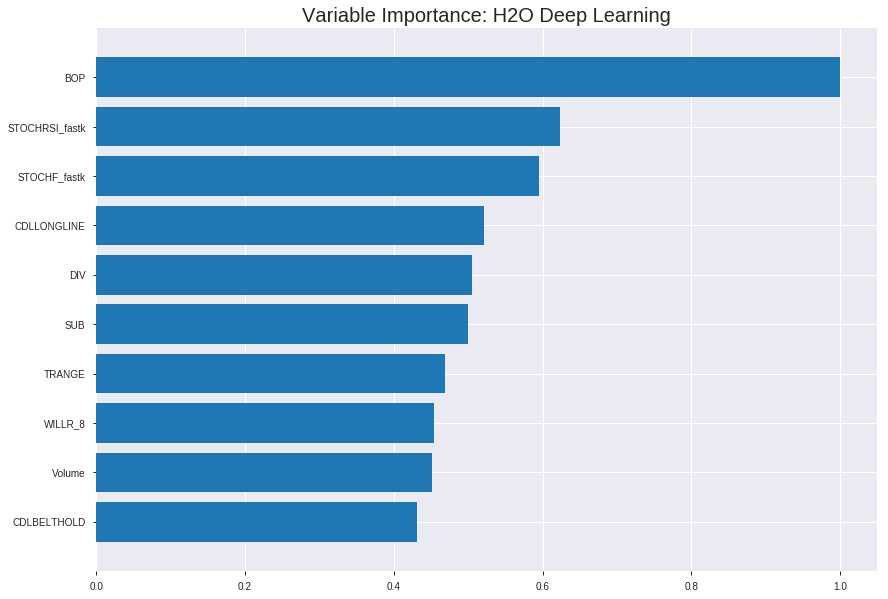

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_131703_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23206583005271428
RMSE: 0.48173211440873887
LogLoss: 0.6565868229287027
Mean Per-Class Error: 0.36765336765336765
AUC: 0.6803184136517471
pr_auc: 0.7123981512571905
Gini: 0.3606368273034941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3957830629350229: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      148  629   0.8095   (629.0/777.0)
1      31   914   0.0328   (31.0/945.0)
Total  179  1543  0.3833   (660.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395783     0.734727  323
max f2                       0.349381     0.861942  366
max f0point5                 0.494398     0.66804   201
max accuracy                 0.494398     0.639373  201
max precision                0.745853     1         0
max recall                   0.288578     1         393
max specificity              0.745853     1         0
max absolute_mcc             0.494398     0.265602  201
max min_per_class_accuracy   0.510267     0.626455  177
max mean_per_class_accuracy  0.507852     0.632347  181

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 49.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.639885           1.72099   1.72099            0.944444         0.672344  0.944444                    0.672344            0.0179894       0.0179894                  72.0988   72.0988
    2        0.0203252                   0.612685           1.71503   1.7181             0.941176         0.626141  0.942857                    0.649902            0.0169312       0.0349206                  71.5033   71.8095
    3        0.0301974                   0.603181           1.60784   1.68205            0.882353         0.606969  0.923077                    0.635867            0.015873        0.0507937                  60.7843   68.2051
    4        0.0400697                   0.593284           1.28627   1.58454            0.705882         0.597951  0.869565                    0.626525            0.0126984       0.0634921                  28.6275   58.4541
    5        0.0505226                   0.588823           1.51852   1.57088            0.833333         0.590862  0.862069                    0.619147            0.015873        0.0793651                  51.8519   57.0881
    6        0.100465                    0.573887           1.44083   1.50623            0.790698         0.579602  0.82659                     0.599489            0.0719577       0.151323                   44.0827   50.623
    7        0.150407                    0.565718           1.27132   1.42823            0.697674         0.569775  0.783784                    0.589622            0.0634921       0.214815                   27.1318   42.8228
    8        0.200348                    0.56016            1.25013   1.38383            0.686047         0.562944  0.75942                     0.582972            0.0624339       0.277249                   25.0129   38.3833
    9        0.300232                    0.547601           1.1124    1.29353            0.610465         0.554601  0.709865                    0.573533            0.111111        0.38836                    11.2403   29.3531
    10       0.400116                    0.530497           1.18656   1.26683            0.651163         0.539205  0.69521                     0.564964            0.118519        0.506878                   18.6563   26.6828
    11       0.5                         0.512932           1.09121   1.23175            0.598837         0.52149   0.675958                    0.556279            0.108995        0.615873                   9.12145   23.1746
    12       0.599884                    0.494477           1.01705   1.196              0.55814          0.504046  0.656341                    0.547582            0.101587        0.71746                    1.70543   19.5999
    13       0.699768                    0.472099           0.794574  1.1387             0.436047         0.484417  0.624896                    0.538566            0.0793651       0.796825                   -20.5426  13.87
    14       0.799652                    0.436302           0.868734  1.10498            0.476744         0.455275  0.606391                    0.528162            0.0867725       0.883598                   -13.1266  10.4979
    15       0.899535                    0.393871           0.847545  1.07639            0.465116         0.415835  0.590704                    0.515689            0.0846561       0.968254                   -15.2455  7.63934
    16       1                           0.247629           0.315992  1                  0.17341          0.356203  0.54878                     0.499667            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27809040997263945
RMSE: 0.5273427822324294
LogLoss: 1.3633414143691445
Mean Per-Class Error: 0.4574866310160428
AUC: 0.5336564171122995
pr_auc: 0.5453006812492649
Gini: 0.067312834224599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5823601490672226: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    216  0.9818   (216.0/220.0)
1      1    271  0.0037   (1.0/272.0)
Total  5    487  0.4411   (217.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.58236      0.714097   394
max f2                       0.571113     0.861305   398
max f0point5                 0.604584     0.613905   351
max accuracy                 0.605908     0.567073   346
max precision                0.711906     0.614815   94
max recall                   0.571113     1          398
max specificity              1            0.940909   0
max absolute_mcc             0.683213     0.0845568  188
max min_per_class_accuracy   0.683213     0.540909   188
max mean_per_class_accuracy  0.683213     0.542513   188

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 70.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   1                  1.20588   1.20588            0.666667         1         0.666667                    1                   0.0147059       0.0147059                  20.5882   20.5882
    2        0.0203252                   1                  0.904412  1.08529            0.5              1         0.6                         1                   0.00735294      0.0220588                  -9.55882  8.52941
    3        0.0304878                   1                  0.361765  0.844118           0.2              1         0.466667                    1                   0.00367647      0.0257353                  -63.8235  -15.5882
    4        0.0406504                   1                  1.44706   0.994853           0.8              1         0.55                        1                   0.0147059       0.0404412                  44.7059   -0.514706
    5        0.050813                    0.999999           0.723529  0.940588           0.4              0.999999  0.52                        1                   0.00735294      0.0477941                  -27.6471  -5.94118
    6        0.101626                    0.794522           1.08529   1.01294            0.6              0.967111  0.56                        0.983555            0.0551471       0.102941                   8.52941   1.29412
    7        0.150407                    0.737724           1.20588   1.07552            0.666667         0.751356  0.594595                    0.908247            0.0588235       0.161765                   20.5882   7.55167
    8        0.20122                     0.723623           1.01294   1.05971            0.56             0.729075  0.585859                    0.863002            0.0514706       0.213235                   1.29412   5.97148
    9        0.300813                    0.708438           1.14436   1.08774            0.632653         0.714843  0.601351                    0.813949            0.113971        0.327206                   14.4358   8.77385
    10       0.400407                    0.695381           0.84904   1.02837            0.469388         0.701716  0.568528                    0.786033            0.0845588       0.411765                   -15.096   2.83667
    11       0.5                         0.683754           1.21819   1.06618            0.673469         0.690081  0.589431                    0.766921            0.121324        0.533088                   21.8187   6.61765
    12       0.599593                    0.671446           0.885954  1.03624            0.489796         0.678534  0.572881                    0.75224             0.0882353       0.621324                   -11.4046  3.62413
    13       0.699187                    0.654533           0.885954  1.01483            0.489796         0.663509  0.561047                    0.739601            0.0882353       0.709559                   -11.4046  1.48341
    14       0.79878                     0.618739           0.922869  1.00337            0.510204         0.632307  0.554707                    0.726223            0.0919118       0.801471                   -7.71309  0.336776
    15       0.898374                    0.602778           1.18127   1.02309            0.653061         0.611029  0.565611                    0.713453            0.117647        0.919118                   18.1273   2.30902
    16       1                           0.565919           0.795882  1                  0.44             0.593953  0.552846                    0.701308    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:39:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:39:10  6 min 21.445 sec  252 obs/sec       0.325784  1             561        0.637475         2.086               -0.641118      0.532378        0.524834           1.31605          0.445993                         0.711237           3.45544               -1.04629         0.49695           0.531543             0.851211           0.447154
    2019-08-26 13:39:43  6 min 54.747 sec  381 obs/sec       7.17886   23            12362      0.481732         0.656587            0.0628164      0.680318        0.712398           1.72099          0.383275                         0.527343           1.36334               -0.124928        0.533656          0.545301             1.20588            0.441057
    2019-08-26 13:40:15  7 min 27.002 sec  402 obs/sec       14.3705   46            24746      0.450254         0.591642            0.181294       0.765104        0.787587           1.82222          0.313589                         0.544677           1.8685                -0.200097        0.578835          0.549382             0.994853           0.404472
    2019-08-26 13:40:47  7 min 58.260 sec  414 obs/sec       21.5813   69            37163      0.443864         0.577176            0.204366       0.781746        0.802677           1.82222          0.297329                         0.514363           2.08118               -0.0702334       0.598262          0.556848             0.990546           0.384146
    2019-08-26 13:41:18  8 min 30.435 sec  420 obs/sec       28.8345   92            49653      0.434732         0.557854            0.236769       0.792794        0.807112           1.82222          0.266551                         0.56               2.43546               -0.268572        0.581534          0.537227             0.983056           0.384146
    2019-08-26 13:41:56  9 min  7.920 sec  427 obs/sec       37.9193   121           65297      0.431524         0.551848            0.24799        0.801207        0.820348           1.82222          0.279326                         0.598762           3.07652               -0.450265        0.566402          0.518108             0.996699           0.406504
    2019-08-26 13:42:27  9 min 38.977 sec  433 obs/sec       45.4437   145           78254      0.427576         0.543192            0.261687       0.80478         0.820156           1.82222          0.255517                         0.58852            3.40337               -0.401074        0.567747          0.496326             0.99308            0.394309
    2019-08-26 13:42:30  9 min 42.135 sec  433 obs/sec       45.4437   145           78254      0.481732         0.656587            0.0628164      0.680318        0.712398           1.72099          0.383275                         0.527343           1.36334               -0.124928        0.533656          0.545301             1.20588            0.441057

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.003072377684647187
STOCHRSI_fastk            0.6230036020278931     0.6230036020278931   0.0019141023643253153
STOCHF_fastk              0.5952855944633484     0.5952855944633484   0.0018289421764211265
CDLLONGLINE               0.5212138295173645     0.5212138295173645   0.0016013657387386538
DIV                       0.5045414566993713     0.5045414566993713   0.0015501419125425334
---                       ---                    ---                  ---
BBANDS_middleband_30_6_3  0.28168562054634094    0.28168562054634094  0.000865444614652573
BBANDS_upperband_14_6_2   0.2809358537197113     0.2809358537197113   0.0008631410477857474
BBANDS_upperband_30_5_4   0.28062573075294495    0.28062573075294495  0.0008621882329031578
BBANDS_middleband_8_7_3   0.2766475975513458     0.2766475975513458   0.0008499659052280105
CDL3LINESTRIKE            0.27410873770713806    0.27410873770713806  0.0008421655688982198


See the whole table with table.as_data_frame()


('accuracy', 0.46558704453441296)

('F1', 0.6353591160220994)

('auc', 0.5)

('logloss', 18.44902748605556)

('mean_per_class_error', 0.5)

('rmse', 0.7310355363903913)

('mse', 0.5344129554655871)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


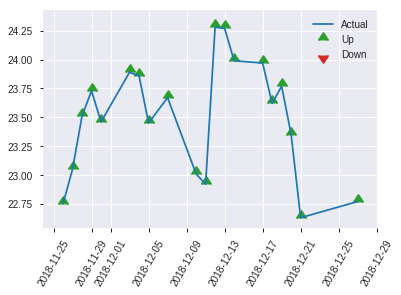


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5344129554655871
RMSE: 0.7310355363903913
LogLoss: 18.44902748605556
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9999999999999455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    115  0        (0.0/115.0)
Total  0    247  0.5344   (132.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.635359  0
max f2                       1            0.813296  0
max f0point5                 1            0.521306  0
max accuracy                 1            0.465587  0
max precision                1            0.465587  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.991903                    1                  0.999397  0.999397           0.465306         1        0.465306                    1                   0.991304        0.991304                   -0.0603372  -0.0603372
    2        1                           1                  1.07391   1                  0.5              1        0.465587                    1                   0.00869565      1                          7.3913      0

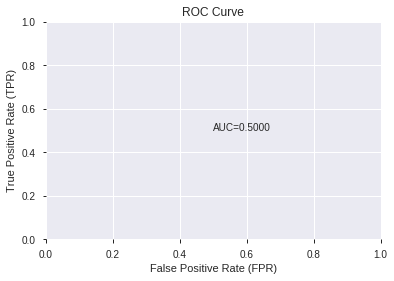

This function is available for GLM models only


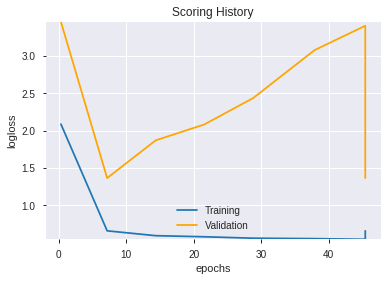

--2019-08-26 13:42:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  43.1MB/s    in 8.6s    

2019-08-26 13:42:51 (40.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_131703_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_131703_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_134300_model_6  0.765481  0.611787              0.295982  0.459496  0.211137
1  DeepLearning_grid_1_AutoML_20190826_134300_model_9  0.757905  0.596577              0.347069  0.449381  0.201943
2  DeepLearning_grid_1_AutoML_20190826_134300_model_8  0.736825  0.644943              0.345652  0.463522  0.214852
3  DeepLearning_grid_1_AutoML_20190826_134300_model_7  0.732872  0.739441              0.364888  0.485616  0.235823
4  DeepLearning_grid_1_AutoML_20190826_134300_model_5  0.711792  0.646823              0.354348  0.469207  0.220155
5  DeepLearning_grid_1_AutoML_20190826_134300_model_3  0.696113  3.564847              0.379480  0.667303  0.445293
6               DeepLearning_1_AutoML_20190826_134300  0.695718  0.838733              0.332049  0.508252  0.258320
7  DeepLearning_grid_1_AutoML_20190826_134300_model_4  0.695059  0.839946              0.393511  0.526883  0.277606
8  DeepLearning_grid_1_AutoML_20190826_134300_model_2  0.691897  2.540843              0.398419  0.577335  0.333316
9  DeepLearning_grid_1_AutoML_20190826_134300_model_1  0.685375  5.817339              0.367128  0.681693  0.464706

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.038430
1          CDLLONGLINE             0.688008           0.688008    0.026440
2                  DIV             0.657510           0.657510    0.025268
3   CDLCLOSINGMARUBOZU             0.633701           0.633701    0.024353
4               Volume             0.568264           0.568264    0.021838
5                  OBV             0.567442           0.567442    0.021807
6        CDLHANGINGMAN             0.559600           0.559600    0.021505
7         STOCHF_fastk             0.546988           0.546988    0.021021
8                  SUB             0.540930           0.540930    0.020788
9            dayofweek             0.537394           0.537394    0.020652
10      STOCHRSI_fastk             0.537162           0.537162    0.020643
11              TRANGE             0.532335           0.532335    0.020458
12         CDLBELTHOLD             0.523227           0.523227    0.020108
13             NATR_24             0.515776           0.515776    0.019821
14                 SIN             0.512818           0.512818    0.019708
15          AROONOSC_8             0.512314           0.512314    0.019688
16               DX_24             0.507822           0.507822    0.019516
17               DX_30             0.506308           0.506308    0.019458
18    CDLDRAGONFLYDOJI             0.504756           0.504756    0.019398
19              BETA_8             0.504159           0.504159    0.019375
20             ADXR_14             0.502909           0.502909    0.019327
21              MFI_30             0.498553           0.498553    0.019159
22             CDLDOJI             0.496707           0.496707    0.019089
23             WILLR_8             0.496435           0.496435    0.019078
24            WILLR_14             0.495851           0.495851    0.019056
25   CDLSTALLEDPATTERN             0.494542           0.494542    0.019005
26          PLUS_DM_24             0.494491           0.494491    0.019003
27               CCI_8             0.492297           0.492297    0.018919
28             NATR_14             0.490650           0.490650    0.018856
29              CCI_12             0.490402           0.490402    0.018846
30                 day             0.489535           0.489535    0.018813
31              ROC_20             0.488607           0.488607    0.018777
32              NATR_8             0.488535           0.488535    0.018774
33             quarter             0.488180           0.488180    0.018761
34               DX_14             0.487451           0.487451    0.018733
35         AROONOSC_20             0.483390           0.483390    0.018577
36            WILLR_20             0.482488           0.482488    0.018542
37                DX_8             0.481958           0.481958    0.018522
38            WILLR_12             0.481863           0.481863    0.018518
39              ULTOSC             0.480236           0.480236    0.018456
40              RSI_14             0.480213           0.480213    0.018455
41          aroonup_12             0.479875           0.479875    0.018442
42               month             0.479208           0.479208    0.018416
43         AROONOSC_12             0.477567           0.477567    0.018353
44         AROONOSC_14             0.476407           0.476407    0.018308
45               CMO_8             0.476047           0.476047    0.018295
46            WILLR_24             0.475532           0.475532    0.018275
47               DX_20             0.474624           0.474624    0.018240
48              CMO_12             0.472638           0.472638    0.018164
49               RSI_8             0.467532           0.467532    0.017967

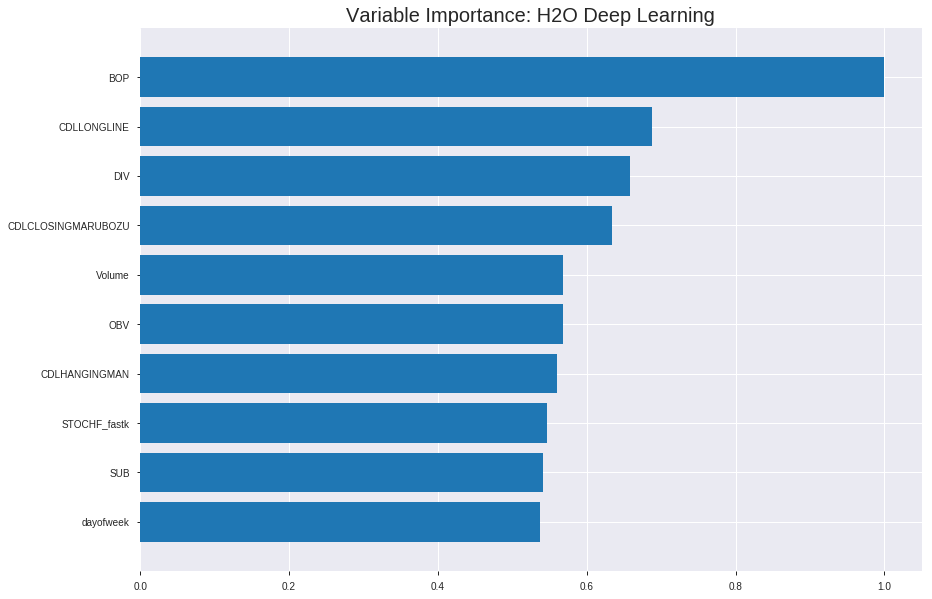

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_134300_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18332409193930463
RMSE: 0.42816362752959836
LogLoss: 0.5449282012255279
Mean Per-Class Error: 0.2695409695409696
AUC: 0.7968410587458207
pr_auc: 0.8080390548164128
Gini: 0.5936821174916413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4845848379084137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      420  357   0.4595   (357.0/777.0)
1      121  824   0.128    (121.0/945.0)
Total  541  1181  0.2776   (478.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484585     0.775165  238
max f2                       0.248532     0.87623   328
max f0point5                 0.594419     0.757543  186
max accuracy                 0.586903     0.732869  190
max precision                0.989667     1         0
max recall                   0.0757254    1         385
max specificity              0.989667     1         0
max absolute_mcc             0.586903     0.460481  190
max min_per_class_accuracy   0.606649     0.725869  180
max mean_per_class_accuracy  0.594419     0.730459  186

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 58.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.969948           1.82222   1.82222            1                0.976066  1                           0.976066            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.957252           1.82222   1.82222            1                0.962628  1                           0.969539            0.0179894       0.037037                   82.2222   82.2222
    3        0.0301974                   0.946494           1.50065   1.71709            0.823529         0.952126  0.942308                    0.963847            0.0148148       0.0518519                  50.0654   71.7094
    4        0.0400697                   0.938376           1.60784   1.69018            0.882353         0.94292   0.927536                    0.958691            0.015873        0.0677249                  60.7843   69.0177
    5        0.0505226                   0.925734           1.61975   1.67561            0.888889         0.929655  0.91954                     0.952683            0.0169312       0.0846561                  61.9753   67.5607
    6        0.100465                    0.880615           1.56796   1.62209            0.860465         0.903873  0.890173                    0.928419            0.0783069       0.162963                   56.7959   62.2094
    7        0.150407                    0.841869           1.56796   1.60412            0.860465         0.85785   0.880309                    0.904987            0.0783069       0.24127                    56.7959   60.4118
    8        0.200348                    0.805764           1.39845   1.55285            0.767442         0.822929  0.852174                    0.884532            0.0698413       0.311111                   39.845    55.285
    9        0.300232                    0.736899           1.47261   1.52616            0.80814          0.772363  0.837524                    0.847215            0.14709         0.458201                   47.261    52.6155
    10       0.400116                    0.678369           1.32429   1.47576            0.726744         0.705795  0.809869                    0.811911            0.132275        0.590476                   32.4289   47.5762
    11       0.5                         0.620549           1.04884   1.39048            0.575581         0.64801   0.763066                    0.779169            0.104762        0.695238                   4.88372   39.0476
    12       0.599884                    0.552098           1.02765   1.33006            0.563953         0.58598   0.729913                    0.747002            0.102646        0.797884                   2.76486   33.0063
    13       0.699768                    0.473266           0.826357  1.25817            0.453488         0.51366   0.690456                    0.713695            0.0825397       0.880423                   -17.3643  25.8165
    14       0.799652                    0.362543           0.603876  1.17644            0.331395         0.41758   0.645606                    0.676708            0.0603175       0.940741                   -39.6124  17.6438
    15       0.899535                    0.211961           0.434367  1.09404            0.238372         0.285966  0.600387                    0.63332             0.0433862       0.984127                   -56.5633  9.40392
    16       1                           0.0142675          0.157996  1                  0.0867052        0.126927  0.54878                     0.582445          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20586130598060076
RMSE: 0.45371941327278553
LogLoss: 0.5968244188899136
Mean Per-Class Error: 0.3086229946524064
AUC: 0.746941844919786
pr_auc: 0.7701020899072861
Gini: 0.493883689839572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3641170047139267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   149  0.6773   (149.0/220.0)
1      20   252  0.0735   (20.0/272.0)
Total  91   401  0.3435   (169.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364117     0.748886  316
max f2                       0.237052     0.871828  360
max f0point5                 0.53916      0.729537  171
max accuracy                 0.511068     0.689024  196
max precision                0.942798     1         0
max recall                   0.149677     1         380
max specificity              0.942798     1         0
max absolute_mcc             0.53916      0.381533  171
max min_per_class_accuracy   0.502666     0.681818  204
max mean_per_class_accuracy  0.511068     0.691377  196

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 50.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.874711           1.80882   1.80882            1                0.912105  1                           0.912105            0.0183824       0.0183824                  80.8824   80.8824
    2        0.0203252                   0.851139           1.08529   1.44706            0.6              0.865287  0.8                         0.888696            0.0110294       0.0294118                  8.52941   44.7059
    3        0.0304878                   0.841493           1.80882   1.56765            1                0.846019  0.866667                    0.87447             0.0183824       0.0477941                  80.8824   56.7647
    4        0.0406504                   0.821798           1.80882   1.62794            1                0.83451   0.9                         0.86448             0.0183824       0.0661765                  80.8824   62.7941
    5        0.050813                    0.81063            1.80882   1.66412            1                0.816899  0.92                        0.854964            0.0183824       0.0845588                  80.8824   66.4118
    6        0.101626                    0.732009           1.44706   1.55559            0.8              0.767097  0.86                        0.81103             0.0735294       0.158088                   44.7059   55.5588
    7        0.150407                    0.68137            1.58272   1.56439            0.875            0.701133  0.864865                    0.775388            0.0772059       0.235294                   58.2721   56.4388
    8        0.20122                     0.640348           1.37471   1.51649            0.76             0.656343  0.838384                    0.745326            0.0698529       0.305147                   37.4706   51.6488
    9        0.300813                    0.590837           1.40276   1.47884            0.77551          0.614424  0.817568                    0.701987            0.139706        0.444853                   40.2761   47.8835
    10       0.400407                    0.55171            1.18127   1.40482            0.653061         0.570309  0.77665                     0.669235            0.117647        0.5625                     18.1273   40.4822
    11       0.5                         0.510041           1.07053   1.33824            0.591837         0.530699  0.739837                    0.64164             0.106618        0.669118                   7.05282   33.8235
    12       0.599593                    0.465686           0.812125  1.25085            0.44898          0.490051  0.691525                    0.616461            0.0808824       0.75                       -18.7875  25.0847
    13       0.699187                    0.430509           0.738295  1.17784            0.408163         0.448313  0.651163                    0.59251             0.0735294       0.823529                   -26.1705  17.7839
    14       0.79878                     0.380587           0.885954  1.14145            0.489796         0.408519  0.631043                    0.56957             0.0882353       0.911765                   -11.4046  14.1446
    15       0.898374                    0.260141           0.590636  1.08038            0.326531         0.321507  0.597285                    0.542069            0.0588235       0.970588                   -40.9364  8.03833
    16       1                           0.0678519          0.289412  1                  0.16             0.174427  0.552846                    0.504707         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:48:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:48:32  3 min  4.153 sec  982 obs/sec       1.29094   1             2223       0.494883         0.826341            0.0109491      0.752262        0.769742           1.82222          0.31475                          0.648054           1.77262               -0.698871        0.722685          0.742023             1.80882            0.355691
    2019-08-26 13:48:39  3 min 11.114 sec  1817 obs/sec      9.04936   7             15583      0.428164         0.544928            0.259657       0.796841        0.808039           1.82222          0.277584                         0.453719           0.596824              0.167252         0.746942          0.770102             1.80882            0.343496
    2019-08-26 13:48:46  3 min 17.725 sec  2289 obs/sec      19.3357   15            33296      0.422457         0.533263            0.279262       0.804751        0.817581           1.82222          0.277584                         0.454447           0.598539              0.164578         0.749766          0.775681             1.80882            0.325203
    2019-08-26 13:48:52  3 min 24.316 sec  2505 obs/sec      29.7915   23            51301      0.420333         0.531126            0.286489       0.817172        0.825363           1.82222          0.255517                         0.453238           0.599529              0.169019         0.743441          0.766371             1.44706            0.333333
    2019-08-26 13:48:59  3 min 31.578 sec  2632 obs/sec      41.4059   32            71301      0.409032         0.506906            0.32434        0.828567        0.836651           1.82222          0.240418                         0.458569           0.61128               0.149356         0.750084          0.770827             1.44706            0.335366
    2019-08-26 13:49:07  3 min 38.719 sec  2722 obs/sec      53.0337   41            91324      0.404752         0.497615            0.338405       0.833209        0.839524           1.82222          0.239257                         0.453611           0.60643               0.16765          0.75056           0.772304             1.80882            0.341463
    2019-08-26 13:49:14  3 min 45.814 sec  2785 obs/sec      64.6974   50            111409     0.399523         0.490368            0.35539        0.842218        0.843535           1.72099          0.235192                         0.455394           0.608954              0.161093         0.74482           0.766521             1.44706            0.357724
    2019-08-26 13:49:14  3 min 46.517 sec  2784 obs/sec      64.6974   50            111409     0.428164         0.544928            0.259657       0.796841        0.808039           1.82222          0.277584                         0.453719           0.596824              0.167252         0.746942          0.770102             1.80882            0.343496

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03843015218270318
CDLLONGLINE         0.6880075335502625     0.6880075335502625   0.02644023421718285
DIV                 0.6575098633766174     0.6575098633766174   0.025268204111191784
CDLCLOSINGMARUBOZU  0.6337009072303772     0.6337009072303772   0.024353222303180468
Volume              0.5682641267776489     0.5682641267776489   0.02183847687203598
---                 ---                    ---                  ---
CMO_8               0.4760470986366272     0.4760470986366272   0.018294562446739895
WILLR_24            0.4755322337150574     0.4755322337150574   0.01827477610945043
DX_20               0.47462448477745056    0.47462448477745056  0.018239891179634513
CMO_12              0.4726378619670868     0.4726378619670868   0.018163544962702605
RSI_8               0.4675319194793701     0.4675319194793701   0.017967322815863523


See the whole table with table.as_data_frame()


('accuracy', 0.7246963562753036)

('F1', 0.7016129032258064)

('auc', 0.7654808959156785)

('logloss', 0.6117871825509066)

('mean_per_class_error', 0.28837285902503296)

('rmse', 0.45949646137543904)

('mse', 0.21113699801655034)

deeplearning prediction progress: |███████████████████████████████████████| 100%


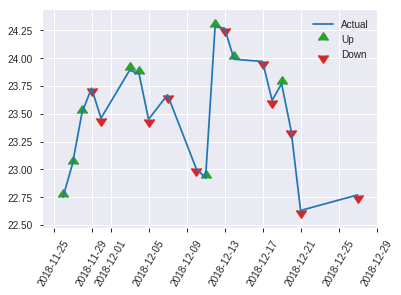


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21113699801655034
RMSE: 0.45949646137543904
LogLoss: 0.6117871825509066
Mean Per-Class Error: 0.28837285902503296
AUC: 0.7654808959156785
pr_auc: 0.7280298488183184
Gini: 0.5309617918313569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40490498071650133: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   46   0.3485   (46.0/132.0)
1      28   87   0.2435   (28.0/115.0)
Total  114  133  0.2996   (74.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404905     0.701613  132
max f2                       0.196349     0.826149  235
max f0point5                 0.478109     0.737101  72
max accuracy                 0.478109     0.724696  72
max precision                0.574264     0.888889  26
max recall                   0.196349     1         235
max specificity              0.751674     0.992424  0
max absolute_mcc             0.478109     0.462702  72
max min_per_class_accuracy   0.421622     0.704348  119
max mean_per_class_accuracy  0.478109     0.711627  72

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 41.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.681952           1.43188   1.43188            0.666667         0.729657  0.666667                    0.729657            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.665896           1.07391   1.2887             0.5              0.672255  0.6                         0.706696            0.00869565      0.026087                   7.3913    28.8696
    3        0.0323887                   0.662661           2.14783   1.61087            1                0.664815  0.75                        0.690991            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.643572           2.14783   1.71826            1                0.652967  0.8                         0.683386            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.628166           2.14783   1.81739            1                0.636145  0.846154                    0.672484            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.578414           1.96884   1.89009            0.916667         0.60272   0.88                        0.638997            0.0956522       0.191304                   96.8841   89.0087
    7        0.149798                    0.554676           1.78986   1.85758            0.833333         0.566721  0.864865                    0.615556            0.0869565       0.278261                   78.9855   85.7579
    8        0.202429                    0.521484           1.81739   1.84713            0.846154         0.536526  0.86                        0.595008            0.0956522       0.373913                   81.7391   84.713
    9        0.299595                    0.476882           1.52138   1.74148            0.708333         0.500736  0.810811                    0.564433            0.147826        0.521739                   52.1377   74.1481
    10       0.40081                     0.441646           0.85913   1.51866            0.4              0.461776  0.707071                    0.53851             0.0869565       0.608696                   -14.087   51.8665
    11       0.502024                    0.414542           1.03096   1.42034            0.48             0.430804  0.66129                     0.516795            0.104348        0.713043                   3.09565   42.0337
    12       0.59919                     0.385789           0.805435  1.32062            0.375            0.400667  0.614865                    0.497963            0.0782609       0.791304                   -19.4565  32.0623
    13       0.700405                    0.354263           0.601391  1.21669            0.28             0.370277  0.566474                    0.479512            0.0608696       0.852174                   -39.8609  21.6688
    14       0.797571                    0.3253             0.715942  1.15568            0.333333         0.342344  0.538071                    0.462801            0.0695652       0.921739                   -28.4058  15.5683
    15       0.898785                    0.23507            0.429565  1.07391            0.2              0.277231  0.5                         0.441903            0.0434783       0.965217                   -57.0435  7.3913
    16       1                           0.128272           0.343652  1                  0.16             0.201711  0.465587                    0.417592            

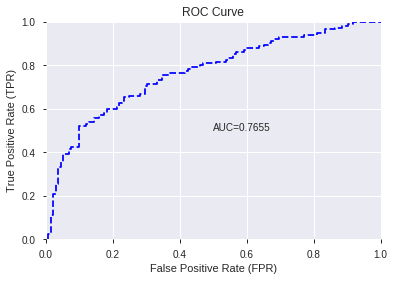

This function is available for GLM models only


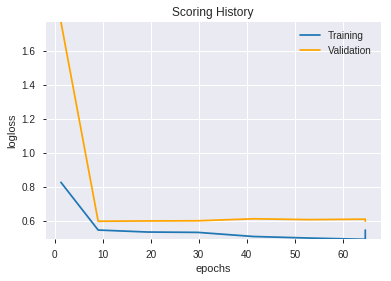

--2019-08-26 13:53:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_134300_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_134300_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'Volume',
 'OBV',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'SUB',
 'dayofweek',
 'STOCHRSI_fastk',
 'TRANGE',
 'CDLBELTHOLD',
 'NATR_24',
 'SIN',
 'AROONOSC_8',
 'DX_24',
 'DX_30',
 'CDLDRAGONFLYDOJI',
 'BETA_8',
 'ADXR_14',
 'MFI_30',
 'CDLDOJI',
 'WILLR_8',
 'WILLR_14',
 'CDLSTALLEDPATTERN',
 'PLUS_DM_24',
 'CCI_8',
 'NATR_14',
 'CCI_12',
 'day',
 'ROC_20',
 'NATR_8',
 'quarter',
 'DX_14',
 'AROONOSC_20',
 'WILLR_20',
 'DX_8',
 'WILLR_12',
 'ULTOSC',
 'RSI_14',
 'aroonup_12',
 'month',
 'AROONOSC_12',
 'AROONOSC_14',
 'CMO_8',
 'WILLR_24',
 'DX_20',
 'CMO_12',
 'RSI_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_135318_model_1  0.774967  0.653264              0.324901  0.467485  0.218542

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.490042           1.000000    0.164677
1                  DIV             0.185606           0.378756    0.062372
2          CDLLONGLINE             0.168804           0.344468    0.056726
3           AROONOSC_8             0.138420           0.282466    0.046516
4                  SUB             0.123439           0.251895    0.041481
5       STOCHRSI_fastk             0.112451           0.229472    0.037789
6   CDLCLOSINGMARUBOZU             0.106462           0.217252    0.035776
7         STOCHF_fastk             0.097455           0.198870    0.032749
8        CDLHANGINGMAN             0.097278           0.198509    0.032690
9               Volume             0.095957           0.195814    0.032246
10    CDLDRAGONFLYDOJI             0.091616           0.186955    0.030787
11                 SIN             0.086912           0.177356    0.029206
12               CCI_8             0.078707           0.160612    0.026449
13              TRANGE             0.073284           0.149546    0.024627
14              MFI_30             0.069528           0.141882    0.023365
15         AROONOSC_14             0.069046           0.140898    0.023203
16            WILLR_12             0.062069           0.126661    0.020858
17                 OBV             0.056097           0.114474    0.018851
18              CCI_12             0.053518           0.109210    0.017984
19         CDLBELTHOLD             0.053157           0.108475    0.017863
20                 day             0.044225           0.090248    0.014862
21            WILLR_24             0.042762           0.087261    0.014370
22            WILLR_14             0.041243           0.084162    0.013860
23            WILLR_20             0.037944           0.077431    0.012751
24             ADXR_14             0.037422           0.076365    0.012575
25              BETA_8             0.034722           0.070855    0.011668
26               DX_30             0.033177           0.067703    0.011149
27              ROC_20             0.033144           0.067634    0.011138
28           dayofweek             0.030988           0.063236    0.010413
29               CMO_8             0.028347           0.057847    0.009526
30               RSI_8             0.027739           0.056605    0.009321
31             quarter             0.027164           0.055431    0.009128
32              NATR_8             0.024921           0.050855    0.008375
33   CDLSTALLEDPATTERN             0.023678           0.048318    0.007957
34             WILLR_8             0.023060           0.047058    0.007749
35               DX_24             0.022213           0.045328    0.007465
36             NATR_24             0.021277           0.043419    0.007150
37              ULTOSC             0.020586           0.042008    0.006918
38         AROONOSC_20             0.019461           0.039714    0.006540
39               month             0.016905           0.034496    0.005681
40          aroonup_12             0.016123           0.032901    0.005418
41         AROONOSC_12             0.012984           0.026496    0.004363
42              CMO_12             0.011901           0.024286    0.003999
43               DX_20             0.010619           0.021669    0.003568
44          PLUS_DM_24             0.006086           0.012420    0.002045
45             CDLDOJI             0.005161           0.010531    0.001734
46               DX_14             0.004319           0.008814    0.001451
47             NATR_14             0.003827           0.007810    0.001286
48              RSI_14             0.003137           0.006401    0.001054
49                DX_8             0.000803           0.001638    0.000270

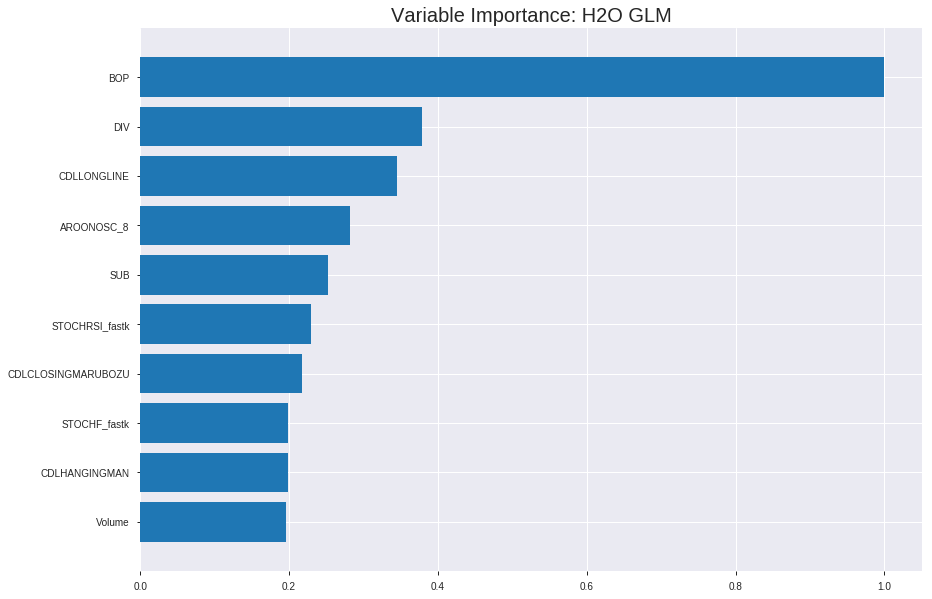

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_135318_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18701879745386532
RMSE: 0.4324567000913101
LogLoss: 0.5557935143667773
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2370.782545663055
Residual deviance: 1914.1528634791807
AIC: 2016.1528634791807
AUC: 0.7889093174807461
pr_auc: 0.7971156722967951
Gini: 0.5778186349614922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46235128752237936: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  333   0.4286   (333.0/777.0)
1      137  808   0.145    (137.0/945.0)
Total  581  1141  0.2729   (470.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462351     0.774688  238
max f2                       0.249668     0.872717  332
max f0point5                 0.563547     0.7514    182
max accuracy                 0.488059     0.728804  226
max precision                0.943657     1         0
max recall                   0.0815507    1         386
max specificity              0.943657     1         0
max absolute_mcc             0.469855     0.450152  234
max min_per_class_accuracy   0.556498     0.719434  186
max mean_per_class_accuracy  0.551595     0.721922  188

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.913719           1.61975   1.61975            0.888889         0.921197  0.888889                    0.921197            0.0169312       0.0169312                  61.9753    61.9753
    2        0.0203252                   0.898027           1.60784   1.61397            0.882353         0.907562  0.885714                    0.914575            0.015873        0.0328042                  60.7843    61.3968
    3        0.0301974                   0.887551           1.71503   1.64701            0.941176         0.89352   0.903846                    0.907691            0.0169312       0.0497354                  71.5033    64.7009
    4        0.0400697                   0.879267           1.71503   1.66377            0.941176         0.883491  0.913043                    0.901729            0.0169312       0.0666667                  71.5033    66.3768
    5        0.0505226                   0.86672            1.51852   1.63372            0.833333         0.872577  0.896552                    0.895698            0.015873        0.0825397                  51.8519    63.3716
    6        0.100465                    0.817043           1.52558   1.57996            0.837209         0.838181  0.867052                    0.867106            0.0761905       0.15873                    52.5581    57.9961
    7        0.150407                    0.781958           1.61034   1.59005            0.883721         0.798502  0.872587                    0.844326            0.0804233       0.239153                   61.0336    59.0047
    8        0.200348                    0.751004           1.44083   1.55285            0.790698         0.765196  0.852174                    0.824601            0.0719577       0.311111                   44.0827    55.285
    9        0.300232                    0.692439           1.38786   1.49796            0.761628         0.721023  0.82205                     0.790142            0.138624        0.449735                   38.7855    49.7958
    10       0.400116                    0.633196           1.33488   1.45725            0.732558         0.663387  0.79971                     0.758499            0.133333        0.583069                   33.4884    45.7249
    11       0.5                         0.568298           1.13359   1.39259            0.622093         0.597421  0.764228                    0.726321            0.113228        0.696296                   13.3592    39.2593
    12       0.599884                    0.507803           0.995866  1.32654            0.546512         0.537384  0.727977                    0.694862            0.0994709       0.795767                   -0.413437  32.6535
    13       0.699768                    0.437306           0.805168  1.25212            0.44186          0.471993  0.687137                    0.66305             0.0804233       0.87619                    -19.4832   25.2116
    14       0.799652                    0.351384           0.603876  1.17115            0.331395         0.396252  0.642702                    0.629724            0.0603175       0.936508                   -39.6124   17.1145
    15       0.899535                    0.232226           0.455556  1.09169            0.25             0.294027  0.599096                    0.592449            0.0455026       0.982011                   -54.4444   9.16864
    16       1                           0.0124266          0.179062  1                  0.0982659        0.157785  0.54878                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20439807470822885
RMSE: 0.4521040529659393
LogLoss: 0.5945388588741316
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 676.5834633095117
Residual deviance: 585.0262371321454
AIC: 687.0262371321454
AUC: 0.7525066844919787
pr_auc: 0.7654246590104562
Gini: 0.5050133689839573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28329368719992903: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   147  0.6682   (147.0/220.0)
1      20   252  0.0735   (20.0/272.0)
Total  93   399  0.3394   (167.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283294     0.751118  319
max f2                       0.134836     0.872505  376
max f0point5                 0.536368     0.740418  173
max accuracy                 0.536368     0.693089  173
max precision                0.927771     1         0
max recall                   0.0855177    1         386
max specificity              0.927771     1         0
max absolute_mcc             0.536368     0.402451  173
max min_per_class_accuracy   0.492511     0.681818  205
max mean_per_class_accuracy  0.536368     0.701136  173

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.881043           1.44706   1.44706            0.8              0.896641  0.8                         0.896641            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.865403           1.80882   1.62794            1                0.87201   0.9                         0.884326            0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.849209           1.44706   1.56765            0.8              0.854312  0.866667                    0.874321            0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.835782           1.44706   1.5375             0.8              0.844076  0.85                        0.86676             0.0147059       0.0625                     44.7059   53.75
    5        0.050813                    0.817659           1.44706   1.51941            0.8              0.827244  0.84                        0.858857            0.0147059       0.0772059                  44.7059   51.9412
    6        0.101626                    0.760454           1.59176   1.55559            0.88             0.788673  0.86                        0.823765            0.0808824       0.158088                   59.1765   55.5588
    7        0.150407                    0.717559           1.50735   1.53994            0.833333         0.736861  0.851351                    0.79558             0.0735294       0.231618                   50.7353   53.9944
    8        0.20122                     0.68124            1.51941   1.53476            0.84             0.696541  0.848485                    0.77057             0.0772059       0.308824                   51.9412   53.4759
    9        0.300813                    0.615791           1.36585   1.47884            0.755102         0.649489  0.817568                    0.730482            0.136029        0.444853                   36.5846   47.8835
    10       0.400407                    0.554308           1.29202   1.43237            0.714286         0.587402  0.791878                    0.694894            0.128676        0.573529                   29.2017   43.2368
    11       0.5                         0.507375           0.885954  1.32353            0.489796         0.531176  0.731707                    0.662283            0.0882353       0.661765                   -11.4046  32.3529
    12       0.599593                    0.450705           0.885954  1.25085            0.489796         0.477393  0.691525                    0.631573            0.0882353       0.75                       -11.4046  25.0847
    13       0.699187                    0.377686           0.922869  1.20413            0.510204         0.416225  0.665698                    0.600898            0.0919118       0.841912                   -7.71309  20.413
    14       0.79878                     0.293885           0.627551  1.13224            0.346939         0.342517  0.625954                    0.568683            0.0625          0.904412                   -37.2449  13.2241
    15       0.898374                    0.199987           0.701381  1.08448            0.387755         0.251707  0.599548                    0.533543            0.0698529       0.974265                   -29.8619  8.44756
    16       1                           0.0167912          0.253235  1                  0.14             0.117707  0.552846                    0.491283            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 13:53:19  0.000 sec   2            22        51            1.35503           1.3565
    2019-08-26 13:53:19  0.066 sec   4            14        51            1.34412           1.34718
    2019-08-26 13:53:19  0.126 sec   6            8.4       51            1.32915           1.33447
    2019-08-26 13:53:19  0.192 sec   8            5.2       51            1.30971           1.31813
    2019-08-26 13:53:19  0.256 sec   10           3.3       51            1.28597           1.29856
    2019-08-26 13:53:19  0.329 sec   12           2         51            1.25887           1.27694
    2019-08-26 13:53:19  0.357 sec   14           1.3       51            1.23025           1.25527
    2019-08-26 13:53:19  0.374 sec   16           0.78      51            1.2022            1.2355
    2019-08-26 13:53:19  0.394 sec   18           0.48      51            1.17663           1.21899
    2019-08-26 13:53:19  0.413 sec   20           0.3       51            1.15466           1.2062
    2019-08-26 13:53:19  0.433 sec   22           0.19      51            1.13665           1.19703
    2019-08-26 13:53:19  0.452 sec   24           0.12      51            1.12243           1.1913
    2019-08-26 13:53:19  0.469 sec   26           0.072     51            1.11159           1.18908
    2019-08-26 13:53:19  0.490 sec   28           0.045     51            1.10361           1.1909
    2019-08-26 13:53:19  0.510 sec   30           0.028     51            1.09796           1.19662
    2019-08-26 13:53:19  0.525 sec   32           0.017     51            1.09406           1.20624
    2019-08-26 13:53:19  0.540 sec   34           0.011     51            1.09142           1.21896
    2019-08-26 13:53:19  0.559 sec   36           0.0067    51            1.08966           1.23297

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7103448275862069)

('auc', 0.7749670619235837)

('logloss', 0.6532644412297008)

('mean_per_class_error', 0.28501317523056646)

('rmse', 0.4674850221493876)

('mse', 0.2185422459340134)

glm prediction progress: |████████████████████████████████████████████████| 100%


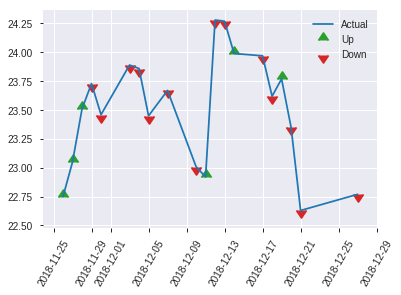


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2185422459340134
RMSE: 0.4674850221493876
LogLoss: 0.6532644412297008
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 348.1046065632917
Residual deviance: 322.7126339674723
AIC: 424.7126339674723
AUC: 0.7749670619235837
pr_auc: 0.7386787243984415
Gini: 0.5499341238471673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16658492530139735: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   72   0.5455   (72.0/132.0)
1      12   103  0.1043   (12.0/115.0)
Total  72   175  0.3401   (84.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166585     0.710345  174
max f2                       0.0937157    0.828358  209
max f0point5                 0.434049     0.727763  63
max accuracy                 0.367149     0.724696  84
max precision                0.617717     0.923077  25
max recall                   0.00242394   1         245
max specificity              0.812969     0.992424  0
max absolute_mcc             0.367149     0.451451  84
max min_per_class_accuracy   0.289224     0.704545  120
max mean_per_class_accuracy  0.367149     0.714987  84

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 30.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.728879           1.43188   1.43188            0.666667         0.767632   0.666667                    0.767632            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.721528           2.14783   1.71826            1                0.726411   0.8                         0.751144            0.0173913       0.0347826                  114.783   71.8261
    3        0.0323887                   0.71377            1.43188   1.61087            0.666667         0.719875   0.75                        0.739418            0.0173913       0.0521739                  43.1884   61.087
    4        0.0404858                   0.691265           2.14783   1.71826            1                0.704497   0.8                         0.732434            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.685611           2.14783   1.81739            1                0.687417   0.846154                    0.722045            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.618584           2.14783   1.976              1                0.640352   0.92                        0.682833            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.565061           1.78986   1.91563            0.833333         0.590902   0.891892                    0.653017            0.0869565       0.286957                   78.9855   91.5629
    8        0.202429                    0.504349           1.48696   1.80417            0.692308         0.523267   0.84                        0.619282            0.0782609       0.365217                   48.6957   80.4174
    9        0.299595                    0.402928           1.43188   1.68343            0.666667         0.444743   0.783784                    0.562675            0.13913         0.504348                   43.1884   68.3431
    10       0.40081                     0.338924           1.11687   1.54036            0.52             0.367707   0.717172                    0.513441            0.113043        0.617391                   11.687    54.036
    11       0.502024                    0.28479            1.03096   1.43766            0.48             0.306602   0.669355                    0.471739            0.104348        0.721739                   3.09565   43.7658
    12       0.59919                     0.231278           0.626449  1.30611            0.291667         0.25743    0.608108                    0.436986            0.0608696       0.782609                   -37.3551  30.611
    13       0.700405                    0.16952            0.945043  1.25393            0.44             0.195121   0.583815                    0.402035            0.0956522       0.878261                   -5.49565  25.3933
    14       0.797571                    0.110919           0.536957  1.16659            0.25             0.144918   0.543147                    0.370711            0.0521739       0.930435                   -46.3043  16.6586
    15       0.898785                    0.0658514          0.343652  1.07391            0.16             0.092014   0.5                         0.339326            0.0347826       0.965217                   -65.6348  7.3913
    16       1                           0.00079954         0.343652  1                  0.16             0.0399908  0.465587                    0.3090

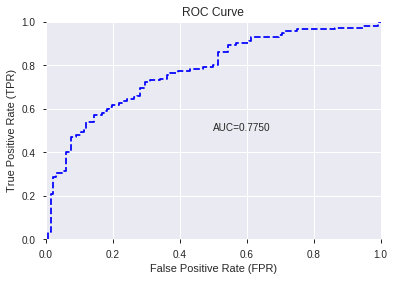

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


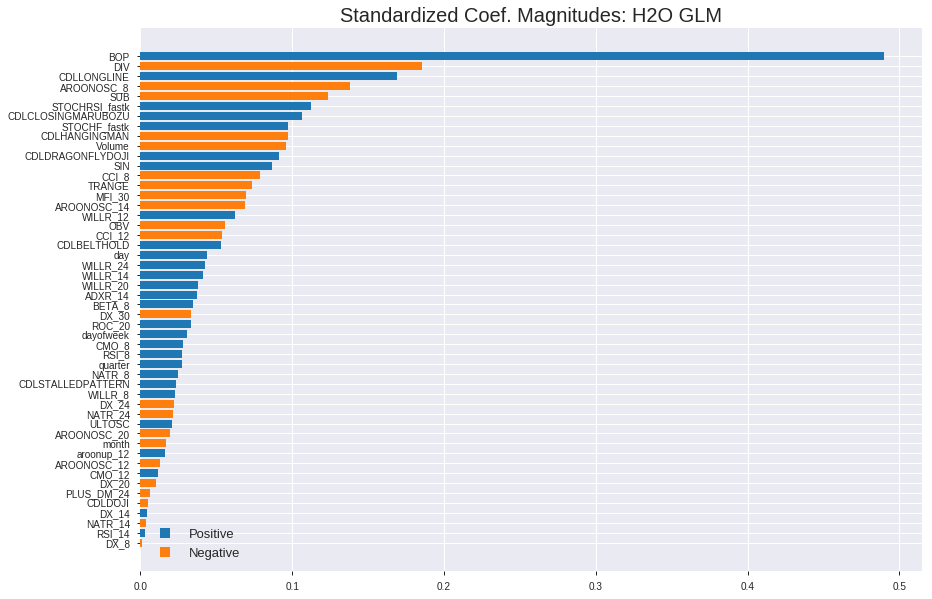

'log_likelihood'
--2019-08-26 13:53:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_135318_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_135318_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'DIV',
 'CDLLONGLINE',
 'AROONOSC_8',
 'SUB',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'SIN',
 'CCI_8',
 'TRANGE',
 'MFI_30',
 'AROONOSC_14',
 'WILLR_12',
 'OBV',
 'CCI_12',
 'CDLBELTHOLD',
 'day',
 'WILLR_24',
 'WILLR_14',
 'WILLR_20',
 'ADXR_14',
 'BETA_8',
 'DX_30',
 'ROC_20',
 'dayofweek',
 'CMO_8',
 'RSI_8',
 'quarter',
 'NATR_8',
 'CDLSTALLEDPATTERN',
 'WILLR_8',
 'DX_24',
 'NATR_24',
 'ULTOSC',
 'AROONOSC_20',
 'month',
 'aroonup_12',
 'AROONOSC_12',
 'CMO_12',
 'DX_20',
 'PLUS_DM_24',
 'CDLDOJI',
 'DX_14',
 'NATR_14',
 'RSI_14',
 'DX_8']

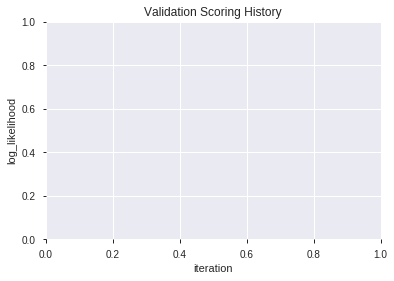

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190826_135331  0.794071  0.556862              0.248584  0.431879  0.186519
1  XGBoost_grid_1_AutoML_20190826_135331_model_4  0.792029  0.563863              0.275791  0.435573  0.189724
2  XGBoost_grid_1_AutoML_20190826_135331_model_3  0.790975  0.560436              0.281686  0.434232  0.188557
3  XGBoost_grid_1_AutoML_20190826_135331_model_2  0.780896  0.586543              0.305402  0.446618  0.199468
4               XGBoost_3_AutoML_20190826_135331  0.774440  0.582056              0.303294  0.444528  0.197605
5  XGBoost_grid_1_AutoML_20190826_135331_model_1  0.774242  0.580524              0.288274  0.442999  0.196248
6  XGBoost_grid_1_AutoML_20190826_135331_model_6  0.767721  0.586353              0.329677  0.447058  0.199861
7               XGBoost_1_AutoML_20190826_135331  0.767062  0.582271              0.311858  0.445423  0.198401
8  XGBoost_grid_1_AutoML_20190826_135331_model_7  0.764229  0.585076              0.293050  0.445629  0.198585
9  XGBoost_grid_1_AutoML_20190826_135331_model_5  0.748485  0.592353              0.313241  0.450170  0.202653

variable  relative_importance  scaled_importance  percentage
0                  BOP          2261.427734           1.000000    0.303224
1                  DIV           620.439941           0.274358    0.083192
2               Volume           309.909119           0.137041    0.041554
3       STOCHRSI_fastk           297.154541           0.131401    0.039844
4                CCI_8           244.914856           0.108301    0.032839
5                  OBV           232.928207           0.103001    0.031232
6         STOCHF_fastk           204.884094           0.090599    0.027472
7           PLUS_DM_24           180.036102           0.079612    0.024140
8                  SUB           159.692215           0.070616    0.021412
9             WILLR_20           152.601151           0.067480    0.020462
10              NATR_8           132.510864           0.058596    0.017768
11              MFI_30           128.415146           0.056785    0.017219
12             ADXR_14           128.170074           0.056677    0.017186
13               DX_30           125.873466           0.055661    0.016878
14              TRANGE           124.332359           0.054980    0.016671
15             NATR_24           123.318909           0.054531    0.016535
16            WILLR_24           122.594070           0.054211    0.016438
17              BETA_8           116.459099           0.051498    0.015615
18             NATR_14           104.174576           0.046066    0.013968
19               DX_24           102.586647           0.045364    0.013755
20         CDLLONGLINE           102.166473           0.045178    0.013699
21          AROONOSC_8           101.988678           0.045099    0.013675
22              CCI_12            90.713722           0.040113    0.012163
23                DX_8            86.766068           0.038368    0.011634
24              ROC_20            86.246864           0.038138    0.011564
25                 SIN            81.767838           0.036158    0.010964
26               month            79.354904           0.035091    0.010640
27               CMO_8            78.006744           0.034494    0.010460
28         AROONOSC_14            76.490578           0.033824    0.010256
29            WILLR_14            72.895401           0.032234    0.009774
30                 day            72.157860           0.031908    0.009675
31              ULTOSC            68.120491           0.030123    0.009134
32             WILLR_8            66.838249           0.029556    0.008962
33              RSI_14            62.492775           0.027634    0.008379
34         AROONOSC_12            61.344925           0.027127    0.008225
35         AROONOSC_20            56.487751           0.024979    0.007574
36            WILLR_12            54.889885           0.024272    0.007360
37          aroonup_12            52.182835           0.023075    0.006997
38               DX_20            48.040249           0.021243    0.006441
39              CMO_12            47.933983           0.021196    0.006427
40           dayofweek            41.402008           0.018308    0.005551
41               DX_14            36.501659           0.016141    0.004894
42               RSI_8            35.969669           0.015906    0.004823
43             quarter            11.773804           0.005206    0.001579
44  CDLCLOSINGMARUBOZU             9.025551           0.003991    0.001210
45             CDLDOJI             3.974323           0.001757    0.000533

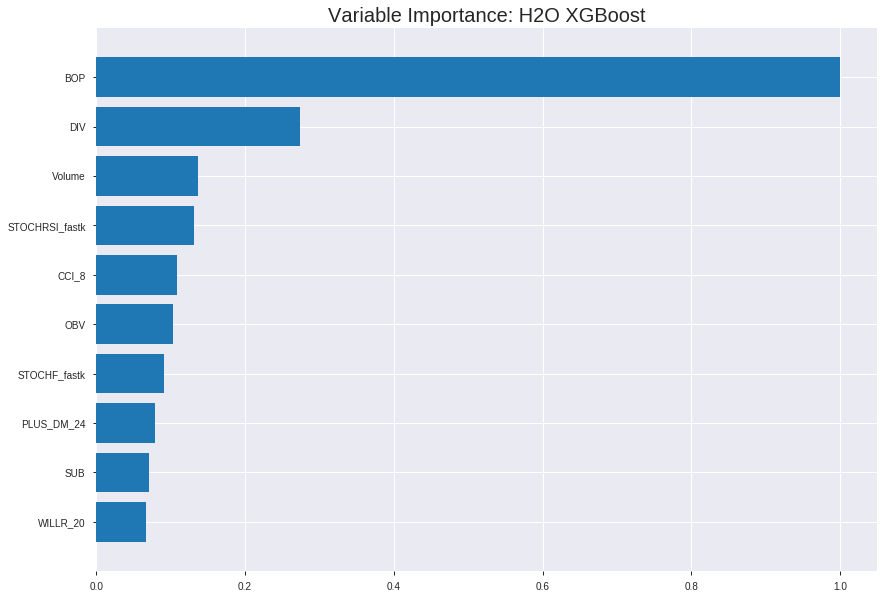

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190826_135331


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13779823374594005
RMSE: 0.3712118448351831
LogLoss: 0.43918851232722855
Mean Per-Class Error: 0.17593307593307594
AUC: 0.9016050063669111
pr_auc: 0.9161511164748839
Gini: 0.8032100127338222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5079137235879898: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      592  185   0.2381   (185.0/777.0)
1      119  826   0.1259   (119.0/945.0)
Total  711  1011  0.1765   (304.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507914     0.844581  211
max f2                       0.305414     0.899063  298
max f0point5                 0.685217     0.847673  124
max accuracy                 0.537605     0.826365  197
max precision                0.924348     1         0
max recall                   0.152444     1         360
max specificity              0.924348     1         0
max absolute_mcc             0.537605     0.649005  197
max min_per_class_accuracy   0.562089     0.815959  186
max mean_per_class_accuracy  0.537605     0.824067  197

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.46 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.899181           1.82222    1.82222            1                0.908731  1                           0.908731            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.890459           1.82222    1.82222            1                0.894498  1                           0.901818            0.0179894       0.037037                   82.2222   82.2222
    3        0.0301974                   0.882999           1.82222    1.82222            1                0.885874  1                           0.896605            0.0179894       0.0550265                  82.2222   82.2222
    4        0.0400697                   0.875001           1.82222    1.82222            1                0.879851  1                           0.892477            0.0179894       0.0730159                  82.2222   82.2222
    5        0.0505226                   0.869546           1.82222    1.82222            1                0.87219   1                           0.88828             0.0190476       0.0920635                  82.2222   82.2222
    6        0.100465                    0.8401             1.80103    1.81169            0.988372         0.853607  0.99422                     0.871044            0.0899471       0.182011                   80.1034   81.1689
    7        0.150407                    0.818707           1.73747    1.78704            0.953488         0.829816  0.980695                    0.857354            0.0867725       0.268783                   73.7468   78.7044
    8        0.200348                    0.791049           1.77984    1.78525            0.976744         0.804043  0.97971                     0.844065            0.0888889       0.357672                   77.9845   78.525
    9        0.300232                    0.737546           1.61034    1.72706            0.883721         0.764172  0.947776                    0.817486            0.160847        0.518519                   61.0336   72.7058
    10       0.400116                    0.671847           1.41964    1.65031            0.77907          0.704886  0.90566                     0.789376            0.141799        0.660317                   41.9638   65.0314
    11       0.5                         0.588768           1.22894    1.56614            0.674419         0.630516  0.859466                    0.757641            0.122751        0.783069                   22.8941   56.6138
    12       0.599884                    0.497029           0.974677   1.46766            0.534884         0.542051  0.805421                    0.721744            0.0973545       0.880423                   -2.5323   46.7656
    13       0.699768                    0.384873           0.61447    1.34587            0.337209         0.437902  0.738589                    0.681229            0.0613757       0.941799                   -38.553   34.5874
    14       0.799652                    0.28565            0.339018   1.22011            0.186047         0.335673  0.669572                    0.638066            0.0338624       0.975661                   -66.0982  22.0108
    15       0.899535                    0.171734           0.222481   1.10933            0.122093         0.232523  0.60878                     0.593035            0.0222222       0.997884                   -77.7519  10.9332
    16       1                           0.0527005          0.0210662  1                  0.0115607        0.111127  0.54878                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19794674116347086
RMSE: 0.44491206003374517
LogLoss: 0.5802347700789503
Mean Per-Class Error: 0.294485294117647
AUC: 0.7585477941176471
pr_auc: 0.7714214683781471
Gini: 0.5170955882352941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4040779769420624: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      98   122  0.5545   (122.0/220.0)
1      26   246  0.0956   (26.0/272.0)
Total  124  368  0.3008   (148.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404078     0.76875   286
max f2                       0.20909      0.870406  371
max f0point5                 0.539453     0.735085  212
max accuracy                 0.539453     0.711382  212
max precision                0.886517     1         0
max recall                   0.145773     1         386
max specificity              0.886517     1         0
max absolute_mcc             0.539453     0.413693  212
max min_per_class_accuracy   0.587373     0.690909  188
max mean_per_class_accuracy  0.539453     0.705515  212

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 55.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.855024           1.44706   1.44706            0.8              0.867904  0.8                         0.867904            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.835881           1.80882   1.62794            1                0.845731  0.9                         0.856817            0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.829884           1.44706   1.56765            0.8              0.834455  0.866667                    0.849363            0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.825534           1.80882   1.62794            1                0.827713  0.9                         0.843951            0.0183824       0.0661765                  80.8824   62.7941
    5        0.050813                    0.812032           1.80882   1.66412            1                0.819066  0.92                        0.838974            0.0183824       0.0845588                  80.8824   66.4118
    6        0.101626                    0.77999            1.44706   1.55559            0.8              0.795038  0.86                        0.817006            0.0735294       0.158088                   44.7059   55.5588
    7        0.150407                    0.761967           1.50735   1.53994            0.833333         0.77045   0.851351                    0.801906            0.0735294       0.231618                   50.7353   53.9944
    8        0.20122                     0.733395           1.30235   1.47995            0.72             0.748161  0.818182                    0.788334            0.0661765       0.297794                   30.2353   47.9947
    9        0.300813                    0.697989           1.43968   1.46661            0.795918         0.716521  0.810811                    0.764558            0.143382        0.441176                   43.9676   46.6614
    10       0.400407                    0.653575           1.14436   1.38646            0.632653         0.676618  0.766497                    0.742685            0.113971        0.555147                   14.4358   38.6459
    11       0.5                         0.594605           1.10744   1.33088            0.612245         0.625517  0.735772                    0.719346            0.110294        0.665441                   10.7443   33.0882
    12       0.599593                    0.511449           0.959784  1.26924            0.530612         0.55983   0.701695                    0.69285             0.0955882       0.761029                   -4.02161  26.9242
    13       0.699187                    0.43009            0.885954  1.21465            0.489796         0.471314  0.671512                    0.661294            0.0882353       0.849265                   -11.4046  21.4646
    14       0.79878                     0.371376           0.812125  1.16446            0.44898          0.401804  0.643766                    0.628941            0.0808824       0.930147                   -18.7875  16.4459
    15       0.898374                    0.280415           0.442977  1.08448            0.244898         0.329476  0.599548                    0.595742            0.0441176       0.974265                   -55.7023  8.44756
    16       1                           0.0752288          0.253235  1                  0.14             0.186981  0.552846                    0.554201         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:53:42  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.45122                          0.5                0.693147              0.5               0                    1                  0.447154
    2019-08-26 13:53:42  0.103 sec   5                  0.471263         0.636945            0.825553        0.838482           1.82222          0.247967                         0.483812           0.661163              0.748446          0.764308             1.50735            0.313008
    2019-08-26 13:53:42  0.161 sec   10                 0.451163         0.598418            0.841149        0.859457           1.82222          0.238676                         0.474117           0.642107              0.744285          0.761181             1.80882            0.315041
    2019-08-26 13:53:42  0.242 sec   15                 0.436127         0.569373            0.847635        0.864728           1.72099          0.224158                         0.466695           0.627333              0.747836          0.769418             1.80882            0.300813
    2019-08-26 13:53:42  0.308 sec   20                 0.424876         0.54735             0.854529        0.872369           1.82222          0.224158                         0.459605           0.613144              0.755749          0.776363             1.44706            0.302846
    2019-08-26 13:53:42  0.384 sec   25                 0.415548         0.528914            0.861393        0.878739           1.82222          0.214286                         0.456232           0.606058              0.755398          0.776075             1.44706            0.29065
    2019-08-26 13:53:42  0.443 sec   30                 0.407681         0.5129              0.866014        0.883143           1.82222          0.206736                         0.452602           0.598329              0.75615           0.773645             1.44706            0.29878
    2019-08-26 13:53:42  0.525 sec   35                 0.400927         0.498943            0.870202        0.88702            1.82222          0.202091                         0.450209           0.592857              0.757829          0.774836             1.44706            0.296748
    2019-08-26 13:53:42  0.595 sec   40                 0.3958           0.488221            0.874033        0.889974           1.82222          0.202091                         0.448974           0.589673              0.756593          0.777713             1.44706            0.321138
    2019-08-26 13:53:42  0.787 sec   45                 0.391292         0.478861            0.878069        0.894093           1.82222          0.200348                         0.447542           0.58643               0.756593          0.773693             1.44706            0.308943
    2019-08-26 13:53:42  0.841 sec   50                 0.38714          0.470439            0.883158        0.899678           1.82222          0.203252                         0.446724           0.58464               0.757854          0.774986             1.44706            0.335366
    2019-08-26 13:53:43  0.916 sec   55                 0.382647         0.461383            0.888172        0.904994           1.82222          0.195703                         0.446873           0.584568              0.756425          0.7

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 2261.427734375         1.0                    0.30322350994377384
DIV                 620.43994140625        0.2743576245993655     0.0831916819108559
Volume              309.90911865234375     0.13704135398250725    0.041554160362023015
STOCHRSI_fastk      297.154541015625       0.1314012986126885     0.03984396297650935
CCI_8               244.91485595703125     0.10830098713046843    0.03283940544807611
---                 ---                    ---                    ---
DX_14               36.50165939331055      0.016140979806015626   0.004894324550711632
RSI_8               35.969669342041016     0.015905734592037316   0.004822992671231655
quarter             11.7738037109375       0.005206358590181293   0.0015786903257406896
CDLCLOSINGMARUBOZU  9.025550842285156      0.003991085235708221   0.0012101908736562208
CDLDOJI             3.97432279586792       0.0017574396632074204  0.0005328970231921578


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7449392712550608)

('F1', 0.7647058823529411)

('auc', 0.7940711462450593)

('logloss', 0.5568617435695489)

('mean_per_class_error', 0.2485836627140975)

('rmse', 0.43187854732995506)

('mse', 0.18651907964383221)

xgboost prediction progress: |████████████████████████████████████████████| 100%


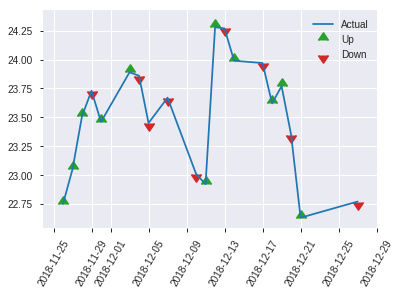


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18651907964383221
RMSE: 0.43187854732995506
LogLoss: 0.5568617435695489
Mean Per-Class Error: 0.2485836627140975
AUC: 0.7940711462450593
pr_auc: 0.7332879321245602
Gini: 0.5881422924901185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4146454334259033: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   53   0.4015   (53.0/132.0)
1      11   104  0.0957   (11.0/115.0)
Total  90   157  0.2591   (64.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414645     0.764706  156
max f2                       0.395214     0.846774  159
max f0point5                 0.534228     0.726795  113
max accuracy                 0.534228     0.744939  113
max precision                0.854898     1         0
max recall                   0.11223      1         244
max specificity              0.854898     1         0
max absolute_mcc             0.414645     0.521181  156
max min_per_class_accuracy   0.522685     0.730435  117
max mean_per_class_accuracy  0.414645     0.751416  156

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.841361           2.14783   2.14783            1                0.850704  1                           0.850704            0.026087        0.026087                   114.783   114.783
    2        0.0202429                   0.814611           1.07391   1.71826            0.5              0.830826  0.8                         0.842753            0.00869565      0.0347826                  7.3913    71.8261
    3        0.0323887                   0.809614           2.14783   1.87935            1                0.812826  0.875                       0.83153             0.026087        0.0608696                  114.783   87.9348
    4        0.0404858                   0.80548            2.14783   1.93304            1                0.806481  0.9                         0.826521            0.0173913       0.0782609                  114.783   93.3043
    5        0.0526316                   0.795361           1.43188   1.81739            0.666667         0.801097  0.846154                    0.820654            0.0173913       0.0956522                  43.1884   81.7391
    6        0.101215                    0.776014           1.43188   1.63235            0.666667         0.786066  0.76                        0.804051            0.0695652       0.165217                   43.1884   63.2348
    7        0.149798                    0.747515           1.96884   1.74148            0.916667         0.765628  0.810811                    0.79159             0.0956522       0.26087                    96.8841   74.1481
    8        0.202429                    0.708873           1.81739   1.76122            0.846154         0.727318  0.82                        0.774879            0.0956522       0.356522                   81.7391   76.1217
    9        0.299595                    0.64673            1.34239   1.62538            0.625            0.683538  0.756757                    0.745255            0.130435        0.486957                   34.2391   62.5382
    10       0.40081                     0.583027           1.37461   1.56206            0.64             0.61647   0.727273                    0.712733            0.13913         0.626087                   37.4609   56.2055
    11       0.502024                    0.499768           1.11687   1.4723             0.52             0.5411    0.685484                    0.67813             0.113043        0.73913                    11.687    47.23
    12       0.59919                     0.447462           0.98442   1.39318            0.458333         0.477035  0.648649                    0.64552             0.0956522       0.834783                   -1.55797  39.3184
    13       0.700405                    0.362344           0.773217  1.30359            0.36             0.398213  0.606936                    0.609782            0.0782609       0.913043                   -22.6783  30.3594
    14       0.797571                    0.278008           0.357971  1.18839            0.166667         0.309672  0.553299                    0.57322             0.0347826       0.947826                   -64.2029  18.8391
    15       0.898785                    0.208006           0.257739  1.08359            0.12             0.247139  0.504505                    0.536499            0.026087        0.973913                   -74.2261  8.35879
    16       1                           0.0938039          0.257739  1                  0.12             0.160475  0.465587                    0.49844            

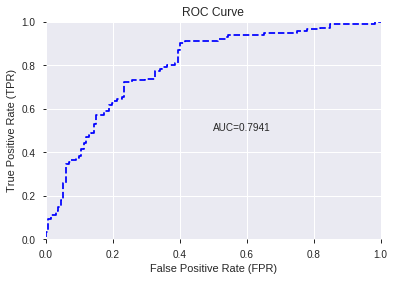

This function is available for GLM models only


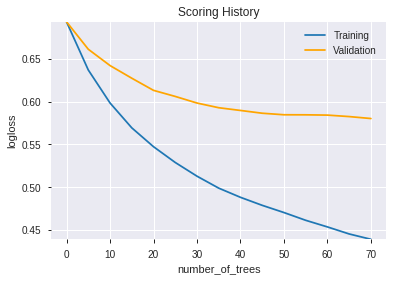

--2019-08-26 13:53:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


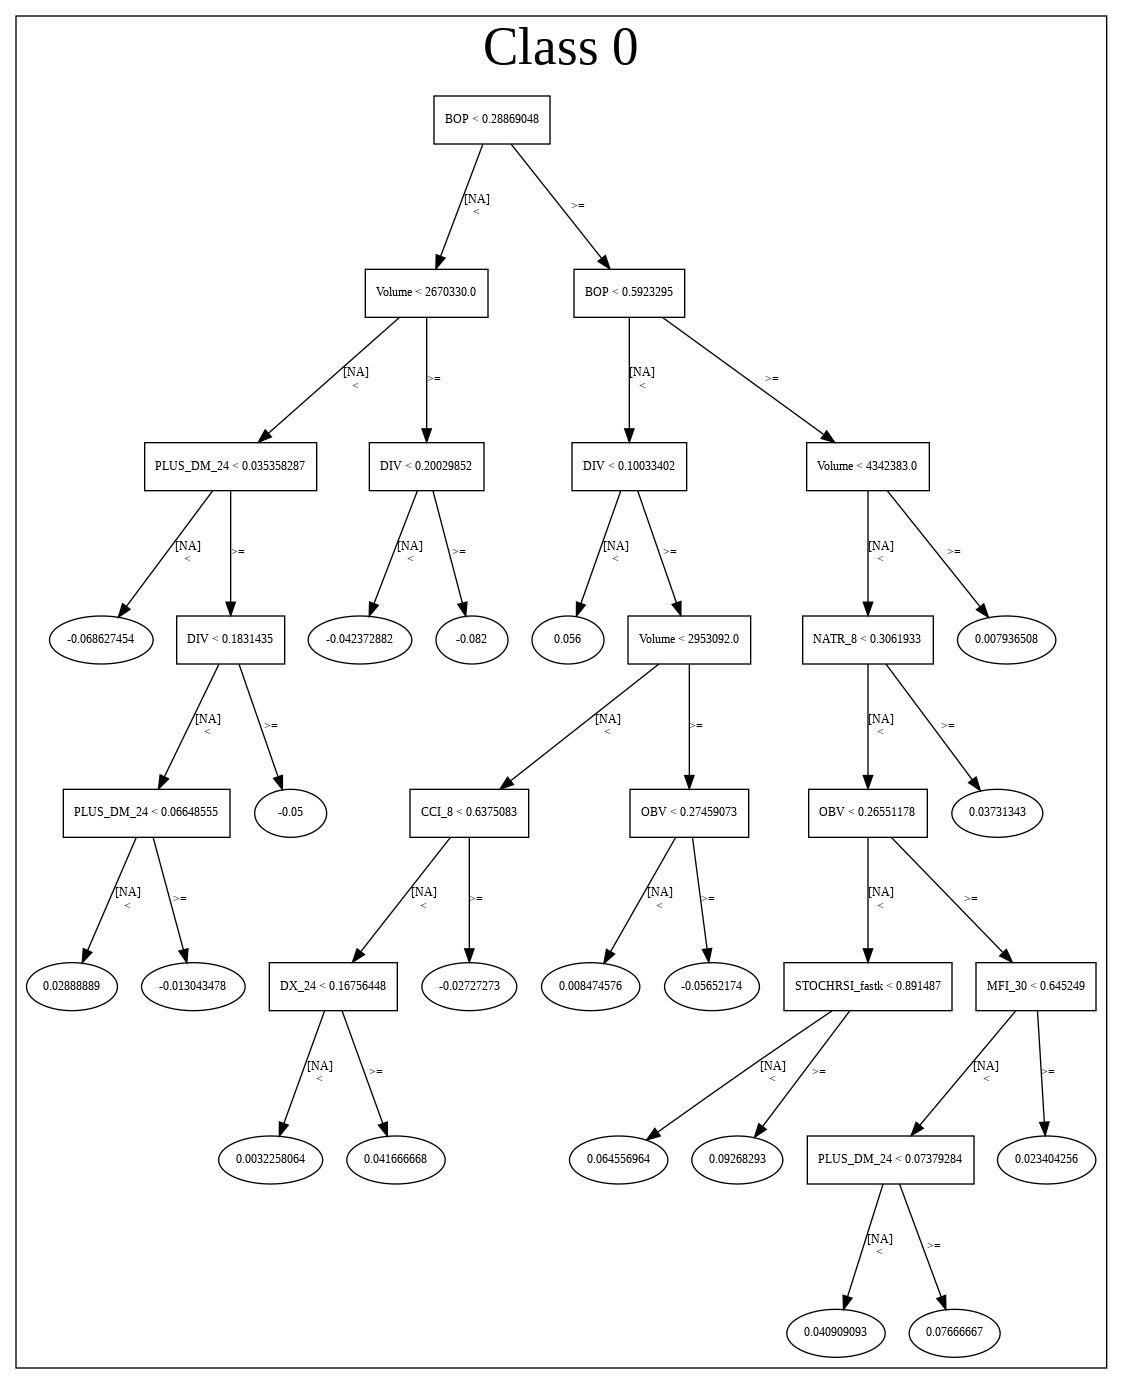

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190826_135331',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190826_135331',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_ba53',
   'type

['BOP',
 'DIV',
 'Volume',
 'STOCHRSI_fastk',
 'CCI_8',
 'OBV',
 'STOCHF_fastk',
 'PLUS_DM_24',
 'SUB',
 'WILLR_20',
 'NATR_8',
 'MFI_30',
 'ADXR_14',
 'DX_30',
 'TRANGE',
 'NATR_24',
 'WILLR_24',
 'BETA_8',
 'NATR_14',
 'DX_24',
 'CDLLONGLINE',
 'AROONOSC_8',
 'CCI_12',
 'DX_8',
 'ROC_20',
 'SIN',
 'month',
 'CMO_8',
 'AROONOSC_14',
 'WILLR_14',
 'day',
 'ULTOSC',
 'WILLR_8',
 'RSI_14',
 'AROONOSC_12',
 'AROONOSC_20',
 'WILLR_12',
 'aroonup_12',
 'DX_20',
 'CMO_12',
 'dayofweek',
 'DX_14',
 'RSI_8',
 'quarter',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_135405_model_1  0.485639  17.305483                   0.5  0.731035  0.534412

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.009331           1.000000    0.031331
1                 CDLLONGLINE             0.006477           0.694177    0.021750
2              STOCHRSI_fastk             0.006102           0.653891    0.020487
3                STOCHF_fastk             0.006027           0.645886    0.020237
4          CDLCLOSINGMARUBOZU             0.005247           0.562282    0.017617
...                       ...                  ...                ...         ...
1035  BBANDS_upperband_24_6_5             0.000000           0.000000    0.000000
1036                   WMA_30             0.000000           0.000000    0.000000
1037  BBANDS_lowerband_30_2_2             0.000000           0.000000    0.000000
1038  BBANDS_lowerband_30_2_3             0.000000           0.000000    0.000000
1039  BBANDS_lowerband_30_5_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

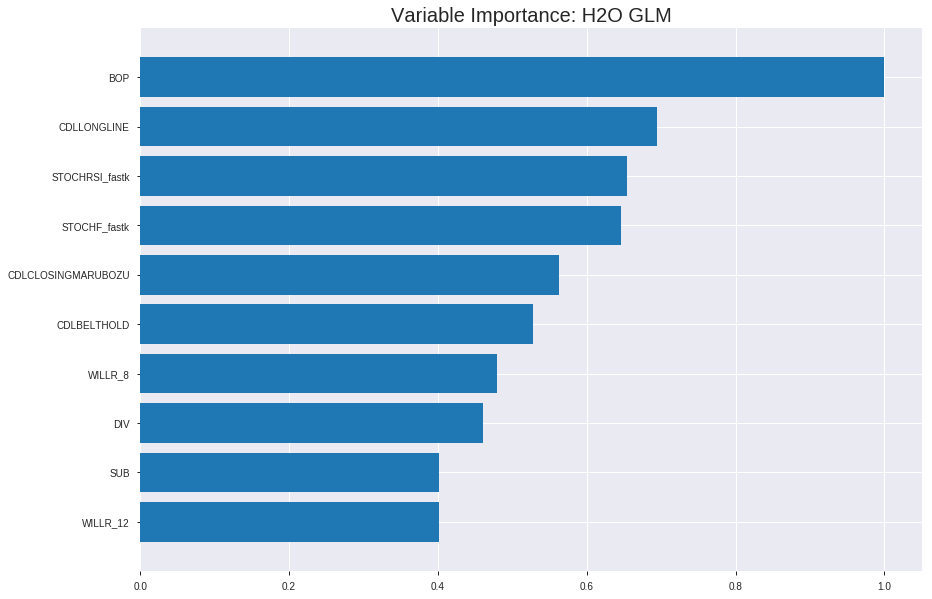

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_135405_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24058616107051062
RMSE: 0.4904958318584477
LogLoss: 0.6741668926659502
Null degrees of freedom: 1721
Residual degrees of freedom: 714
Null deviance: 2370.782545663055
Residual deviance: 2321.8307783415326
AIC: 4337.830778341533
AUC: 0.6799241418289038
pr_auc: 0.7121998542640452
Gini: 0.35984828365780763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5220058495149036: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      180  597   0.7683   (597.0/777.0)
1      61   884   0.0646   (61.0/945.0)
Total  241  1481  0.3821   (658.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522006     0.728772  305
max f2                       0.483787     0.860215  384
max f0point5                 0.54983      0.666065  185
max accuracy                 0.537335     0.634146  244
max precision                0.606756     1         0
max recall                   0.475301     1         391
max specificity              0.606756     1         0
max absolute_mcc             0.552814     0.262557  172
max min_per_class_accuracy   0.549129     0.628571  188
max mean_per_class_accuracy  0.552814     0.631532  172

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.594111           1.72099   1.72099            0.944444         0.597572  0.944444                    0.597572            0.0179894       0.0179894                  72.0988   72.0988
    2        0.0203252                   0.589631           1.82222   1.77016            1                0.591658  0.971429                    0.594699            0.0179894       0.0359788                  82.2222   77.0159
    3        0.0301974                   0.587491           1.39346   1.64701            0.764706         0.588361  0.903846                    0.592627            0.0137566       0.0497354                  39.3464   64.7009
    4        0.0400697                   0.58542            1.28627   1.55813            0.705882         0.58657   0.855072                    0.591135            0.0126984       0.0624339                  28.6275   55.8132
    5        0.0505226                   0.584413           1.21481   1.4871             0.666667         0.584875  0.816092                    0.58984             0.0126984       0.0751323                  21.4815   48.7101
    6        0.100465                    0.579172           1.4832    1.48516            0.813953         0.581485  0.815029                    0.585687            0.0740741       0.149206                   48.3204   48.5164
    7        0.150407                    0.574806           1.37726   1.44934            0.755814         0.576951  0.795367                    0.582786            0.0687831       0.217989                   37.7261   44.9335
    8        0.200348                    0.57107            1.20775   1.38911            0.662791         0.572913  0.762319                    0.580325            0.0603175       0.278307                   20.7752   38.9114
    9        0.300232                    0.56361            1.18656   1.32173            0.651163         0.567243  0.725338                    0.575973            0.118519        0.396825                   18.6563   32.1728
    10       0.400116                    0.556783           1.123     1.27212            0.616279         0.560395  0.698113                    0.572084            0.112169        0.508995                   12.2997   27.2117
    11       0.5                         0.549966           1.07003   1.23175            0.587209         0.553551  0.675958                    0.568382            0.106878        0.615873                   7.00258   23.1746
    12       0.599884                    0.543209           0.942894  1.18365            0.517442         0.546482  0.649564                    0.564735            0.0941799       0.710053                   -5.71059  18.3651
    13       0.699768                    0.536698           0.9323    1.14777            0.511628         0.539875  0.629876                    0.561187            0.0931217       0.803175                   -6.77003  14.7773
    14       0.799652                    0.528911           0.815762  1.1063             0.447674         0.532944  0.607117                    0.557659            0.0814815       0.884656                   -18.4238  10.6302
    15       0.899535                    0.516379           0.646253  1.05522            0.354651         0.523211  0.579083                    0.553834            0.0645503       0.949206                   -35.3747  5.52184
    16       1                           0.449123           0.505588  1                  0.277457         0.503535  0.54878                     0.54878          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2574000455855839
RMSE: 0.5073460806841656
LogLoss: 0.8285029832801818
Null degrees of freedom: 491
Residual degrees of freedom: -516
Null deviance: 676.5834633095117
Residual deviance: 815.246935547699
AIC: 2831.2469355476987
AUC: 0.6292780748663102
pr_auc: 0.6230566659738134
Gini: 0.2585561497326203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5053335685095188: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      30   190  0.8636   (190.0/220.0)
1      8    264  0.0294   (8.0/272.0)
Total  38   454  0.4024   (198.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505334     0.727273  362
max f2                       0.464365     0.86185   397
max f0point5                 0.538333     0.66386   246
max accuracy                 0.538333     0.634146  246
max precision                0.999994     0.75      0
max recall                   0.464365     1         397
max specificity              0.999994     0.995455  0
max absolute_mcc             0.538333     0.249627  246
max min_per_class_accuracy   0.546193     0.609091  199
max mean_per_class_accuracy  0.538333     0.62002   246

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 58.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.999959           1.44706   1.44706            0.8              0.999989  0.8                         0.999989            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.998528           0.723529  1.08529            0.4              0.999753  0.6                         0.999871            0.00735294      0.0220588                  -27.6471  8.52941
    3        0.0304878                   0.997072           0.361765  0.844118           0.2              0.997813  0.466667                    0.999185            0.00367647      0.0257353                  -63.8235  -15.5882
    4        0.0406504                   0.989536           1.44706   0.994853           0.8              0.994254  0.55                        0.997952            0.0147059       0.0404412                  44.7059   -0.514706
    5        0.050813                    0.980214           0.723529  0.940588           0.4              0.984965  0.52                        0.995355            0.00735294      0.0477941                  -27.6471  -5.94118
    6        0.101626                    0.600103           1.08529   1.01294            0.6              0.844359  0.56                        0.919857            0.0551471       0.102941                   8.52941   1.29412
    7        0.150407                    0.578003           1.50735   1.17329            0.833333         0.586543  0.648649                    0.811755            0.0735294       0.176471                   50.7353   17.3291
    8        0.20122                     0.571133           1.44706   1.24242            0.8              0.57355   0.686869                    0.751602            0.0735294       0.25                       44.7059   24.2424
    9        0.300813                    0.562735           1.14436   1.20996            0.632653         0.567071  0.668919                    0.690508            0.113971        0.363971                   14.4358   20.9956
    10       0.400407                    0.554405           1.10744   1.18446            0.612245         0.558793  0.654822                    0.657746            0.110294        0.474265                   10.7443   18.4458
    11       0.5                         0.5472             1.2551    1.19853            0.693878         0.550782  0.662602                    0.63644             0.125           0.599265                   25.5102   19.8529
    12       0.599593                    0.541342           0.922869  1.15274            0.510204         0.544436  0.637288                    0.621158            0.0919118       0.691176                   -7.71309  15.2742
    13       0.699187                    0.533727           0.922869  1.12               0.510204         0.537764  0.619186                    0.609279            0.0919118       0.783088                   -7.71309  11.9998
    14       0.79878                     0.523531           0.738295  1.07241            0.408163         0.528204  0.592875                    0.599171            0.0735294       0.856618                   -26.1705  7.24068
    15       0.898374                    0.51035            0.885954  1.05174            0.489796         0.517631  0.581448                    0.590131            0.0882353       0.944853                   -11.4046  5.17368
    16       1                           0.454395           0.542647  1                  0.3              0.493504  0.552846                    0.580311     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 13:54:09  0.000 sec   2            22        1008          1.34833           1.65701
    2019-08-26 13:54:11  1.963 sec   4            16        1020          1.3402            1.79805
    2019-08-26 13:54:13  3.912 sec   6            12        1035          1.33021           1.99614
    2019-08-26 13:54:15  5.960 sec   8            8.4       1039          1.3181            2.28736
    2019-08-26 13:54:17  7.879 sec   10           6.1       1040          1.30376           5.35879

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.46558704453441296)

('F1', 0.6353591160220994)

('auc', 0.4856389986824769)

('logloss', 17.305482534242586)

('mean_per_class_error', 0.5)

('rmse', 0.7310350438495141)

('mse', 0.5344122353360611)

glm prediction progress: |████████████████████████████████████████████████| 100%


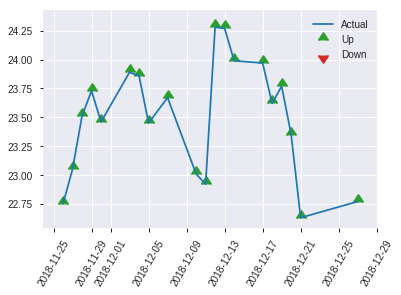


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5344122353360611
RMSE: 0.7310350438495141
LogLoss: 17.305482534242586
Null degrees of freedom: 246
Residual degrees of freedom: -761
Null deviance: 348.1046065632917
Residual deviance: 155451.49781748623
AIC: 157467.49781748623
AUC: 0.4856389986824769
pr_auc: 0.04402940447993654
Gini: -0.028722002635046207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9992636390926819: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    115  0        (0.0/115.0)
Total  0    247  0.5344   (132.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.999264     0.635359   16
max f2                       0.999264     0.813296   16
max f0point5                 0.999264     0.521306   16
max accuracy                 0.999984     0.465587   14
max precision                0.999264     0.465587   16
max recall                   0.999264     1          16
max specificity              1            0.0681818  0
max absolute_mcc             1            0.0965314  6
max min_per_class_accuracy   1            0.0681818  0
max mean_per_class_accuracy  0.999264     0.5        16

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.797571                    1                  0.959435  0.959435           0.446701         1         0.446701                    1                   0.765217        0.765217                   -4.0565  -4.0565
    2        0.797571                    1                  0         0.959435           0                0         0.446701                    1                   0               0.765217                   -100     -4.0565
    3        0.898785                    1                  1.11687   0.977164           0.52             1         0.454955                    1                   0.113043        0.878261                   11.687   -2.28359
    4        1                           0.999264           1.20278   1                  0.56             0.999966  0.465587                    0.999997            0.121739        1                          20.2783  0

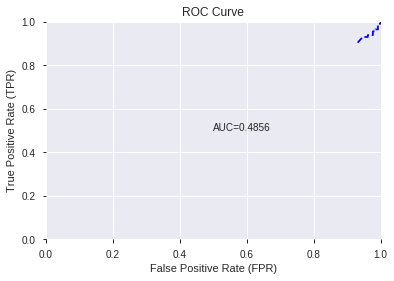

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


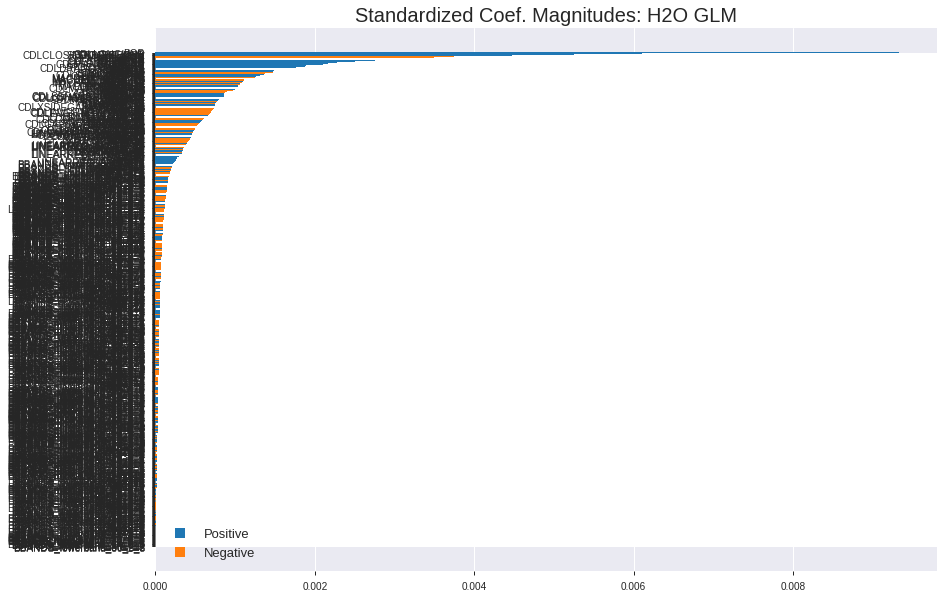

'log_likelihood'
--2019-08-26 13:54:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


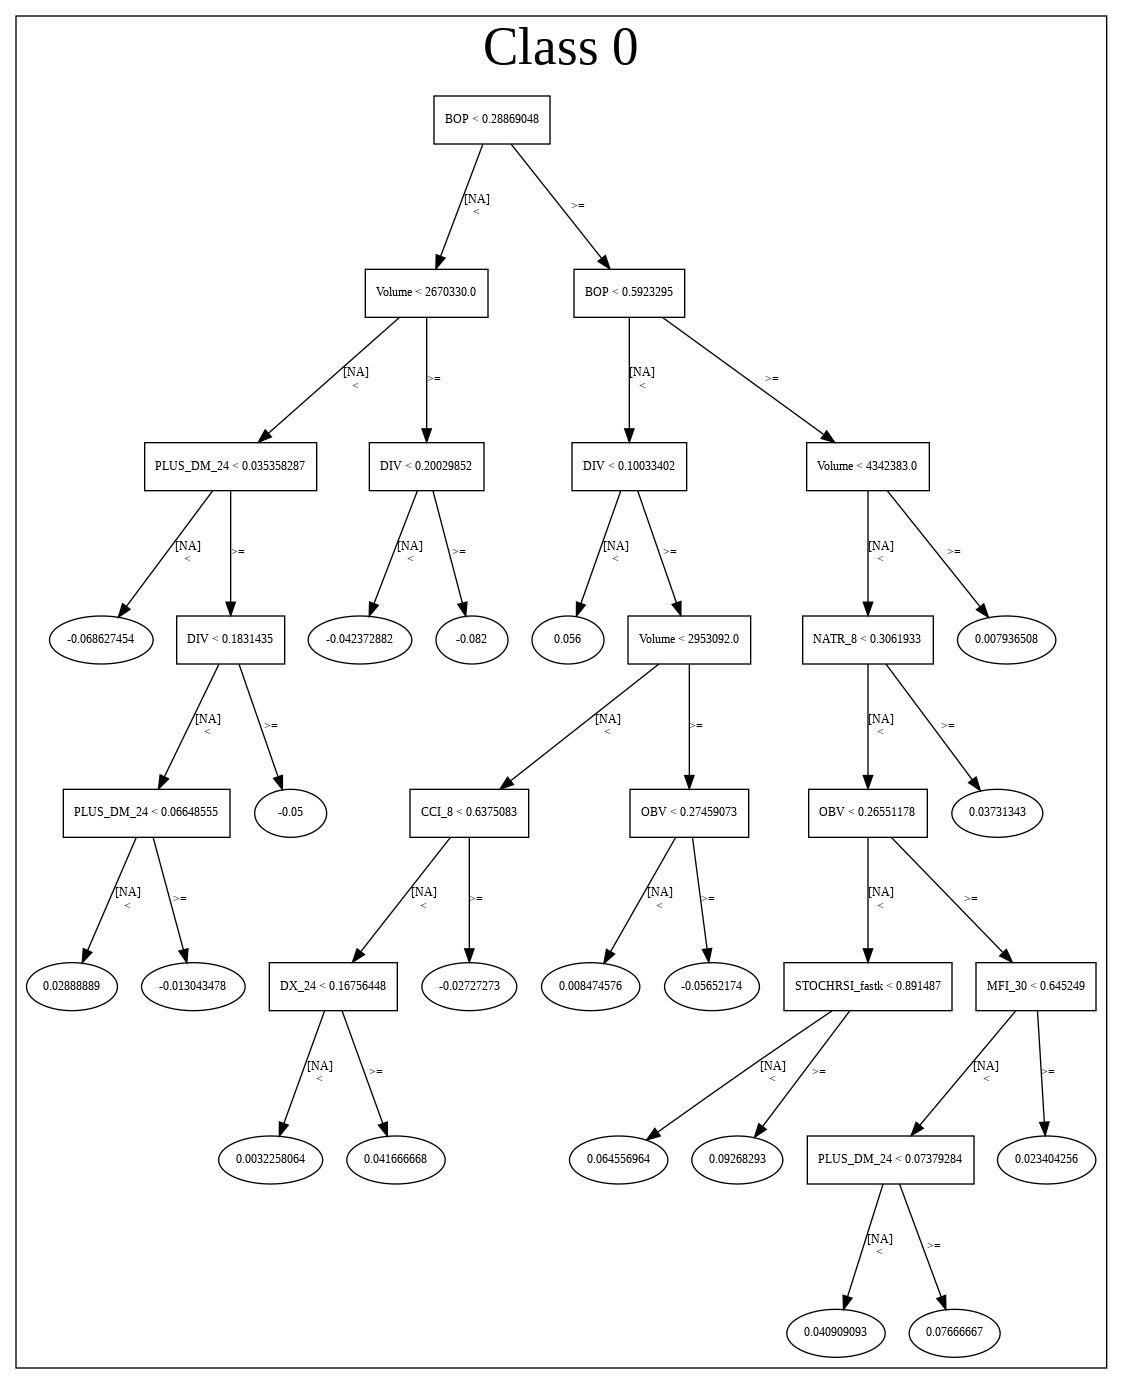

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_135405_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_135405_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

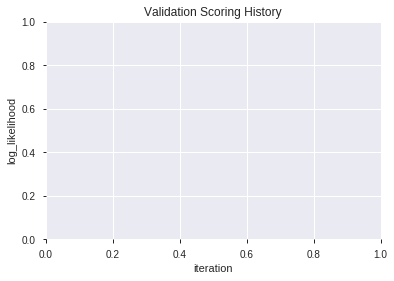

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_135444_model_4  0.789921  0.584059              0.258399  0.445525  0.198492
1  XGBoost_grid_1_AutoML_20190826_135444_model_2  0.777668  0.609358              0.266107  0.457929  0.209699
2  XGBoost_grid_1_AutoML_20190826_135444_model_7  0.767721  0.597936              0.322233  0.453723  0.205865
3               XGBoost_1_AutoML_20190826_135444  0.766337  0.596396              0.308202  0.452020  0.204322
4               XGBoost_2_AutoML_20190826_135444  0.766140  0.593174              0.292062  0.450681  0.203113
5               XGBoost_3_AutoML_20190826_135444  0.766074  0.602735              0.289954  0.455139  0.207152
6  XGBoost_grid_1_AutoML_20190826_135444_model_6  0.760145  0.599439              0.302866  0.453310  0.205490
7  XGBoost_grid_1_AutoML_20190826_135444_model_1  0.760145  0.593364              0.317885  0.450475  0.202928
8  XGBoost_grid_1_AutoML_20190826_135444_model_3  0.755665  0.605440              0.297958  0.456449  0.208345
9  XGBoost_grid_1_AutoML_20190826_135444_model_5  0.704809  0.626473              0.376680  0.467156  0.218234

variable  relative_importance  scaled_importance  percentage
0                        BOP          2446.211426           1.000000    0.400141
1                        DIV           570.819885           0.233349    0.093372
2               STOCHF_fastk           201.622421           0.082422    0.032981
3                     Volume           148.977615           0.060901    0.024369
4                        SUB           130.502884           0.053349    0.021347
..                       ...                  ...                ...         ...
136                   CMO_30             4.295338           0.001756    0.000703
137                 WILLR_14             4.241877           0.001734    0.000694
138                 WILLR_30             3.596402           0.001470    0.000588
139  BBANDS_lowerband_12_6_4             3.090078           0.001263    0.000505
140  BBANDS_lowerband_20_6_4             2.033564           0.000831    0.000333

[141 rows x 4 columns]

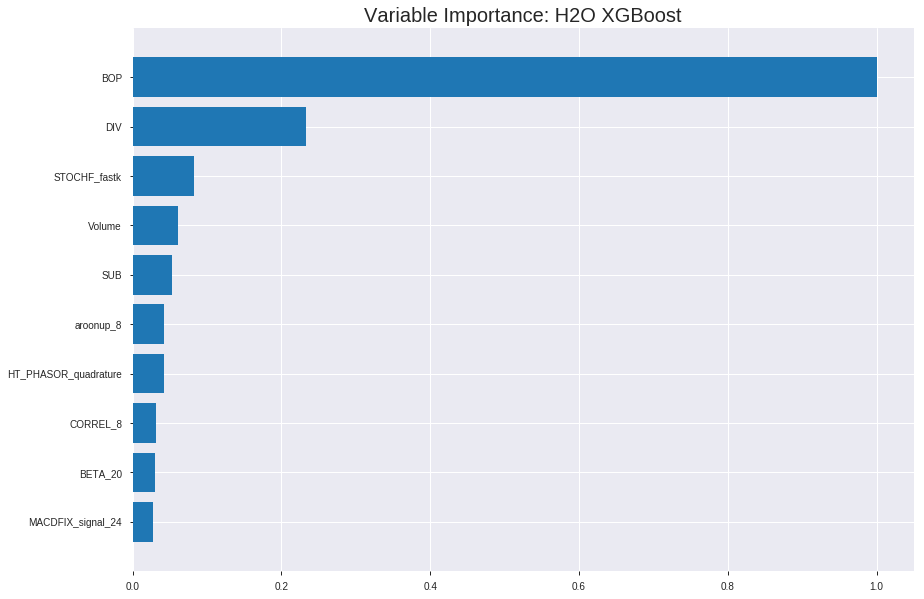

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_135444_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15806159713574205
RMSE: 0.39756961294311977
LogLoss: 0.48879598792712686
Mean Per-Class Error: 0.22182182182182175
AUC: 0.8602548126357651
pr_auc: 0.8786203546273791
Gini: 0.7205096252715302
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49453161656856537: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      540  237   0.305    (237.0/777.0)
1      131  814   0.1386   (131.0/945.0)
Total  671  1051  0.2137   (368.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494532     0.815631  216
max f2                       0.282677     0.889252  317
max f0point5                 0.604899     0.807809  162
max accuracy                 0.494532     0.786295  216
max precision                0.896284     1         0
max recall                   0.156748     1         371
max specificity              0.896284     1         0
max absolute_mcc             0.494532     0.567697  216
max min_per_class_accuracy   0.571036     0.772487  179
max mean_per_class_accuracy  0.494532     0.778178  216

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.867464           1.82222    1.82222            1                0.875735  1                           0.875735            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.855699           1.82222    1.82222            1                0.862432  1                           0.869274            0.0179894       0.037037                   82.2222   82.2222
    3        0.0301974                   0.850909           1.82222    1.82222            1                0.853421  1                           0.864091            0.0179894       0.0550265                  82.2222   82.2222
    4        0.0400697                   0.845773           1.82222    1.82222            1                0.848469  1                           0.860242            0.0179894       0.0730159                  82.2222   82.2222
    5        0.0505226                   0.841692           1.82222    1.82222            1                0.84354   1                           0.856786            0.0190476       0.0920635                  82.2222   82.2222
    6        0.100465                    0.817087           1.73747    1.78009            0.953488         0.828432  0.976879                    0.842691            0.0867725       0.178836                   73.7468   78.009
    7        0.150407                    0.798755           1.65271    1.73779            0.906977         0.808253  0.953668                    0.831256            0.0825397       0.261376                   65.2713   73.7795
    8        0.200348                    0.773593           1.6739     1.72187            0.918605         0.786252  0.944928                    0.820038            0.0835979       0.344974                   67.3902   72.1868
    9        0.300232                    0.727455           1.4832     1.64247            0.813953         0.751225  0.901354                    0.797144            0.148148        0.493122                   48.3204   64.2467
    10       0.400116                    0.664912           1.32429    1.56304            0.726744         0.696047  0.857765                    0.771907            0.132275        0.625397                   32.4289   56.3038
    11       0.5                         0.592493           1.22894    1.4963             0.674419         0.628188  0.821138                    0.743196            0.122751        0.748148                   22.8941   49.6296
    12       0.599884                    0.507378           1.00646    1.41474            0.552326         0.549792  0.776379                    0.710993            0.100529        0.848677                   0.645995  41.4736
    13       0.699768                    0.408886           0.68863    1.31109            0.377907         0.45519   0.719502                    0.67448             0.0687831       0.91746                    -31.137   31.1093
    14       0.799652                    0.311192           0.487339   1.2082             0.267442         0.356572  0.663036                    0.634771            0.0486772       0.966138                   -51.2661  20.8198
    15       0.899535                    0.199853           0.254264   1.10227            0.139535         0.254558  0.604906                    0.592552            0.0253968       0.991534                   -74.5736  10.2274
    16       1                           0.0718691          0.0842646  1                  0.0462428        0.145578  0.54878                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20646114184445954
RMSE: 0.45437995317185764
LogLoss: 0.5992551119353595
Mean Per-Class Error: 0.31209893048128345
AUC: 0.7434826203208555
pr_auc: 0.7761009305894981
Gini: 0.4869652406417111
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049759149551392: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  120  0.5455   (120.0/220.0)
1      35   237  0.1287   (35.0/272.0)
Total  135  357  0.315    (155.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504976     0.753577  280
max f2                       0.362605     0.86785   346
max f0point5                 0.626009     0.721884  199
max accuracy                 0.581559     0.695122  231
max precision                0.859669     1         0
max recall                   0.138477     1         393
max specificity              0.859669     1         0
max absolute_mcc             0.581559     0.378176  231
max min_per_class_accuracy   0.630547     0.677273  195
max mean_per_class_accuracy  0.626009     0.687901  199

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 59.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.844242           1.80882   1.80882            1                0.850494  1                           0.850494            0.0183824       0.0183824                  80.8824   80.8824
    2        0.0203252                   0.8346             1.80882   1.80882            1                0.838982  1                           0.844738            0.0183824       0.0367647                  80.8824   80.8824
    3        0.0304878                   0.818621           1.44706   1.68824            0.8              0.824762  0.933333                    0.838079            0.0147059       0.0514706                  44.7059   68.8235
    4        0.0406504                   0.814961           1.80882   1.71838            1                0.817378  0.95                        0.832904            0.0183824       0.0698529                  80.8824   71.8382
    5        0.050813                    0.802094           1.80882   1.73647            1                0.808313  0.96                        0.827986            0.0183824       0.0882353                  80.8824   73.6471
    6        0.101626                    0.781096           1.59176   1.66412            0.88             0.79002   0.92                        0.809003            0.0808824       0.169118                   59.1765   66.4118
    7        0.150407                    0.76627            1.50735   1.61328            0.833333         0.773574  0.891892                    0.797512            0.0735294       0.242647                   50.7353   61.3275
    8        0.20122                     0.746623           1.23      1.51649            0.68             0.754873  0.838384                    0.786745            0.0625          0.305147                   23        51.6488
    9        0.300813                    0.717941           1.18127   1.4055             0.653061         0.73264   0.777027                    0.768832            0.117647        0.422794                   18.1273   40.5505
    10       0.400407                    0.67769            1.18127   1.34973            0.653061         0.696901  0.746193                    0.75094             0.117647        0.540441                   18.1273   34.9731
    11       0.5                         0.641998           1.14436   1.30882            0.632653         0.661028  0.723577                    0.733031            0.113971        0.654412                   14.4358   30.8824
    12       0.599593                    0.585893           1.07053   1.26924            0.591837         0.613656  0.701695                    0.713203            0.106618        0.761029                   7.05282   26.9242
    13       0.699187                    0.520488           0.812125  1.20413            0.44898          0.553635  0.665698                    0.690473            0.0808824       0.841912                   -18.7875  20.413
    14       0.79878                     0.448375           0.701381  1.14145            0.387755         0.487525  0.631043                    0.665169            0.0698529       0.911765                   -29.8619  14.1446
    15       0.898374                    0.33431            0.627551  1.08448            0.346939         0.401383  0.599548                    0.635926            0.0625          0.974265                   -37.2449  8.44756
    16       1                           0.104987           0.253235  1                  0.14             0.234754  0.552846                    0.595157          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:55:11  11.505 sec  0                  0.5              0.693147            0.5             0                  1                0.45122                          0.5                0.693147              0.5               0                    1                  0.447154
    2019-08-26 13:55:12  12.334 sec  5                  0.477172         0.648307            0.80342         0.821275           1.82222          0.268873                         0.486583           0.666573              0.731818          0.75194              1.80882            0.337398
    2019-08-26 13:55:12  12.657 sec  10                 0.456416         0.608185            0.814834        0.838647           1.82222          0.263066                         0.475412           0.644456              0.730431          0.762448             1.44706            0.357724
    2019-08-26 13:55:13  12.966 sec  15                 0.443128         0.582289            0.824067        0.845976           1.82222          0.252033                         0.467747           0.629068              0.741979          0.777384             1.80882            0.339431
    2019-08-26 13:55:13  13.276 sec  20                 0.432867         0.561972            0.829568        0.852402           1.82222          0.252613                         0.463025           0.619276              0.744786          0.779883             1.80882            0.343496
    2019-08-26 13:55:13  13.590 sec  25                 0.424609         0.545088            0.833778        0.855995           1.82222          0.243902                         0.45818            0.609389              0.754245          0.782649             1.80882            0.335366
    2019-08-26 13:55:13  13.905 sec  30                 0.419275         0.533805            0.836566        0.859462           1.82222          0.246225                         0.456665           0.605675              0.750017          0.782668             1.80882            0.335366
    2019-08-26 13:55:14  14.216 sec  35                 0.414166         0.523328            0.841747        0.860296           1.82222          0.235192                         0.455572           0.603026              0.748245          0.78159              1.80882            0.347561
    2019-08-26 13:55:14  14.524 sec  40                 0.410454         0.515497            0.84508         0.865475           1.82222          0.231707                         0.454646           0.600709              0.748521          0.785815             1.80882            0.337398
    2019-08-26 13:55:15  14.985 sec  45                 0.406896         0.507921            0.848687        0.868478           1.82222          0.224739                         0.453629           0.598255              0.750476          0.787046             1.80882            0.347561
    2019-08-26 13:55:15  15.402 sec  50                 0.403865         0.501728            0.852996        0.873141           1.82222          0.223577                         0.454642           0.600033              0.74751           0.782455             1.80882            0.323171
    2019-08-26 13:55:15  15.726 sec  55                 0.400396         0.49483             0.858243        0.878206           1.82222          0.218351                         0.454479           0.599475              0.745622          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      2446.21142578125       1.0                    0.40014105978487535
DIV                      570.8198852539062      0.2333485483870646     0.09337233545086229
STOCHF_fastk             201.62242126464844     0.08242232013950143    0.03298055453054838
Volume                   148.9776153564453      0.06090136518304673    0.024369136806690027
SUB                      130.5028839111328      0.053348979787981296   0.02134711731080473
---                      ---                    ---                    ---
CMO_30                   4.295337677001953      0.0017559143219315742  0.000702613417669141
WILLR_14                 4.24187707901001       0.001734059874916689   0.0006938685560795924
WILLR_30                 3.596402406692505      0.0014701927923273911  0.0005882845020099675
BBANDS_lowerband_12_6_4  3.090078353881836      0.001263209844134774   0.0005054621257627757
BBANDS_lowerband_20_6_4  2.0335638523101807     0.0008313115664811019  0.00033264189122317295


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7408906882591093)

('F1', 0.7518796992481204)

('auc', 0.7899209486166008)

('logloss', 0.5840586485717797)

('mean_per_class_error', 0.258399209486166)

('rmse', 0.4455246069145774)

('mse', 0.1984921753663887)

xgboost prediction progress: |████████████████████████████████████████████| 100%


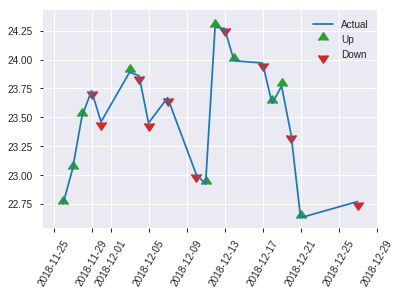


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1984921753663887
RMSE: 0.4455246069145774
LogLoss: 0.5840586485717797
Mean Per-Class Error: 0.258399209486166
AUC: 0.7899209486166008
pr_auc: 0.740694395608659
Gini: 0.5798418972332016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5045234560966492: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   51   0.3864   (51.0/132.0)
1      15   100  0.1304   (15.0/115.0)
Total  96   151  0.2672   (66.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504523     0.75188   150
max f2                       0.460493     0.826645  162
max f0point5                 0.60587      0.72744   106
max accuracy                 0.60587      0.740891  106
max precision                0.817318     1         0
max recall                   0.159365     1         240
max specificity              0.817318     1         0
max absolute_mcc             0.504523     0.49447   150
max min_per_class_accuracy   0.589626     0.721739  117
max mean_per_class_accuracy  0.504523     0.741601  150

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 53.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.798643           2.14783   2.14783            1                0.807213  1                           0.807213            0.026087        0.026087                   114.783   114.783
    2        0.0202429                   0.792714           1.07391   1.71826            0.5              0.794226  0.8                         0.802018            0.00869565      0.0347826                  7.3913    71.8261
    3        0.0323887                   0.78858            2.14783   1.87935            1                0.790728  0.875                       0.797784            0.026087        0.0608696                  114.783   87.9348
    4        0.0404858                   0.785302           2.14783   1.93304            1                0.787643  0.9                         0.795756            0.0173913       0.0782609                  114.783   93.3043
    5        0.0526316                   0.78186            2.14783   1.98261            1                0.783422  0.923077                    0.79291             0.026087        0.104348                   114.783   98.2609
    6        0.101215                    0.759381           1.61087   1.80417            0.75             0.77157   0.84                        0.782667            0.0782609       0.182609                   61.087    80.4174
    7        0.149798                    0.728474           1.61087   1.74148            0.75             0.745466  0.810811                    0.770602            0.0782609       0.26087                    61.087    74.1481
    8        0.202429                    0.713854           1.98261   1.80417            0.923077         0.7197    0.84                        0.757367            0.104348        0.365217                   98.2609   80.4174
    9        0.299595                    0.682878           1.2529    1.62538            0.583333         0.697042  0.756757                    0.737802            0.121739        0.486957                   25.2899   62.5382
    10       0.40081                     0.624295           1.37461   1.56206            0.64             0.652786  0.727273                    0.716333            0.13913         0.626087                   37.4609   56.2055
    11       0.502024                    0.571338           1.20278   1.48962            0.56             0.597882  0.693548                    0.692452            0.121739        0.747826                   20.2783   48.9621
    12       0.59919                     0.511052           1.07391   1.42221            0.5              0.549589  0.662162                    0.669285            0.104348        0.852174                   7.3913    42.2209
    13       0.700405                    0.435052           0.515478  1.29118            0.24             0.473427  0.601156                    0.640982            0.0521739       0.904348                   -48.4522  29.1179
    14       0.797571                    0.354417           0.268478  1.16659            0.125            0.393777  0.543147                    0.610866            0.026087        0.930435                   -73.1522  16.6586
    15       0.898785                    0.269071           0.343652  1.07391            0.16             0.313199  0.5                         0.577345            0.0347826       0.965217                   -65.6348  7.3913
    16       1                           0.122686           0.343652  1                  0.16             0.196725  0.465587                    0.53882           

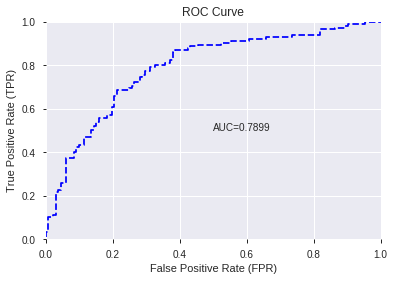

This function is available for GLM models only


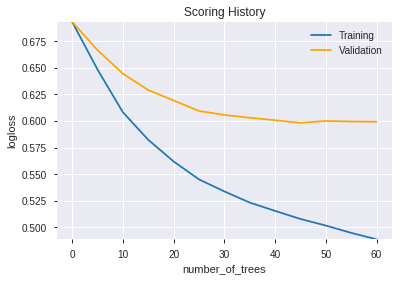

--2019-08-26 13:55:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

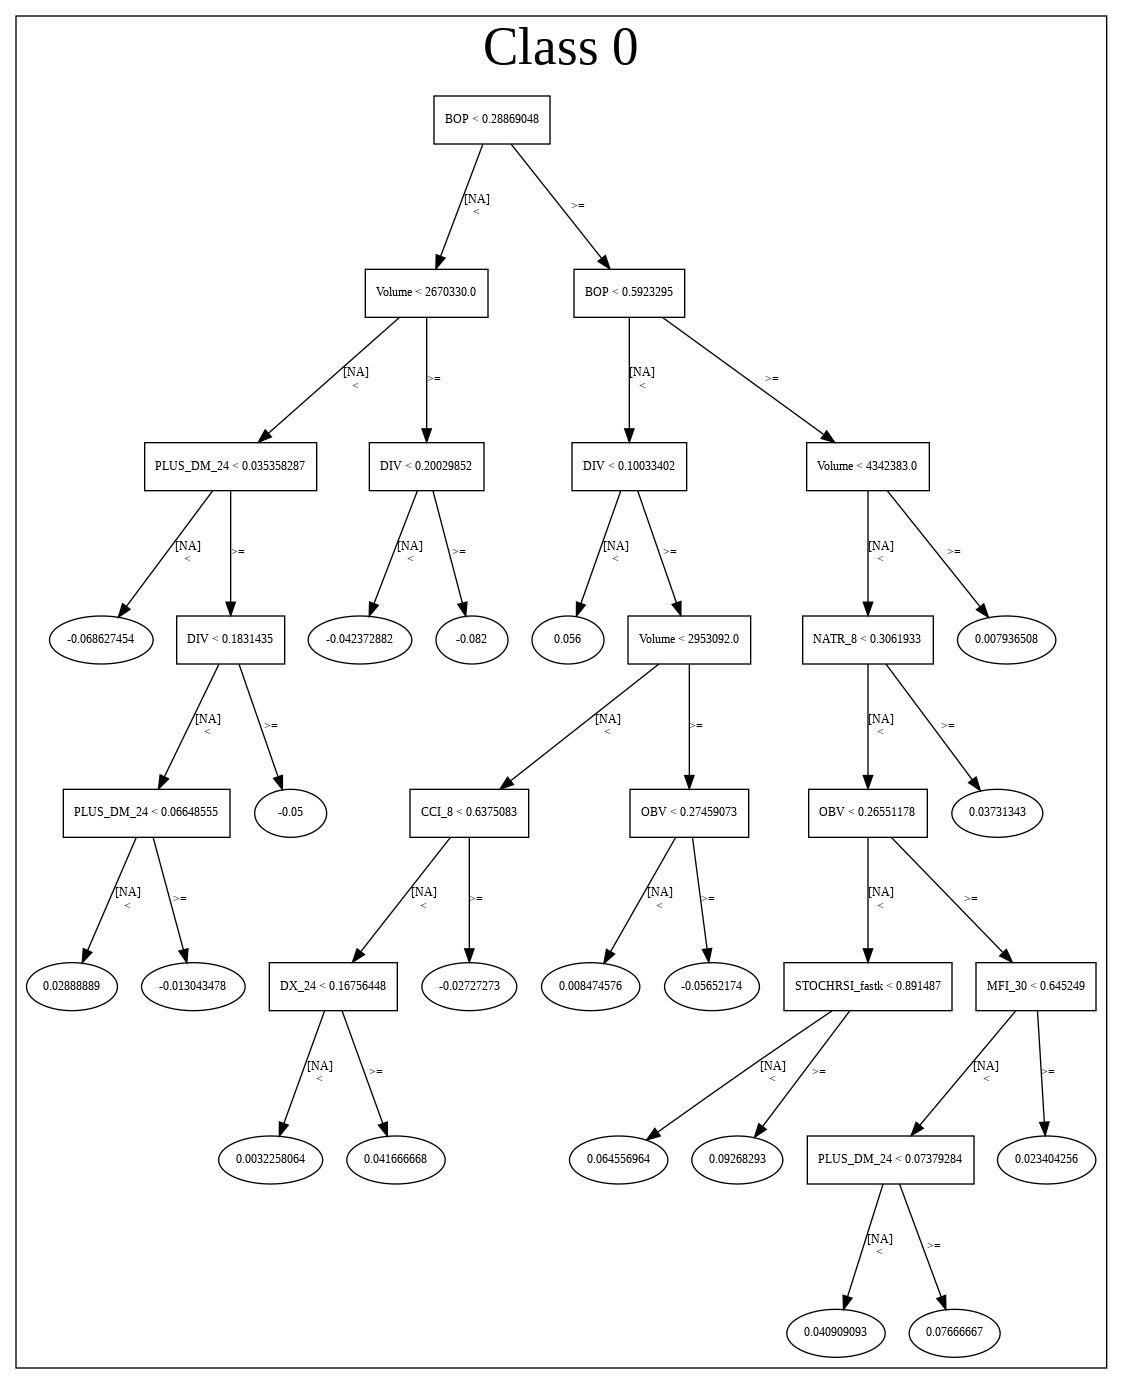

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_135444_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_135444_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_135545_model_8  0.761462  0.601927              0.288966  0.451299  0.203671
1  DeepLearning_grid_1_AutoML_20190826_135545_model_7  0.751910  0.660278              0.285870  0.477545  0.228049
2  DeepLearning_grid_1_AutoML_20190826_135545_model_9  0.748880  0.606234              0.368116  0.454913  0.206946
3  DeepLearning_grid_1_AutoML_20190826_135545_model_6  0.745125  0.612030              0.339065  0.459819  0.211433
4  DeepLearning_grid_1_AutoML_20190826_135545_model_5  0.738274  0.618734              0.357872  0.460144  0.211732
5  DeepLearning_grid_1_AutoML_20190826_135545_model_4  0.722332  0.984380              0.346772  0.540520  0.292162
6  DeepLearning_grid_1_AutoML_20190826_135545_model_2  0.699473  3.599295              0.342292  0.660941  0.436844
7  DeepLearning_grid_1_AutoML_20190826_135545_model_1  0.686364  5.425055              0.375132  0.678226  0.459990
8  DeepLearning_grid_1_AutoML_20190826_135545_model_3  0.684651  2.842261              0.387055  0.638925  0.408226
9               DeepLearning_1_AutoML_20190826_135545  0.636034  0.981166              0.373155  0.542514  0.294322

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.045615
1                  DIV             0.653505           0.653505    0.029809
2          CDLLONGLINE             0.562980           0.562980    0.025680
3   CDLCLOSINGMARUBOZU             0.529015           0.529015    0.024131
4        CDLHANGINGMAN             0.503504           0.503504    0.022967
5     CDLDRAGONFLYDOJI             0.474842           0.474842    0.021660
6                  SIN             0.473822           0.473822    0.021613
7           AROONOSC_8             0.466210           0.466210    0.021266
8                  day             0.462892           0.462892    0.021115
9                  OBV             0.456072           0.456072    0.020804
10           dayofweek             0.454397           0.454397    0.020727
11              Volume             0.454207           0.454207    0.020718
12              MFI_30             0.451886           0.451886    0.020613
13                 SUB             0.447645           0.447645    0.020419
14               month             0.444186           0.444186    0.020261
15      STOCHRSI_fastk             0.442148           0.442148    0.020168
16             CDLDOJI             0.439608           0.439608    0.020053
17             ADXR_14             0.437622           0.437622    0.019962
18         AROONOSC_14             0.435394           0.435394    0.019860
19               DX_24             0.425881           0.425881    0.019426
20          PLUS_DM_24             0.420258           0.420258    0.019170
21               CCI_8             0.420170           0.420170    0.019166
22              TRANGE             0.418440           0.418440    0.019087
23                DX_8             0.413195           0.413195    0.018848
24            WILLR_14             0.411957           0.411957    0.018791
25               DX_30             0.411558           0.411558    0.018773
26              BETA_8             0.411342           0.411342    0.018763
27            WILLR_12             0.405630           0.405630    0.018503
28        STOCHF_fastk             0.405566           0.405566    0.018500
29              CCI_12             0.404892           0.404892    0.018469
30               DX_20             0.404711           0.404711    0.018461
31             WILLR_8             0.404327           0.404327    0.018443
32              ULTOSC             0.400824           0.400824    0.018283
33              NATR_8             0.400043           0.400043    0.018248
34              RSI_14             0.398816           0.398816    0.018192
35             quarter             0.398698           0.398698    0.018186
36             NATR_14             0.398426           0.398426    0.018174
37             NATR_24             0.396468           0.396468    0.018085
38         CDLBELTHOLD             0.395701           0.395701    0.018050
39         AROONOSC_12             0.395496           0.395496    0.018040
40               DX_14             0.395379           0.395379    0.018035
41              CMO_12             0.392182           0.392182    0.017889
42         AROONOSC_20             0.389893           0.389893    0.017785
43          aroonup_12             0.387803           0.387803    0.017689
44              ROC_20             0.387137           0.387137    0.017659
45            WILLR_24             0.379379           0.379379    0.017305
46               CMO_8             0.370456           0.370456    0.016898
47            WILLR_20             0.363035           0.363035    0.016560
48               RSI_8             0.362649           0.362649    0.016542
49   CDLSTALLEDPATTERN             0.362599           0.362599    0.016540

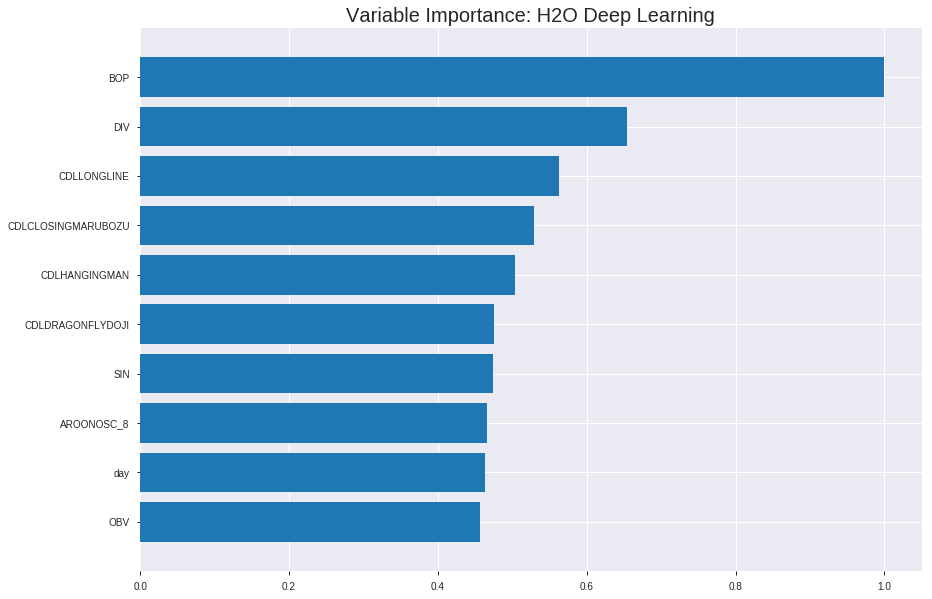

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_135545_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18355754024148477
RMSE: 0.42843615655250755
LogLoss: 0.5469617592071712
Mean Per-Class Error: 0.2694694694694695
AUC: 0.7971985591033209
pr_auc: 0.8030830773743792
Gini: 0.5943971182066419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42346045071478483: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      352  425   0.547    (425.0/777.0)
1      74   871   0.0783   (74.0/945.0)
Total  426  1296  0.2898   (499.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42346      0.777332  265
max f2                       0.303        0.875954  312
max f0point5                 0.594309     0.757061  186
max accuracy                 0.54844      0.734611  210
max precision                0.971574     1         0
max recall                   0.08078      1         385
max specificity              0.971574     1         0
max absolute_mcc             0.54844      0.461668  210
max min_per_class_accuracy   0.612329     0.720721  176
max mean_per_class_accuracy  0.594309     0.730531  186

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 59.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.946812           1.72099   1.72099            0.944444         0.953052  0.944444                    0.953052            0.0179894       0.0179894                  72.0988   72.0988
    2        0.0203252                   0.94213            1.60784   1.66603            0.882353         0.944354  0.914286                    0.948827            0.015873        0.0338624                  60.7843   66.6032
    3        0.0301974                   0.934872           1.60784   1.64701            0.882353         0.938125  0.903846                    0.945329            0.015873        0.0497354                  60.7843   64.7009
    4        0.0400697                   0.930073           1.39346   1.58454            0.764706         0.932946  0.869565                    0.942278            0.0137566       0.0634921                  39.3464   58.4541
    5        0.0505226                   0.922219           1.61975   1.59183            0.888889         0.92637   0.873563                    0.938986            0.0169312       0.0804233                  61.9753   59.1826
    6        0.100465                    0.884253           1.58915   1.59049            0.872093         0.902854  0.872832                    0.921024            0.0793651       0.159788                   58.9147   59.0495
    7        0.150407                    0.851719           1.56796   1.58301            0.860465         0.867297  0.868726                    0.903184            0.0783069       0.238095                   56.7959   58.3012
    8        0.200348                    0.828743           1.52558   1.5687             0.837209         0.841021  0.86087                     0.887689            0.0761905       0.314286                   52.5581   56.8696
    9        0.300232                    0.7573             1.41964   1.51911            0.77907          0.791581  0.833656                    0.855715            0.141799        0.456085                   41.9638   51.9106
    10       0.400116                    0.683424           1.28191   1.45989            0.703488         0.717054  0.801161                    0.8211              0.128042        0.584127                   28.1912   45.9894
    11       0.5                         0.624635           1.1124    1.39048            0.610465         0.651947  0.763066                    0.787309            0.111111        0.695238                   11.2403   39.0476
    12       0.599884                    0.559767           1.08062   1.33888            0.593023         0.590961  0.734753                    0.754616            0.107937        0.803175                   8.06202   33.8884
    13       0.699768                    0.477993           0.773385  1.25817            0.424419         0.524258  0.690456                    0.721735            0.0772487       0.880423                   -22.6615  25.8165
    14       0.799652                    0.365651           0.635659  1.18041            0.348837         0.425762  0.647785                    0.684765            0.0634921       0.943915                   -36.4341  18.0408
    15       0.899535                    0.222657           0.413178  1.09522            0.226744         0.297353  0.601033                    0.641747            0.0412698       0.985185                   -58.6822  9.52156
    16       1                           0.0127674          0.147463  1                  0.0809249        0.140441  0.54878                     0.591384         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20045791734446033
RMSE: 0.44772526994180295
LogLoss: 0.5842743341400799
Mean Per-Class Error: 0.29745989304812837
AUC: 0.7554645721925133
pr_auc: 0.7748191228651027
Gini: 0.5109291443850266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4361096386152266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   125  0.5682   (125.0/220.0)
1      31   241  0.114    (31.0/272.0)
Total  126  366  0.3171   (156.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43611      0.755486  286
max f2                       0.130969     0.872354  378
max f0point5                 0.577505     0.741379  179
max accuracy                 0.538098     0.703252  216
max precision                0.94404      1         0
max recall                   0.130969     1         378
max specificity              0.94404      1         0
max absolute_mcc             0.577505     0.404742  179
max min_per_class_accuracy   0.548807     0.690909  204
max mean_per_class_accuracy  0.577505     0.70254   179

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 53.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.92044            1.80882   1.80882            1                0.933429  1                           0.933429            0.0183824       0.0183824                  80.8824   80.8824
    2        0.0203252                   0.908298           1.80882   1.80882            1                0.915553  1                           0.924491            0.0183824       0.0367647                  80.8824   80.8824
    3        0.0304878                   0.8969             1.44706   1.68824            0.8              0.904259  0.933333                    0.917747            0.0147059       0.0514706                  44.7059   68.8235
    4        0.0406504                   0.887177           1.80882   1.71838            1                0.891366  0.95                        0.911152            0.0183824       0.0698529                  80.8824   71.8382
    5        0.050813                    0.870964           0.723529  1.51941            0.4              0.87788   0.84                        0.904497            0.00735294      0.0772059                  -27.6471  51.9412
    6        0.101626                    0.812133           1.59176   1.55559            0.88             0.841522  0.86                        0.87301             0.0808824       0.158088                   59.1765   55.5588
    7        0.150407                    0.754368           1.35662   1.49106            0.75             0.782235  0.824324                    0.843569            0.0661765       0.224265                   35.6618   49.1057
    8        0.20122                     0.70514            1.51941   1.49822            0.84             0.731583  0.828283                    0.81529             0.0772059       0.301471                   51.9412   49.8217
    9        0.300813                    0.641319           1.36585   1.45439            0.755102         0.669853  0.804054                    0.767138            0.136029        0.4375                     36.5846   45.4392
    10       0.400407                    0.596812           1.2551    1.40482            0.693878         0.618774  0.77665                     0.730236            0.125           0.5625                     25.5102   40.4822
    11       0.5                         0.555264           1.10744   1.34559            0.612245         0.577395  0.743902                    0.699792            0.110294        0.672794                   10.7443   34.5588
    12       0.599593                    0.520594           0.84904   1.26311            0.469388         0.537587  0.698305                    0.672849            0.0845588       0.757353                   -15.096   26.3111
    13       0.699187                    0.474141           0.84904   1.20413            0.469388         0.498866  0.665698                    0.648067            0.0845588       0.841912                   -15.096   20.413
    14       0.79878                     0.355895           0.701381  1.14145            0.387755         0.425028  0.631043                    0.620258            0.0698529       0.911765                   -29.8619  14.1446
    15       0.898374                    0.227376           0.590636  1.08038            0.326531         0.300985  0.597285                    0.584863            0.0588235       0.970588                   -40.9364  8.03833
    16       1                           0.0268389          0.289412  1                  0.16             0.140921  0.552846                    0.539747          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:03:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:03:36  1 min 14.726 sec  693 obs/sec       0.740418  1             1275       0.542251         0.793335            -0.187445      0.757465        0.759741           1.51852          0.311266                         0.562367           0.845472              -0.279318        0.73059           0.740096             1.44706            0.323171
    2019-08-26 14:03:48  1 min 26.613 sec  1012 obs/sec      7.35424   10            12664      0.428436         0.546962            0.258714       0.797199        0.803083           1.72099          0.289779                         0.447725           0.584274              0.18911          0.755465          0.774819             1.80882            0.317073
    2019-08-26 14:04:01  1 min 39.588 sec  1147 obs/sec      16.1609   22            27829      0.422986         0.533044            0.277454       0.813916        0.815866           1.72099          0.270616                         0.448721           0.585196              0.185498         0.760938          0.776636             1.80882            0.317073
    2019-08-26 14:04:13  1 min 51.935 sec  1216 obs/sec      24.9925   34            43037      0.410121         0.507639            0.320737       0.82309         0.817627           1.72099          0.248548                         0.452344           0.604138              0.172295         0.757746          0.772251             1.80882            0.296748
    2019-08-26 14:04:26  2 min  4.538 sec  1273 obs/sec      34.5836   47            59553      0.415996         0.51568             0.301137       0.837918        0.842588           1.72099          0.24971                          0.464929           0.621929              0.125598         0.758565          0.769096             1.80882            0.315041
    2019-08-26 14:04:38  2 min 16.812 sec  1314 obs/sec      44.1667   60            76055      0.391454         0.461116            0.381166       0.857534        0.863856           1.82222          0.226481                         0.471083           0.652069              0.102295         0.739522          0.753686             1.44706            0.361789
    2019-08-26 14:04:50  2 min 28.946 sec  1346 obs/sec      53.7695   73            92591      0.37979          0.438785            0.417494       0.876289        0.888962           1.82222          0.223577                         0.454876           0.598355              0.163            0.740608          0.759636             1.44706            0.331301
    2019-08-26 14:04:51  2 min 30.157 sec  1345 obs/sec      53.7695   73            92591      0.428436         0.546962            0.258714       0.797199        0.803083           1.72099          0.289779                         0.447725           0.584274              0.18911          0.755465          0.774819             1.80882            0.317073

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04561451434235077
DIV                 0.6535045504570007     0.6535045504570007   0.02980929268961235
CDLLONGLINE         0.5629799962043762     0.5629799962043762   0.0256800591113211
CDLCLOSINGMARUBOZU  0.5290149450302124     0.5290149450302124   0.024130759797398527
CDLHANGINGMAN       0.5035037398338318     0.5035037398338318   0.02296707856207757
---                 ---                    ---                  ---
WILLR_24            0.3793788552284241     0.3793788552284241   0.017305182233001565
CMO_8               0.37045568227767944    0.37045568227767944  0.01689815603246055
WILLR_20            0.36303451657295227    0.36303451657295227  0.016559643162985308
RSI_8               0.3626490831375122     0.3626490831375122   0.016542061804016406
CDLSTALLEDPATTERN   0.3625991940498352     0.3625991940498352   0.016539786137511038


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7206477732793523)

('F1', 0.7049180327868853)

('auc', 0.7614624505928854)

('logloss', 0.6019268935345361)

('mean_per_class_error', 0.28152173913043477)

('rmse', 0.4512990651192888)

('mse', 0.20367084617754408)

deeplearning prediction progress: |███████████████████████████████████████| 100%


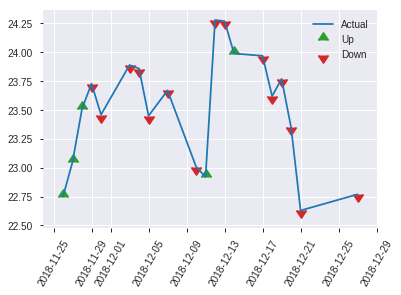


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20367084617754408
RMSE: 0.4512990651192888
LogLoss: 0.6019268935345361
Mean Per-Class Error: 0.28152173913043477
AUC: 0.7614624505928854
pr_auc: 0.7289205155128754
Gini: 0.5229249011857708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37592791288569: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      89   43   0.3258   (43.0/132.0)
1      29   86   0.2522   (29.0/115.0)
Total  118  129  0.2915   (72.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375928     0.704918  128
max f2                       0.150023     0.82963   214
max f0point5                 0.519284     0.724138  79
max accuracy                 0.519284     0.720648  79
max precision                0.665245     0.92      24
max recall                   0.0348646    1         245
max specificity              0.873742     0.992424  0
max absolute_mcc             0.519284     0.446669  79
max min_per_class_accuracy   0.397418     0.69697   120
max mean_per_class_accuracy  0.423453     0.718478  111

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 39.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.836923           1.43188   1.43188            0.666667         0.865961   0.666667                    0.865961            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.780933           1.07391   1.2887             0.5              0.797231   0.6                         0.838469            0.00869565      0.026087                   7.3913    28.8696
    3        0.0323887                   0.768548           2.14783   1.61087            1                0.775492   0.75                        0.814853            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.7595             2.14783   1.71826            1                0.766715   0.8                         0.805225            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.743364           2.14783   1.81739            1                0.753969   0.846154                    0.793397            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.664905           2.14783   1.976              1                0.700658   0.92                        0.748882            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.625636           1.61087   1.85758            0.75             0.643475   0.864865                    0.714696            0.0782609       0.278261                   61.087    85.7579
    8        0.202429                    0.575155           1.65217   1.80417            0.769231         0.601862   0.84                        0.685359            0.0869565       0.365217                   65.2174   80.4174
    9        0.299595                    0.536664           1.43188   1.68343            0.666667         0.552901   0.783784                    0.6424              0.13913         0.504348                   43.1884   68.3431
    10       0.40081                     0.458848           1.11687   1.54036            0.52             0.499793   0.717172                    0.606388            0.113043        0.617391                   11.687    54.036
    11       0.502024                    0.393049           1.03096   1.43766            0.48             0.422656   0.669355                    0.569345            0.104348        0.721739                   3.09565   43.7658
    12       0.59919                     0.324234           0.447464  1.27709            0.208333         0.354613   0.594595                    0.534524            0.0434783       0.765217                   -55.2536  27.7086
    13       0.700405                    0.260154           0.85913   1.21669            0.4              0.293113   0.566474                    0.499638            0.0869565       0.852174                   -14.087   21.6688
    14       0.797571                    0.187834           0.626449  1.14478            0.291667         0.226637   0.532995                    0.466379            0.0608696       0.913043                   -37.3551  14.478
    15       0.898785                    0.122215           0.601391  1.08359            0.28             0.160519   0.504505                    0.431935            0.0608696       0.973913                   -39.8609  8.35879
    16       1                           0.0303579          0.257739  1                  0.12             0.0880961  0.465587                    0.397

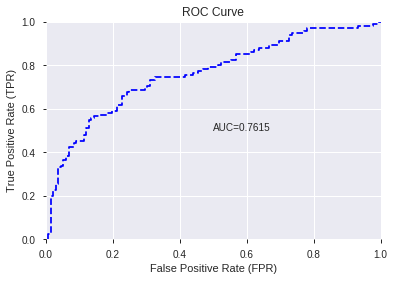

This function is available for GLM models only


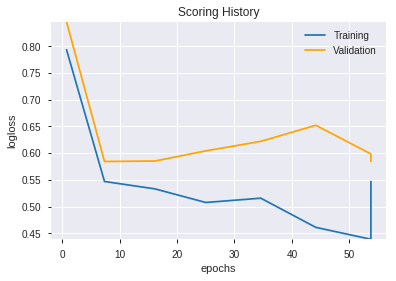

--2019-08-26 14:06:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


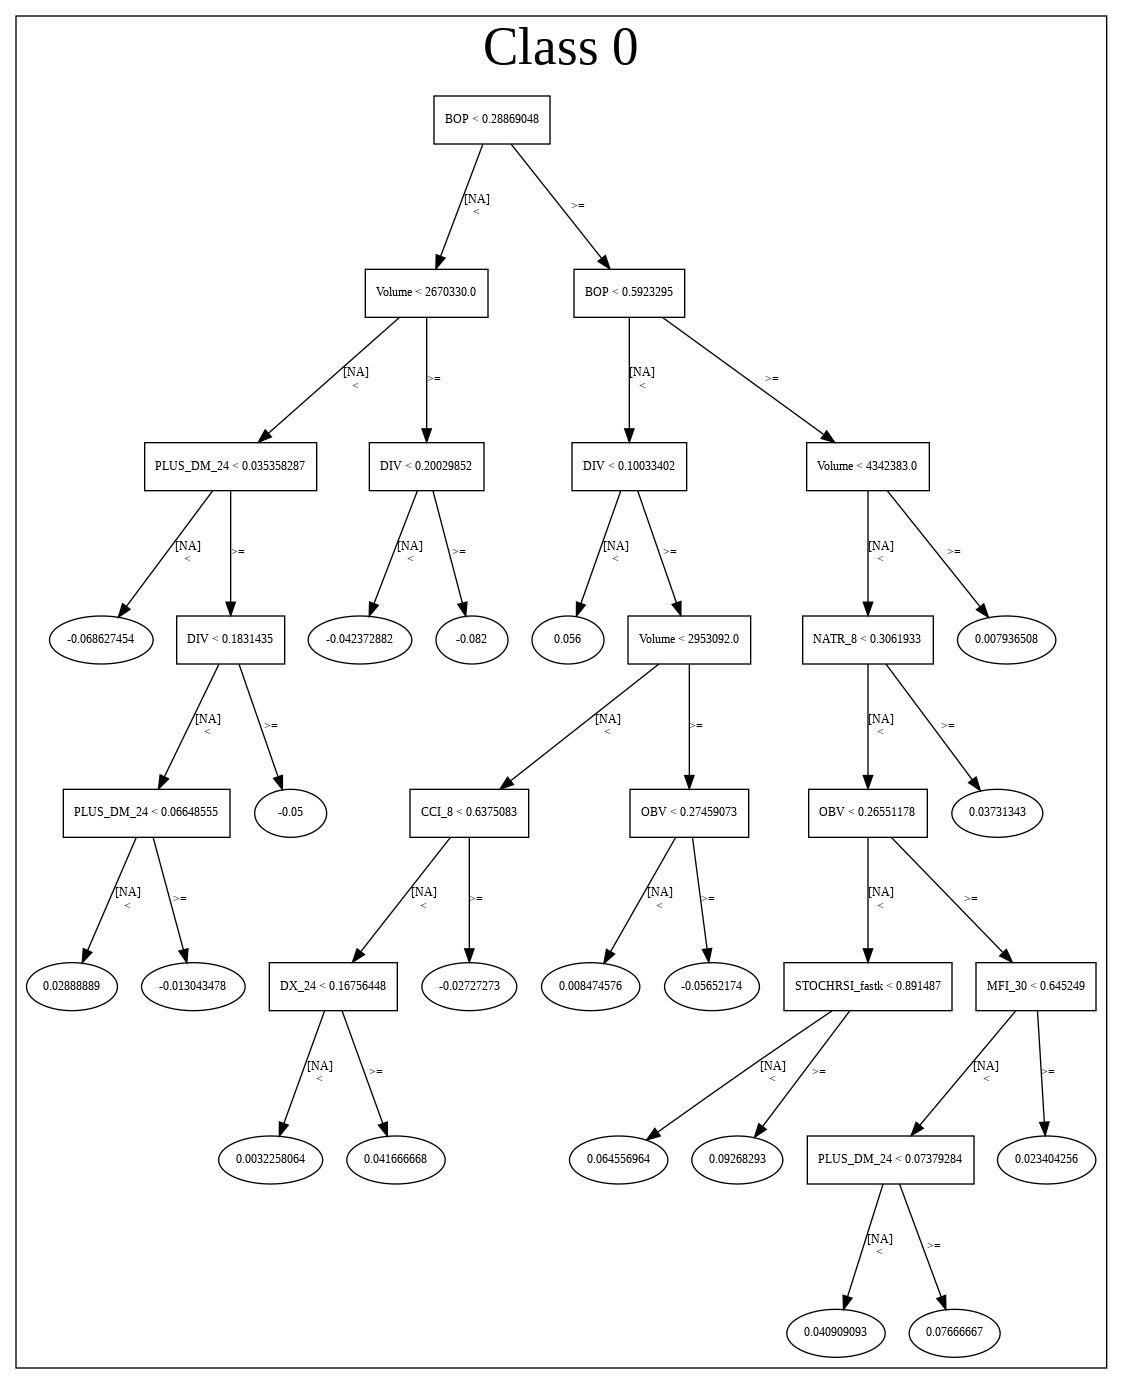

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_135545_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_135545_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'SIN',
 'AROONOSC_8',
 'day',
 'OBV',
 'dayofweek',
 'Volume',
 'MFI_30',
 'SUB',
 'month',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'ADXR_14',
 'AROONOSC_14',
 'DX_24',
 'PLUS_DM_24',
 'CCI_8',
 'TRANGE',
 'DX_8',
 'WILLR_14',
 'DX_30',
 'BETA_8',
 'WILLR_12',
 'STOCHF_fastk',
 'CCI_12',
 'DX_20',
 'WILLR_8',
 'ULTOSC',
 'NATR_8',
 'RSI_14',
 'quarter',
 'NATR_14',
 'NATR_24',
 'CDLBELTHOLD',
 'AROONOSC_12',
 'DX_14',
 'CMO_12',
 'AROONOSC_20',
 'aroonup_12',
 'ROC_20',
 'WILLR_24',
 'CMO_8',
 'WILLR_20',
 'RSI_8',
 'CDLSTALLEDPATTERN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_140629_model_1  0.774967  0.653264              0.324901  0.467485  0.218542

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.490042           1.000000    0.164677
1                  DIV             0.185606           0.378756    0.062372
2          CDLLONGLINE             0.168804           0.344468    0.056726
3           AROONOSC_8             0.138420           0.282466    0.046516
4                  SUB             0.123439           0.251895    0.041481
5       STOCHRSI_fastk             0.112451           0.229472    0.037789
6   CDLCLOSINGMARUBOZU             0.106462           0.217252    0.035776
7         STOCHF_fastk             0.097455           0.198870    0.032749
8        CDLHANGINGMAN             0.097278           0.198509    0.032690
9               Volume             0.095957           0.195814    0.032246
10    CDLDRAGONFLYDOJI             0.091616           0.186955    0.030787
11                 SIN             0.086912           0.177356    0.029206
12               CCI_8             0.078707           0.160612    0.026449
13              TRANGE             0.073284           0.149546    0.024627
14              MFI_30             0.069528           0.141882    0.023365
15         AROONOSC_14             0.069046           0.140898    0.023203
16            WILLR_12             0.062069           0.126661    0.020858
17                 OBV             0.056097           0.114474    0.018851
18              CCI_12             0.053518           0.109210    0.017984
19         CDLBELTHOLD             0.053157           0.108475    0.017863
20                 day             0.044225           0.090248    0.014862
21            WILLR_24             0.042762           0.087261    0.014370
22            WILLR_14             0.041243           0.084162    0.013860
23            WILLR_20             0.037944           0.077431    0.012751
24             ADXR_14             0.037422           0.076365    0.012575
25              BETA_8             0.034722           0.070855    0.011668
26               DX_30             0.033177           0.067703    0.011149
27              ROC_20             0.033144           0.067634    0.011138
28           dayofweek             0.030988           0.063236    0.010413
29               CMO_8             0.028347           0.057847    0.009526
30               RSI_8             0.027739           0.056605    0.009321
31             quarter             0.027164           0.055431    0.009128
32              NATR_8             0.024921           0.050855    0.008375
33   CDLSTALLEDPATTERN             0.023678           0.048318    0.007957
34             WILLR_8             0.023060           0.047058    0.007749
35               DX_24             0.022213           0.045328    0.007465
36             NATR_24             0.021277           0.043419    0.007150
37              ULTOSC             0.020586           0.042008    0.006918
38         AROONOSC_20             0.019461           0.039714    0.006540
39               month             0.016905           0.034496    0.005681
40          aroonup_12             0.016123           0.032901    0.005418
41         AROONOSC_12             0.012984           0.026496    0.004363
42              CMO_12             0.011901           0.024286    0.003999
43               DX_20             0.010619           0.021669    0.003568
44          PLUS_DM_24             0.006086           0.012420    0.002045
45             CDLDOJI             0.005161           0.010531    0.001734
46               DX_14             0.004319           0.008814    0.001451
47             NATR_14             0.003827           0.007810    0.001286
48              RSI_14             0.003137           0.006401    0.001054
49                DX_8             0.000803           0.001638    0.000270

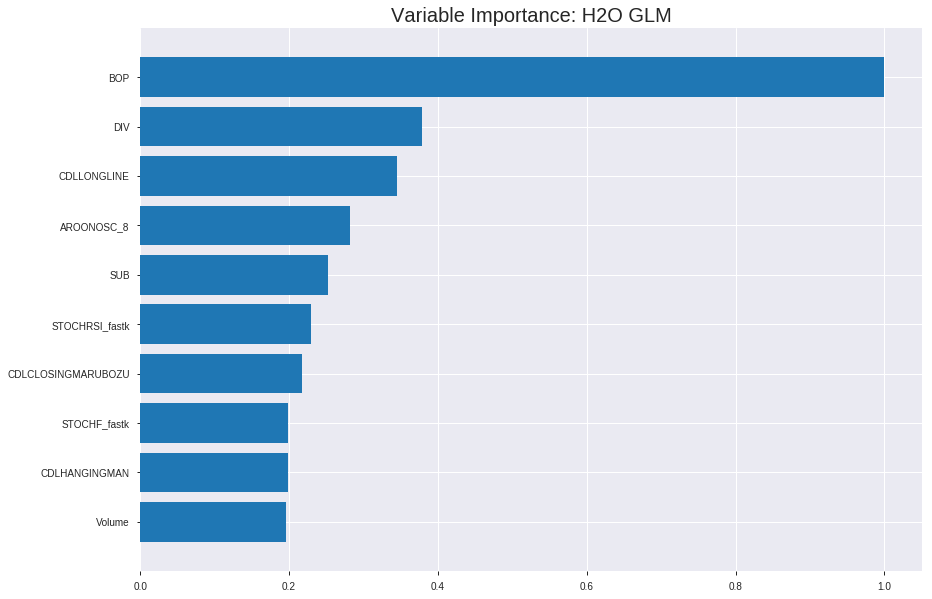

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_140629_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18701879745386532
RMSE: 0.4324567000913101
LogLoss: 0.5557935143667773
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2370.782545663055
Residual deviance: 1914.1528634791807
AIC: 2016.1528634791807
AUC: 0.7889093174807461
pr_auc: 0.7971156722967951
Gini: 0.5778186349614922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46235128752237936: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  333   0.4286   (333.0/777.0)
1      137  808   0.145    (137.0/945.0)
Total  581  1141  0.2729   (470.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462351     0.774688  238
max f2                       0.249668     0.872717  332
max f0point5                 0.563547     0.7514    182
max accuracy                 0.488059     0.728804  226
max precision                0.943657     1         0
max recall                   0.0815507    1         386
max specificity              0.943657     1         0
max absolute_mcc             0.469855     0.450152  234
max min_per_class_accuracy   0.556498     0.719434  186
max mean_per_class_accuracy  0.551595     0.721922  188

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.913719           1.61975   1.61975            0.888889         0.921197  0.888889                    0.921197            0.0169312       0.0169312                  61.9753    61.9753
    2        0.0203252                   0.898027           1.60784   1.61397            0.882353         0.907562  0.885714                    0.914575            0.015873        0.0328042                  60.7843    61.3968
    3        0.0301974                   0.887551           1.71503   1.64701            0.941176         0.89352   0.903846                    0.907691            0.0169312       0.0497354                  71.5033    64.7009
    4        0.0400697                   0.879267           1.71503   1.66377            0.941176         0.883491  0.913043                    0.901729            0.0169312       0.0666667                  71.5033    66.3768
    5        0.0505226                   0.86672            1.51852   1.63372            0.833333         0.872577  0.896552                    0.895698            0.015873        0.0825397                  51.8519    63.3716
    6        0.100465                    0.817043           1.52558   1.57996            0.837209         0.838181  0.867052                    0.867106            0.0761905       0.15873                    52.5581    57.9961
    7        0.150407                    0.781958           1.61034   1.59005            0.883721         0.798502  0.872587                    0.844326            0.0804233       0.239153                   61.0336    59.0047
    8        0.200348                    0.751004           1.44083   1.55285            0.790698         0.765196  0.852174                    0.824601            0.0719577       0.311111                   44.0827    55.285
    9        0.300232                    0.692439           1.38786   1.49796            0.761628         0.721023  0.82205                     0.790142            0.138624        0.449735                   38.7855    49.7958
    10       0.400116                    0.633196           1.33488   1.45725            0.732558         0.663387  0.79971                     0.758499            0.133333        0.583069                   33.4884    45.7249
    11       0.5                         0.568298           1.13359   1.39259            0.622093         0.597421  0.764228                    0.726321            0.113228        0.696296                   13.3592    39.2593
    12       0.599884                    0.507803           0.995866  1.32654            0.546512         0.537384  0.727977                    0.694862            0.0994709       0.795767                   -0.413437  32.6535
    13       0.699768                    0.437306           0.805168  1.25212            0.44186          0.471993  0.687137                    0.66305             0.0804233       0.87619                    -19.4832   25.2116
    14       0.799652                    0.351384           0.603876  1.17115            0.331395         0.396252  0.642702                    0.629724            0.0603175       0.936508                   -39.6124   17.1145
    15       0.899535                    0.232226           0.455556  1.09169            0.25             0.294027  0.599096                    0.592449            0.0455026       0.982011                   -54.4444   9.16864
    16       1                           0.0124266          0.179062  1                  0.0982659        0.157785  0.54878                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20439807470822885
RMSE: 0.4521040529659393
LogLoss: 0.5945388588741316
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 676.5834633095117
Residual deviance: 585.0262371321454
AIC: 687.0262371321454
AUC: 0.7525066844919787
pr_auc: 0.7654246590104562
Gini: 0.5050133689839573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28329368719992903: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   147  0.6682   (147.0/220.0)
1      20   252  0.0735   (20.0/272.0)
Total  93   399  0.3394   (167.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283294     0.751118  319
max f2                       0.134836     0.872505  376
max f0point5                 0.536368     0.740418  173
max accuracy                 0.536368     0.693089  173
max precision                0.927771     1         0
max recall                   0.0855177    1         386
max specificity              0.927771     1         0
max absolute_mcc             0.536368     0.402451  173
max min_per_class_accuracy   0.492511     0.681818  205
max mean_per_class_accuracy  0.536368     0.701136  173

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.881043           1.44706   1.44706            0.8              0.896641  0.8                         0.896641            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.865403           1.80882   1.62794            1                0.87201   0.9                         0.884326            0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.849209           1.44706   1.56765            0.8              0.854312  0.866667                    0.874321            0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.835782           1.44706   1.5375             0.8              0.844076  0.85                        0.86676             0.0147059       0.0625                     44.7059   53.75
    5        0.050813                    0.817659           1.44706   1.51941            0.8              0.827244  0.84                        0.858857            0.0147059       0.0772059                  44.7059   51.9412
    6        0.101626                    0.760454           1.59176   1.55559            0.88             0.788673  0.86                        0.823765            0.0808824       0.158088                   59.1765   55.5588
    7        0.150407                    0.717559           1.50735   1.53994            0.833333         0.736861  0.851351                    0.79558             0.0735294       0.231618                   50.7353   53.9944
    8        0.20122                     0.68124            1.51941   1.53476            0.84             0.696541  0.848485                    0.77057             0.0772059       0.308824                   51.9412   53.4759
    9        0.300813                    0.615791           1.36585   1.47884            0.755102         0.649489  0.817568                    0.730482            0.136029        0.444853                   36.5846   47.8835
    10       0.400407                    0.554308           1.29202   1.43237            0.714286         0.587402  0.791878                    0.694894            0.128676        0.573529                   29.2017   43.2368
    11       0.5                         0.507375           0.885954  1.32353            0.489796         0.531176  0.731707                    0.662283            0.0882353       0.661765                   -11.4046  32.3529
    12       0.599593                    0.450705           0.885954  1.25085            0.489796         0.477393  0.691525                    0.631573            0.0882353       0.75                       -11.4046  25.0847
    13       0.699187                    0.377686           0.922869  1.20413            0.510204         0.416225  0.665698                    0.600898            0.0919118       0.841912                   -7.71309  20.413
    14       0.79878                     0.293885           0.627551  1.13224            0.346939         0.342517  0.625954                    0.568683            0.0625          0.904412                   -37.2449  13.2241
    15       0.898374                    0.199987           0.701381  1.08448            0.387755         0.251707  0.599548                    0.533543            0.0698529       0.974265                   -29.8619  8.44756
    16       1                           0.0167912          0.253235  1                  0.14             0.117707  0.552846                    0.491283            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:06:29  0.000 sec   2            22        51            1.35503           1.3565
    2019-08-26 14:06:29  0.012 sec   4            14        51            1.34412           1.34718
    2019-08-26 14:06:29  0.028 sec   6            8.4       51            1.32915           1.33447
    2019-08-26 14:06:29  0.040 sec   8            5.2       51            1.30971           1.31813
    2019-08-26 14:06:29  0.060 sec   10           3.3       51            1.28597           1.29856
    2019-08-26 14:06:29  0.071 sec   12           2         51            1.25887           1.27694
    2019-08-26 14:06:29  0.081 sec   14           1.3       51            1.23025           1.25527
    2019-08-26 14:06:29  0.093 sec   16           0.78      51            1.2022            1.2355
    2019-08-26 14:06:29  0.104 sec   18           0.48      51            1.17663           1.21899
    2019-08-26 14:06:29  0.118 sec   20           0.3       51            1.15466           1.2062
    2019-08-26 14:06:29  0.131 sec   22           0.19      51            1.13665           1.19703
    2019-08-26 14:06:29  0.147 sec   24           0.12      51            1.12243           1.1913
    2019-08-26 14:06:29  0.163 sec   26           0.072     51            1.11159           1.18908
    2019-08-26 14:06:29  0.179 sec   28           0.045     51            1.10361           1.1909
    2019-08-26 14:06:29  0.194 sec   30           0.028     51            1.09796           1.19662
    2019-08-26 14:06:29  0.211 sec   32           0.017     51            1.09406           1.20624
    2019-08-26 14:06:29  0.222 sec   34           0.011     51            1.09142           1.21896
    2019-08-26 14:06:29  0.235 sec   36           0.0067    51            1.08966           1.23297

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7103448275862069)

('auc', 0.7749670619235837)

('logloss', 0.6532644412297008)

('mean_per_class_error', 0.28501317523056646)

('rmse', 0.4674850221493876)

('mse', 0.2185422459340134)

glm prediction progress: |████████████████████████████████████████████████| 100%


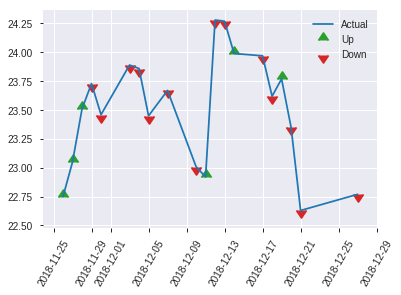


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2185422459340134
RMSE: 0.4674850221493876
LogLoss: 0.6532644412297008
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 348.1046065632917
Residual deviance: 322.7126339674723
AIC: 424.7126339674723
AUC: 0.7749670619235837
pr_auc: 0.7386787243984415
Gini: 0.5499341238471673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16658492530139735: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   72   0.5455   (72.0/132.0)
1      12   103  0.1043   (12.0/115.0)
Total  72   175  0.3401   (84.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166585     0.710345  174
max f2                       0.0937157    0.828358  209
max f0point5                 0.434049     0.727763  63
max accuracy                 0.367149     0.724696  84
max precision                0.617717     0.923077  25
max recall                   0.00242394   1         245
max specificity              0.812969     0.992424  0
max absolute_mcc             0.367149     0.451451  84
max min_per_class_accuracy   0.289224     0.704545  120
max mean_per_class_accuracy  0.367149     0.714987  84

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 30.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.728879           1.43188   1.43188            0.666667         0.767632   0.666667                    0.767632            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.721528           2.14783   1.71826            1                0.726411   0.8                         0.751144            0.0173913       0.0347826                  114.783   71.8261
    3        0.0323887                   0.71377            1.43188   1.61087            0.666667         0.719875   0.75                        0.739418            0.0173913       0.0521739                  43.1884   61.087
    4        0.0404858                   0.691265           2.14783   1.71826            1                0.704497   0.8                         0.732434            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.685611           2.14783   1.81739            1                0.687417   0.846154                    0.722045            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.618584           2.14783   1.976              1                0.640352   0.92                        0.682833            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.565061           1.78986   1.91563            0.833333         0.590902   0.891892                    0.653017            0.0869565       0.286957                   78.9855   91.5629
    8        0.202429                    0.504349           1.48696   1.80417            0.692308         0.523267   0.84                        0.619282            0.0782609       0.365217                   48.6957   80.4174
    9        0.299595                    0.402928           1.43188   1.68343            0.666667         0.444743   0.783784                    0.562675            0.13913         0.504348                   43.1884   68.3431
    10       0.40081                     0.338924           1.11687   1.54036            0.52             0.367707   0.717172                    0.513441            0.113043        0.617391                   11.687    54.036
    11       0.502024                    0.28479            1.03096   1.43766            0.48             0.306602   0.669355                    0.471739            0.104348        0.721739                   3.09565   43.7658
    12       0.59919                     0.231278           0.626449  1.30611            0.291667         0.25743    0.608108                    0.436986            0.0608696       0.782609                   -37.3551  30.611
    13       0.700405                    0.16952            0.945043  1.25393            0.44             0.195121   0.583815                    0.402035            0.0956522       0.878261                   -5.49565  25.3933
    14       0.797571                    0.110919           0.536957  1.16659            0.25             0.144918   0.543147                    0.370711            0.0521739       0.930435                   -46.3043  16.6586
    15       0.898785                    0.0658514          0.343652  1.07391            0.16             0.092014   0.5                         0.339326            0.0347826       0.965217                   -65.6348  7.3913
    16       1                           0.00079954         0.343652  1                  0.16             0.0399908  0.465587                    0.3090

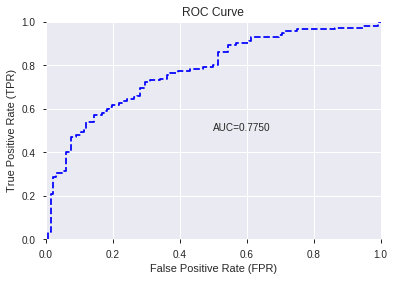

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


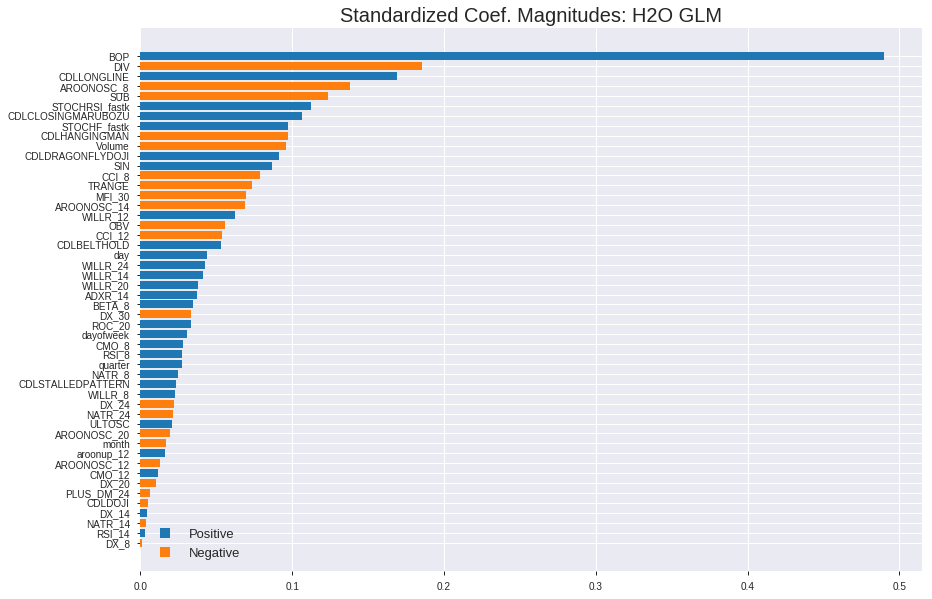

'log_likelihood'
--2019-08-26 14:06:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


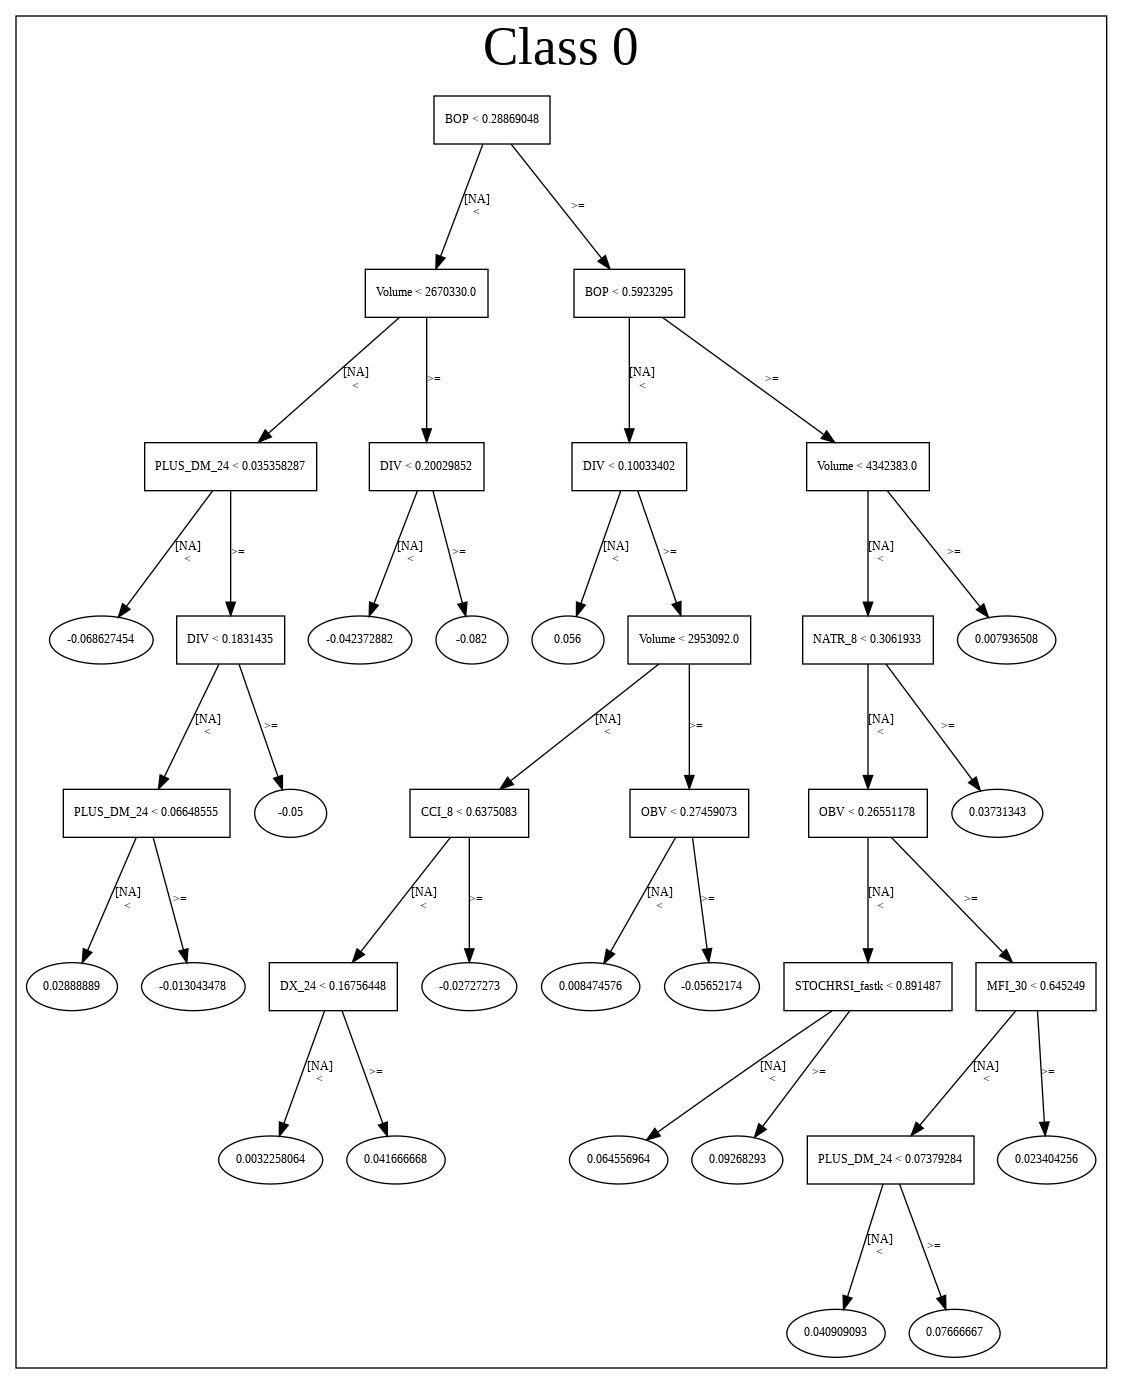

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_140629_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_140629_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'DIV',
 'CDLLONGLINE',
 'AROONOSC_8',
 'SUB',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'SIN',
 'CCI_8',
 'TRANGE',
 'MFI_30',
 'AROONOSC_14',
 'WILLR_12',
 'OBV',
 'CCI_12',
 'CDLBELTHOLD',
 'day',
 'WILLR_24',
 'WILLR_14',
 'WILLR_20',
 'ADXR_14',
 'BETA_8',
 'DX_30',
 'ROC_20',
 'dayofweek',
 'CMO_8',
 'RSI_8',
 'quarter',
 'NATR_8',
 'CDLSTALLEDPATTERN',
 'WILLR_8',
 'DX_24',
 'NATR_24',
 'ULTOSC',
 'AROONOSC_20',
 'month',
 'aroonup_12',
 'AROONOSC_12',
 'CMO_12',
 'DX_20',
 'PLUS_DM_24',
 'CDLDOJI',
 'DX_14',
 'NATR_14',
 'RSI_14',
 'DX_8']

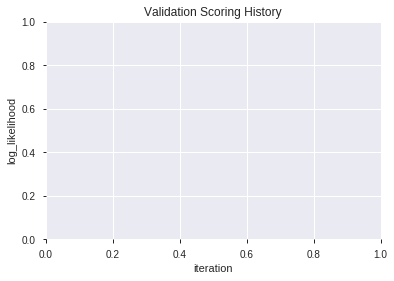

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190826_140642  0.794071  0.556862              0.248584  0.431879  0.186519
1  XGBoost_grid_1_AutoML_20190826_140642_model_4  0.792029  0.563863              0.275791  0.435573  0.189724
2  XGBoost_grid_1_AutoML_20190826_140642_model_3  0.790975  0.560436              0.281686  0.434232  0.188557
3  XGBoost_grid_1_AutoML_20190826_140642_model_2  0.780896  0.586543              0.305402  0.446618  0.199468
4               XGBoost_3_AutoML_20190826_140642  0.774440  0.582056              0.303294  0.444528  0.197605
5  XGBoost_grid_1_AutoML_20190826_140642_model_1  0.774242  0.580524              0.288274  0.442999  0.196248
6  XGBoost_grid_1_AutoML_20190826_140642_model_6  0.767721  0.586353              0.329677  0.447058  0.199861
7               XGBoost_1_AutoML_20190826_140642  0.767062  0.582271              0.311858  0.445423  0.198401
8  XGBoost_grid_1_AutoML_20190826_140642_model_7  0.764229  0.585076              0.293050  0.445629  0.198585
9  XGBoost_grid_1_AutoML_20190826_140642_model_5  0.748485  0.592353              0.313241  0.450170  0.202653

variable  relative_importance  scaled_importance  percentage
0                  BOP          2261.427734           1.000000    0.303224
1                  DIV           620.439941           0.274358    0.083192
2               Volume           309.909119           0.137041    0.041554
3       STOCHRSI_fastk           297.154541           0.131401    0.039844
4                CCI_8           244.914856           0.108301    0.032839
5                  OBV           232.928207           0.103001    0.031232
6         STOCHF_fastk           204.884094           0.090599    0.027472
7           PLUS_DM_24           180.036102           0.079612    0.024140
8                  SUB           159.692215           0.070616    0.021412
9             WILLR_20           152.601151           0.067480    0.020462
10              NATR_8           132.510864           0.058596    0.017768
11              MFI_30           128.415146           0.056785    0.017219
12             ADXR_14           128.170074           0.056677    0.017186
13               DX_30           125.873466           0.055661    0.016878
14              TRANGE           124.332359           0.054980    0.016671
15             NATR_24           123.318909           0.054531    0.016535
16            WILLR_24           122.594070           0.054211    0.016438
17              BETA_8           116.459099           0.051498    0.015615
18             NATR_14           104.174576           0.046066    0.013968
19               DX_24           102.586647           0.045364    0.013755
20         CDLLONGLINE           102.166473           0.045178    0.013699
21          AROONOSC_8           101.988678           0.045099    0.013675
22              CCI_12            90.713722           0.040113    0.012163
23                DX_8            86.766068           0.038368    0.011634
24              ROC_20            86.246864           0.038138    0.011564
25                 SIN            81.767838           0.036158    0.010964
26               month            79.354904           0.035091    0.010640
27               CMO_8            78.006744           0.034494    0.010460
28         AROONOSC_14            76.490578           0.033824    0.010256
29            WILLR_14            72.895401           0.032234    0.009774
30                 day            72.157860           0.031908    0.009675
31              ULTOSC            68.120491           0.030123    0.009134
32             WILLR_8            66.838249           0.029556    0.008962
33              RSI_14            62.492775           0.027634    0.008379
34         AROONOSC_12            61.344925           0.027127    0.008225
35         AROONOSC_20            56.487751           0.024979    0.007574
36            WILLR_12            54.889885           0.024272    0.007360
37          aroonup_12            52.182835           0.023075    0.006997
38               DX_20            48.040249           0.021243    0.006441
39              CMO_12            47.933983           0.021196    0.006427
40           dayofweek            41.402008           0.018308    0.005551
41               DX_14            36.501659           0.016141    0.004894
42               RSI_8            35.969669           0.015906    0.004823
43             quarter            11.773804           0.005206    0.001579
44  CDLCLOSINGMARUBOZU             9.025551           0.003991    0.001210
45             CDLDOJI             3.974323           0.001757    0.000533

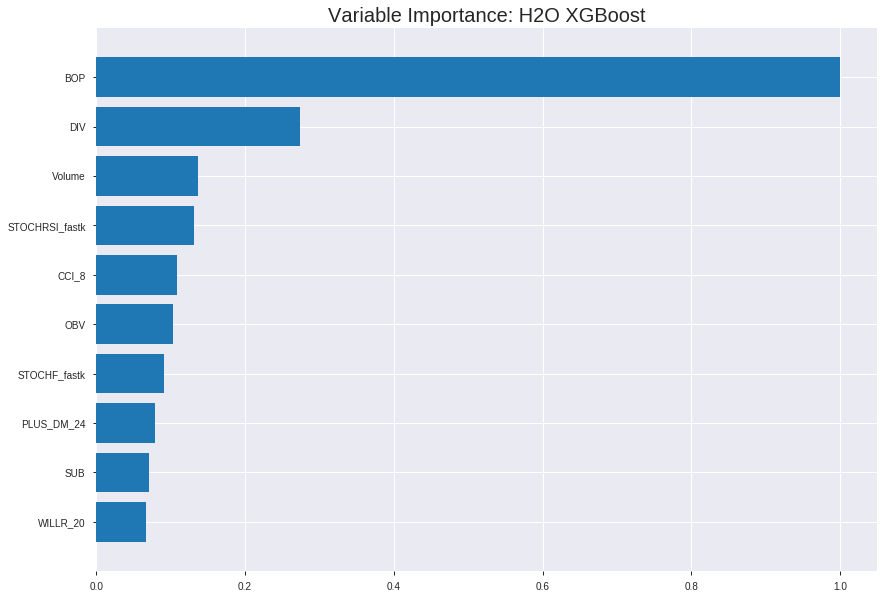

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190826_140642


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13779823374594005
RMSE: 0.3712118448351831
LogLoss: 0.43918851232722855
Mean Per-Class Error: 0.17593307593307594
AUC: 0.9016050063669111
pr_auc: 0.9161511164748839
Gini: 0.8032100127338222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5079137235879898: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      592  185   0.2381   (185.0/777.0)
1      119  826   0.1259   (119.0/945.0)
Total  711  1011  0.1765   (304.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507914     0.844581  211
max f2                       0.305414     0.899063  298
max f0point5                 0.685217     0.847673  124
max accuracy                 0.537605     0.826365  197
max precision                0.924348     1         0
max recall                   0.152444     1         360
max specificity              0.924348     1         0
max absolute_mcc             0.537605     0.649005  197
max min_per_class_accuracy   0.562089     0.815959  186
max mean_per_class_accuracy  0.537605     0.824067  197

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.46 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.899181           1.82222    1.82222            1                0.908731  1                           0.908731            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.890459           1.82222    1.82222            1                0.894498  1                           0.901818            0.0179894       0.037037                   82.2222   82.2222
    3        0.0301974                   0.882999           1.82222    1.82222            1                0.885874  1                           0.896605            0.0179894       0.0550265                  82.2222   82.2222
    4        0.0400697                   0.875001           1.82222    1.82222            1                0.879851  1                           0.892477            0.0179894       0.0730159                  82.2222   82.2222
    5        0.0505226                   0.869546           1.82222    1.82222            1                0.87219   1                           0.88828             0.0190476       0.0920635                  82.2222   82.2222
    6        0.100465                    0.8401             1.80103    1.81169            0.988372         0.853607  0.99422                     0.871044            0.0899471       0.182011                   80.1034   81.1689
    7        0.150407                    0.818707           1.73747    1.78704            0.953488         0.829816  0.980695                    0.857354            0.0867725       0.268783                   73.7468   78.7044
    8        0.200348                    0.791049           1.77984    1.78525            0.976744         0.804043  0.97971                     0.844065            0.0888889       0.357672                   77.9845   78.525
    9        0.300232                    0.737546           1.61034    1.72706            0.883721         0.764172  0.947776                    0.817486            0.160847        0.518519                   61.0336   72.7058
    10       0.400116                    0.671847           1.41964    1.65031            0.77907          0.704886  0.90566                     0.789376            0.141799        0.660317                   41.9638   65.0314
    11       0.5                         0.588768           1.22894    1.56614            0.674419         0.630516  0.859466                    0.757641            0.122751        0.783069                   22.8941   56.6138
    12       0.599884                    0.497029           0.974677   1.46766            0.534884         0.542051  0.805421                    0.721744            0.0973545       0.880423                   -2.5323   46.7656
    13       0.699768                    0.384873           0.61447    1.34587            0.337209         0.437902  0.738589                    0.681229            0.0613757       0.941799                   -38.553   34.5874
    14       0.799652                    0.28565            0.339018   1.22011            0.186047         0.335673  0.669572                    0.638066            0.0338624       0.975661                   -66.0982  22.0108
    15       0.899535                    0.171734           0.222481   1.10933            0.122093         0.232523  0.60878                     0.593035            0.0222222       0.997884                   -77.7519  10.9332
    16       1                           0.0527005          0.0210662  1                  0.0115607        0.111127  0.54878                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19794674116347086
RMSE: 0.44491206003374517
LogLoss: 0.5802347700789503
Mean Per-Class Error: 0.294485294117647
AUC: 0.7585477941176471
pr_auc: 0.7714214683781471
Gini: 0.5170955882352941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4040779769420624: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      98   122  0.5545   (122.0/220.0)
1      26   246  0.0956   (26.0/272.0)
Total  124  368  0.3008   (148.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404078     0.76875   286
max f2                       0.20909      0.870406  371
max f0point5                 0.539453     0.735085  212
max accuracy                 0.539453     0.711382  212
max precision                0.886517     1         0
max recall                   0.145773     1         386
max specificity              0.886517     1         0
max absolute_mcc             0.539453     0.413693  212
max min_per_class_accuracy   0.587373     0.690909  188
max mean_per_class_accuracy  0.539453     0.705515  212

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 55.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.855024           1.44706   1.44706            0.8              0.867904  0.8                         0.867904            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.835881           1.80882   1.62794            1                0.845731  0.9                         0.856817            0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.829884           1.44706   1.56765            0.8              0.834455  0.866667                    0.849363            0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.825534           1.80882   1.62794            1                0.827713  0.9                         0.843951            0.0183824       0.0661765                  80.8824   62.7941
    5        0.050813                    0.812032           1.80882   1.66412            1                0.819066  0.92                        0.838974            0.0183824       0.0845588                  80.8824   66.4118
    6        0.101626                    0.77999            1.44706   1.55559            0.8              0.795038  0.86                        0.817006            0.0735294       0.158088                   44.7059   55.5588
    7        0.150407                    0.761967           1.50735   1.53994            0.833333         0.77045   0.851351                    0.801906            0.0735294       0.231618                   50.7353   53.9944
    8        0.20122                     0.733395           1.30235   1.47995            0.72             0.748161  0.818182                    0.788334            0.0661765       0.297794                   30.2353   47.9947
    9        0.300813                    0.697989           1.43968   1.46661            0.795918         0.716521  0.810811                    0.764558            0.143382        0.441176                   43.9676   46.6614
    10       0.400407                    0.653575           1.14436   1.38646            0.632653         0.676618  0.766497                    0.742685            0.113971        0.555147                   14.4358   38.6459
    11       0.5                         0.594605           1.10744   1.33088            0.612245         0.625517  0.735772                    0.719346            0.110294        0.665441                   10.7443   33.0882
    12       0.599593                    0.511449           0.959784  1.26924            0.530612         0.55983   0.701695                    0.69285             0.0955882       0.761029                   -4.02161  26.9242
    13       0.699187                    0.43009            0.885954  1.21465            0.489796         0.471314  0.671512                    0.661294            0.0882353       0.849265                   -11.4046  21.4646
    14       0.79878                     0.371376           0.812125  1.16446            0.44898          0.401804  0.643766                    0.628941            0.0808824       0.930147                   -18.7875  16.4459
    15       0.898374                    0.280415           0.442977  1.08448            0.244898         0.329476  0.599548                    0.595742            0.0441176       0.974265                   -55.7023  8.44756
    16       1                           0.0752288          0.253235  1                  0.14             0.186981  0.552846                    0.554201         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:06:43  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.45122                          0.5                0.693147              0.5               0                    1                  0.447154
    2019-08-26 14:06:43  0.049 sec   5                  0.471263         0.636945            0.825553        0.838482           1.82222          0.247967                         0.483812           0.661163              0.748446          0.764308             1.50735            0.313008
    2019-08-26 14:06:43  0.088 sec   10                 0.451163         0.598418            0.841149        0.859457           1.82222          0.238676                         0.474117           0.642107              0.744285          0.761181             1.80882            0.315041
    2019-08-26 14:06:43  0.131 sec   15                 0.436127         0.569373            0.847635        0.864728           1.72099          0.224158                         0.466695           0.627333              0.747836          0.769418             1.80882            0.300813
    2019-08-26 14:06:43  0.191 sec   20                 0.424876         0.54735             0.854529        0.872369           1.82222          0.224158                         0.459605           0.613144              0.755749          0.776363             1.44706            0.302846
    2019-08-26 14:06:43  0.239 sec   25                 0.415548         0.528914            0.861393        0.878739           1.82222          0.214286                         0.456232           0.606058              0.755398          0.776075             1.44706            0.29065
    2019-08-26 14:06:43  0.286 sec   30                 0.407681         0.5129              0.866014        0.883143           1.82222          0.206736                         0.452602           0.598329              0.75615           0.773645             1.44706            0.29878
    2019-08-26 14:06:44  0.333 sec   35                 0.400927         0.498943            0.870202        0.88702            1.82222          0.202091                         0.450209           0.592857              0.757829          0.774836             1.44706            0.296748
    2019-08-26 14:06:44  0.385 sec   40                 0.3958           0.488221            0.874033        0.889974           1.82222          0.202091                         0.448974           0.589673              0.756593          0.777713             1.44706            0.321138
    2019-08-26 14:06:44  0.433 sec   45                 0.391292         0.478861            0.878069        0.894093           1.82222          0.200348                         0.447542           0.58643               0.756593          0.773693             1.44706            0.308943
    2019-08-26 14:06:44  0.482 sec   50                 0.38714          0.470439            0.883158        0.899678           1.82222          0.203252                         0.446724           0.58464               0.757854          0.774986             1.44706            0.335366
    2019-08-26 14:06:44  0.531 sec   55                 0.382647         0.461383            0.888172        0.904994           1.82222          0.195703                         0.446873           0.584568              0.756425          0.7

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 2261.427734375         1.0                    0.30322350994377384
DIV                 620.43994140625        0.2743576245993655     0.0831916819108559
Volume              309.90911865234375     0.13704135398250725    0.041554160362023015
STOCHRSI_fastk      297.154541015625       0.1314012986126885     0.03984396297650935
CCI_8               244.91485595703125     0.10830098713046843    0.03283940544807611
---                 ---                    ---                    ---
DX_14               36.50165939331055      0.016140979806015626   0.004894324550711632
RSI_8               35.969669342041016     0.015905734592037316   0.004822992671231655
quarter             11.7738037109375       0.005206358590181293   0.0015786903257406896
CDLCLOSINGMARUBOZU  9.025550842285156      0.003991085235708221   0.0012101908736562208
CDLDOJI             3.97432279586792       0.0017574396632074204  0.0005328970231921578


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7449392712550608)

('F1', 0.7647058823529411)

('auc', 0.7940711462450593)

('logloss', 0.5568617435695489)

('mean_per_class_error', 0.2485836627140975)

('rmse', 0.43187854732995506)

('mse', 0.18651907964383221)

xgboost prediction progress: |████████████████████████████████████████████| 100%


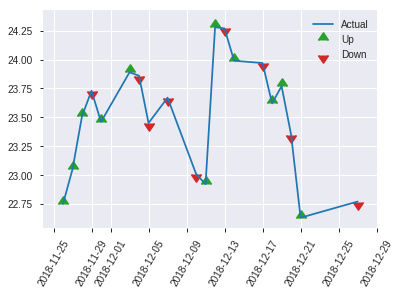


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18651907964383221
RMSE: 0.43187854732995506
LogLoss: 0.5568617435695489
Mean Per-Class Error: 0.2485836627140975
AUC: 0.7940711462450593
pr_auc: 0.7332879321245602
Gini: 0.5881422924901185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4146454334259033: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   53   0.4015   (53.0/132.0)
1      11   104  0.0957   (11.0/115.0)
Total  90   157  0.2591   (64.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414645     0.764706  156
max f2                       0.395214     0.846774  159
max f0point5                 0.534228     0.726795  113
max accuracy                 0.534228     0.744939  113
max precision                0.854898     1         0
max recall                   0.11223      1         244
max specificity              0.854898     1         0
max absolute_mcc             0.414645     0.521181  156
max min_per_class_accuracy   0.522685     0.730435  117
max mean_per_class_accuracy  0.414645     0.751416  156

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.841361           2.14783   2.14783            1                0.850704  1                           0.850704            0.026087        0.026087                   114.783   114.783
    2        0.0202429                   0.814611           1.07391   1.71826            0.5              0.830826  0.8                         0.842753            0.00869565      0.0347826                  7.3913    71.8261
    3        0.0323887                   0.809614           2.14783   1.87935            1                0.812826  0.875                       0.83153             0.026087        0.0608696                  114.783   87.9348
    4        0.0404858                   0.80548            2.14783   1.93304            1                0.806481  0.9                         0.826521            0.0173913       0.0782609                  114.783   93.3043
    5        0.0526316                   0.795361           1.43188   1.81739            0.666667         0.801097  0.846154                    0.820654            0.0173913       0.0956522                  43.1884   81.7391
    6        0.101215                    0.776014           1.43188   1.63235            0.666667         0.786066  0.76                        0.804051            0.0695652       0.165217                   43.1884   63.2348
    7        0.149798                    0.747515           1.96884   1.74148            0.916667         0.765628  0.810811                    0.79159             0.0956522       0.26087                    96.8841   74.1481
    8        0.202429                    0.708873           1.81739   1.76122            0.846154         0.727318  0.82                        0.774879            0.0956522       0.356522                   81.7391   76.1217
    9        0.299595                    0.64673            1.34239   1.62538            0.625            0.683538  0.756757                    0.745255            0.130435        0.486957                   34.2391   62.5382
    10       0.40081                     0.583027           1.37461   1.56206            0.64             0.61647   0.727273                    0.712733            0.13913         0.626087                   37.4609   56.2055
    11       0.502024                    0.499768           1.11687   1.4723             0.52             0.5411    0.685484                    0.67813             0.113043        0.73913                    11.687    47.23
    12       0.59919                     0.447462           0.98442   1.39318            0.458333         0.477035  0.648649                    0.64552             0.0956522       0.834783                   -1.55797  39.3184
    13       0.700405                    0.362344           0.773217  1.30359            0.36             0.398213  0.606936                    0.609782            0.0782609       0.913043                   -22.6783  30.3594
    14       0.797571                    0.278008           0.357971  1.18839            0.166667         0.309672  0.553299                    0.57322             0.0347826       0.947826                   -64.2029  18.8391
    15       0.898785                    0.208006           0.257739  1.08359            0.12             0.247139  0.504505                    0.536499            0.026087        0.973913                   -74.2261  8.35879
    16       1                           0.0938039          0.257739  1                  0.12             0.160475  0.465587                    0.49844            

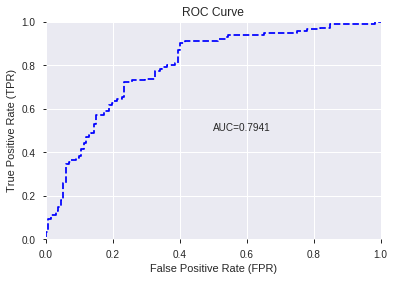

This function is available for GLM models only


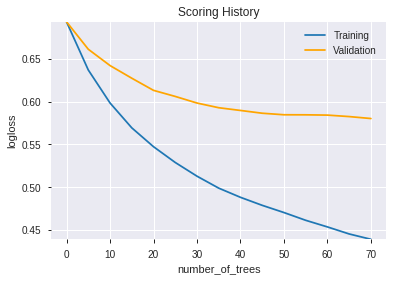

--2019-08-26 14:06:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


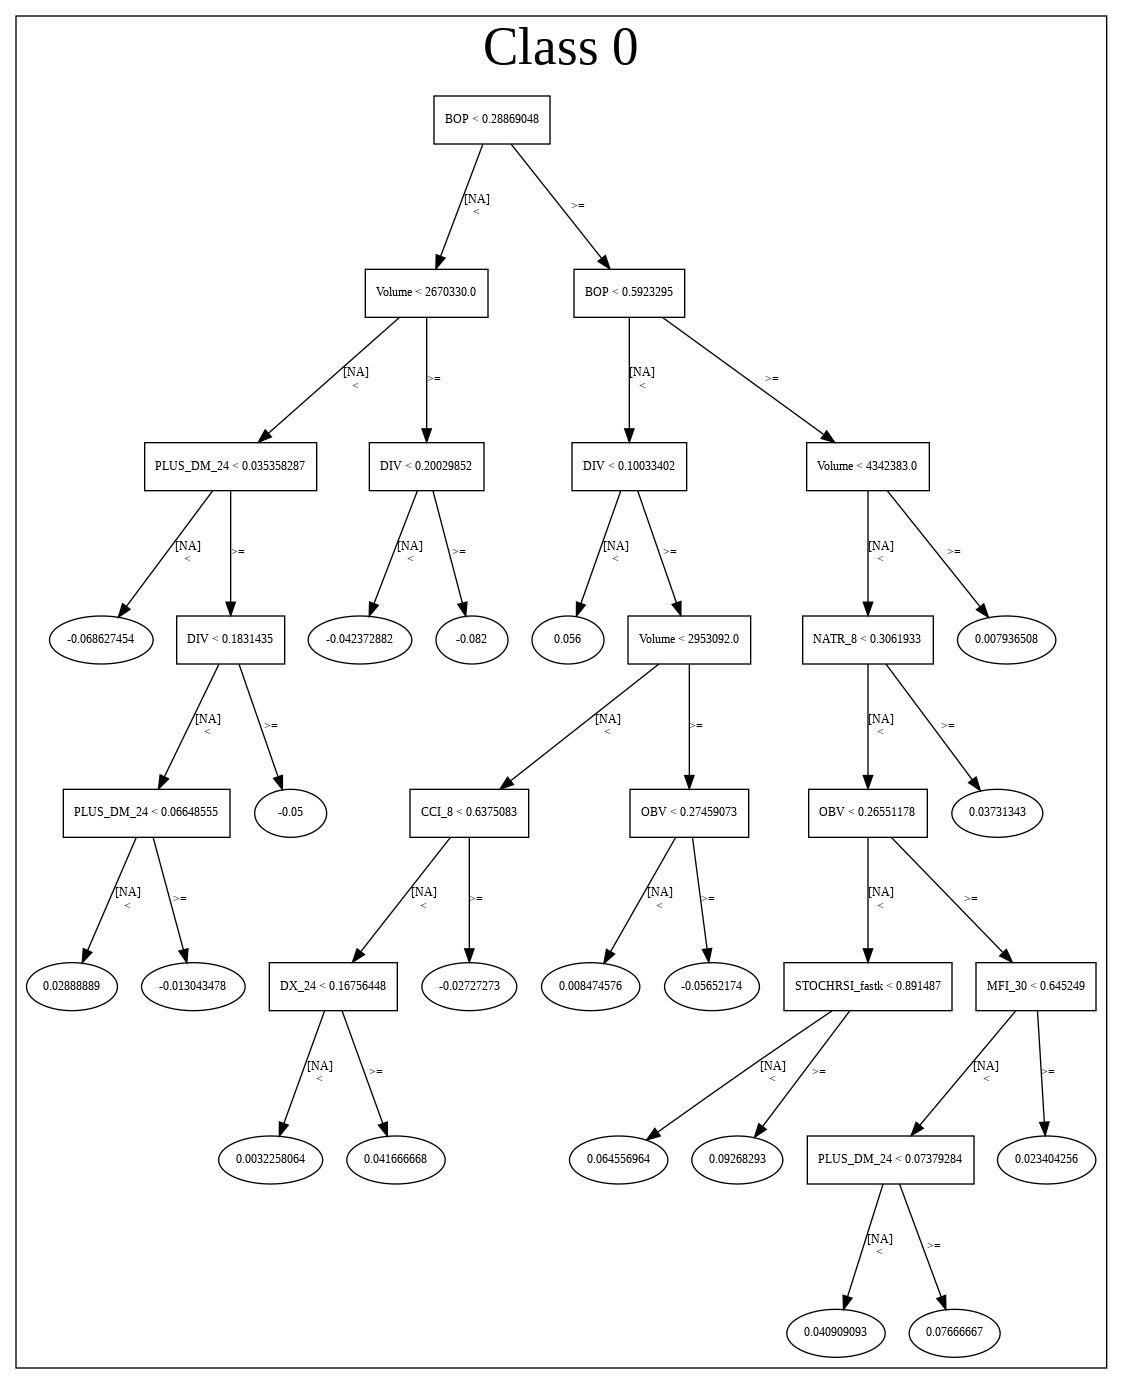

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190826_140642',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190826_140642',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_ba53',
   'type

['BOP',
 'DIV',
 'Volume',
 'STOCHRSI_fastk',
 'CCI_8',
 'OBV',
 'STOCHF_fastk',
 'PLUS_DM_24',
 'SUB',
 'WILLR_20',
 'NATR_8',
 'MFI_30',
 'ADXR_14',
 'DX_30',
 'TRANGE',
 'NATR_24',
 'WILLR_24',
 'BETA_8',
 'NATR_14',
 'DX_24',
 'CDLLONGLINE',
 'AROONOSC_8',
 'CCI_12',
 'DX_8',
 'ROC_20',
 'SIN',
 'month',
 'CMO_8',
 'AROONOSC_14',
 'WILLR_14',
 'day',
 'ULTOSC',
 'WILLR_8',
 'RSI_14',
 'AROONOSC_12',
 'AROONOSC_20',
 'WILLR_12',
 'aroonup_12',
 'DX_20',
 'CMO_12',
 'dayofweek',
 'DX_14',
 'RSI_8',
 'quarter',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

40

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'NATR_8',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_140706_model_5  0.763834  0.610824              0.304974  0.454427  0.206504
1  DeepLearning_grid_1_AutoML_20190826_140706_model_8  0.760738  0.582242              0.279414  0.444145  0.197265
2               DeepLearning_1_AutoML_20190826_140706  0.757708  0.705526              0.330369  0.489142  0.239260
3  DeepLearning_grid_1_AutoML_20190826_140706_model_9  0.756061  0.607824              0.333169  0.452601  0.204847
4  DeepLearning_grid_1_AutoML_20190826_140706_model_6  0.747826  0.675114              0.292885  0.469087  0.220042
5  DeepLearning_grid_1_AutoML_20190826_140706_model_4  0.734321  0.631642              0.358300  0.461972  0.213418
6  DeepLearning_grid_1_AutoML_20190826_140706_model_2  0.727931  1.425208              0.392523  0.548406  0.300749
7  DeepLearning_grid_1_AutoML_20190826_140706_model_1  0.691634  2.728198              0.358136  0.627102  0.393257
8  DeepLearning_grid_1_AutoML_20190826_140706_model_7  0.687945  1.280150              0.333169  0.525055  0.275683
9  DeepLearning_grid_1_AutoML_20190826_140706_model_3  0.686495  1.599882              0.397991  0.578364  0.334505

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.052312
1                  DIV             0.683687           0.683687    0.035765
2          CDLLONGLINE             0.624208           0.624208    0.032654
3        CDLHANGINGMAN             0.586726           0.586726    0.030693
4               Volume             0.561012           0.561012    0.029348
5       STOCHRSI_fastk             0.557141           0.557141    0.029145
6                  SUB             0.551024           0.551024    0.028825
7       STOCHRSI_fastd             0.534056           0.534056    0.027937
8   CDLCLOSINGMARUBOZU             0.533512           0.533512    0.027909
9               TRANGE             0.513844           0.513844    0.026880
10        STOCHF_fastk             0.507832           0.507832    0.026566
11              NATR_8             0.503714           0.503714    0.026350
12        CDLSHORTLINE             0.485945           0.485945    0.025421
13              ULTOSC             0.471252           0.471252    0.024652
14            WILLR_12             0.467781           0.467781    0.024471
15         STOCH_slowk             0.463816           0.463816    0.024263
16        CDLENGULFING             0.461090           0.461090    0.024120
17        STOCHF_fastd             0.453684           0.453684    0.023733
18               CCI_8             0.440623           0.440623    0.023050
19            WILLR_24             0.439617           0.439617    0.022997
20            WILLR_20             0.437294           0.437294    0.022876
21              CMO_12             0.430346           0.430346    0.022512
22              RSI_14             0.426259           0.426259    0.022298
23             WILLR_8             0.423000           0.423000    0.022128
24               RSI_8             0.421908           0.421908    0.022071
25              RSI_12             0.420187           0.420187    0.021981
26            WILLR_30             0.419020           0.419020    0.021920
27            WILLR_14             0.418178           0.418178    0.021876
28              CCI_12             0.415287           0.415287    0.021724
29              CMO_14             0.414919           0.414919    0.021705
30              CCI_20             0.414169           0.414169    0.021666
31         CDLBELTHOLD             0.413969           0.413969    0.021656
32               MOM_8             0.412794           0.412794    0.021594
33           ROCR100_8             0.412040           0.412040    0.021555
34              CCI_14             0.406552           0.406552    0.021268
35               ROC_8             0.406408           0.406408    0.021260
36              ROCP_8             0.404036           0.404036    0.021136
37              ROCR_8             0.402859           0.402859    0.021074
38         CDLMARUBOZU             0.400712           0.400712    0.020962
39               CMO_8             0.375596           0.375596    0.019648

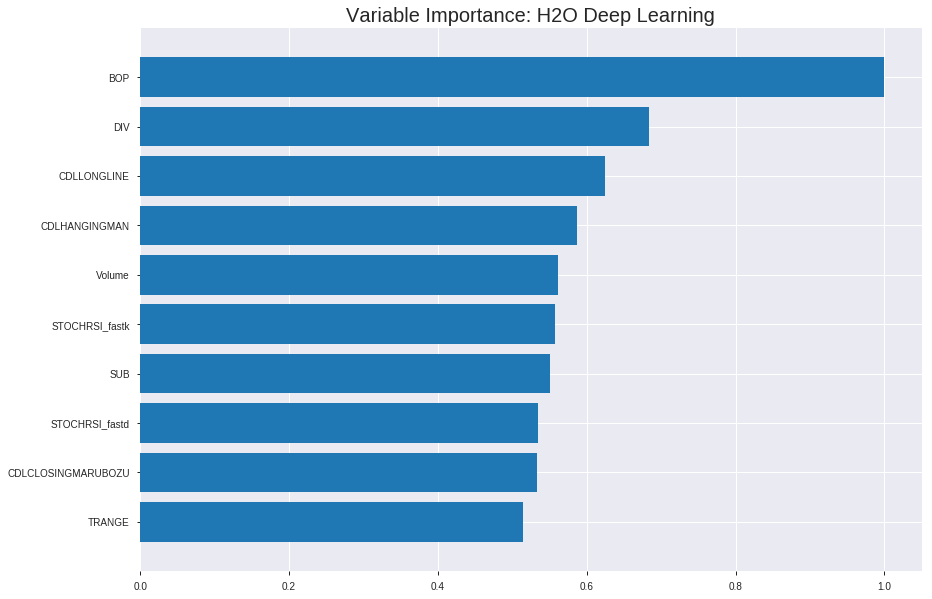

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_140706_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18427278850365925
RMSE: 0.42927006476536334
LogLoss: 0.5459373684594983
Mean Per-Class Error: 0.2686114686114687
AUC: 0.7969193683479397
pr_auc: 0.8081116224100166
Gini: 0.5938387366958795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3982209068832364: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      377  400   0.5148   (400.0/777.0)
1      97   848   0.1026   (97.0/945.0)
Total  474  1248  0.2886   (497.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398221     0.77337   258
max f2                       0.19876      0.87623   333
max f0point5                 0.55427      0.75747   177
max accuracy                 0.518548     0.735192  199
max precision                0.976232     1         0
max recall                   0.0549502    1         381
max specificity              0.976232     1         0
max absolute_mcc             0.518548     0.4641    199
max min_per_class_accuracy   0.541347     0.722751  185
max mean_per_class_accuracy  0.518548     0.731389  199

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.931057           1.82222   1.82222            1                0.952407   1                           0.952407            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.906531           1.50065   1.66603            0.823529         0.919144   0.914286                    0.93625             0.0148148       0.0338624                  50.0654   66.6032
    3        0.0301974                   0.893943           1.71503   1.68205            0.941176         0.899831   0.923077                    0.924344            0.0169312       0.0507937                  71.5033   68.2051
    4        0.0400697                   0.88313            1.50065   1.63736            0.823529         0.887075   0.898551                    0.915162            0.0148148       0.0656085                  50.0654   63.7359
    5        0.0505226                   0.872514           1.51852   1.61277            0.833333         0.878585   0.885057                    0.907594            0.015873        0.0814815                  51.8519   61.2771
    6        0.100465                    0.816131           1.65271   1.63263            0.906977         0.843326   0.895954                    0.875646            0.0825397       0.164021                   65.2713   63.2627
    7        0.150407                    0.755561           1.56796   1.61115            0.860465         0.787264   0.88417                     0.846299            0.0783069       0.242328                   56.7959   61.1154
    8        0.200348                    0.712597           1.39845   1.55813            0.767442         0.731527   0.855072                    0.817689            0.0698413       0.312169                   39.845    55.8132
    9        0.300232                    0.643157           1.40904   1.50853            0.773256         0.676204   0.827853                    0.770619            0.140741        0.45291                    40.9044   50.8532
    10       0.400116                    0.593965           1.3137    1.45989            0.72093          0.618316   0.801161                    0.732598            0.131217        0.584127                   31.3695   45.9894
    11       0.5                         0.549907           1.15478   1.39894            0.633721         0.571736   0.767712                    0.700463            0.115344        0.699471                   15.478    39.8942
    12       0.599884                    0.494728           1.02765   1.33712            0.563953         0.524309   0.733785                    0.671133            0.102646        0.802116                   2.76486   33.712
    13       0.699768                    0.42229            0.773385  1.25665            0.424419         0.461757   0.689627                    0.641247            0.0772487       0.879365                   -22.6615  25.6653
    14       0.799652                    0.314711           0.61447   1.17644            0.337209         0.369917   0.645606                    0.607355            0.0613757       0.940741                   -38.553   17.6438
    15       0.899535                    0.146323           0.434367  1.09404            0.238372         0.234764   0.600387                    0.565983            0.0433862       0.984127                   -56.5633  9.40392
    16       1                           0.00457862         0.157996  1                  0.0867052        0.0803098  0.54878                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2042286154303197
RMSE: 0.4519166022955117
LogLoss: 0.5938892926991591
Mean Per-Class Error: 0.31754679144385034
AUC: 0.7435160427807486
pr_auc: 0.7558366458882414
Gini: 0.48703208556149713
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23243813346229467: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      58   162  0.7364   (162.0/220.0)
1      9    263  0.0331   (9.0/272.0)
Total  67   425  0.3476   (171.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232438     0.754663  337
max f2                       0.0913501    0.872354  381
max f0point5                 0.479091     0.713807  235
max accuracy                 0.479091     0.693089  235
max precision                0.97889      1         0
max recall                   0.0913501    1         381
max specificity              0.97889      1         0
max absolute_mcc             0.479091     0.373772  235
max min_per_class_accuracy   0.536653     0.663636  197
max mean_per_class_accuracy  0.479091     0.682453  235

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.953222           1.44706   1.44706            0.8              0.966607   0.8                         0.966607            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.924872           1.80882   1.62794            1                0.941539   0.9                         0.954073            0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.901137           1.44706   1.56765            0.8              0.90922    0.866667                    0.939122            0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.882502           1.44706   1.5375             0.8              0.891026   0.85                        0.927098            0.0147059       0.0625                     44.7059   53.75
    5        0.050813                    0.866884           1.44706   1.51941            0.8              0.875194   0.84                        0.916717            0.0147059       0.0772059                  44.7059   51.9412
    6        0.101626                    0.798636           1.59176   1.55559            0.88             0.826597   0.86                        0.871657            0.0808824       0.158088                   59.1765   55.5588
    7        0.150407                    0.731029           1.50735   1.53994            0.833333         0.764748   0.851351                    0.836984            0.0735294       0.231618                   50.7353   53.9944
    8        0.20122                     0.699012           1.30235   1.47995            0.72             0.714191   0.818182                    0.805976            0.0661765       0.297794                   30.2353   47.9947
    9        0.300813                    0.621706           1.43968   1.46661            0.795918         0.658202   0.810811                    0.757051            0.143382        0.441176                   43.9676   46.6614
    10       0.400407                    0.581422           1.03361   1.35891            0.571429         0.602251   0.751269                    0.718547            0.102941        0.544118                   3.36134   35.8913
    11       0.5                         0.542473           1.07053   1.30147            0.591837         0.561896   0.719512                    0.687344            0.106618        0.650735                   7.05282   30.1471
    12       0.599593                    0.488893           1.03361   1.25698            0.571429         0.51821    0.694915                    0.659251            0.102941        0.753676                   3.36134   25.6979
    13       0.699187                    0.421212           0.77521   1.18835            0.428571         0.460377   0.656977                    0.630923            0.0772059       0.830882                   -22.479   18.8355
    14       0.79878                     0.328557           0.84904   1.14605            0.469388         0.372416   0.633588                    0.598692            0.0845588       0.915441                   -15.096   14.6048
    15       0.898374                    0.168268           0.553721  1.08038            0.306122         0.255869   0.597285                    0.560686            0.0551471       0.970588                   -44.6279  8.03833
    16       1                           0.0150856          0.289412  1                  0.16             0.0981219  0.552846                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:11:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:11:38  2 min  2.984 sec  1281 obs/sec      1.34669   1             2319       0.474628         0.644372            0.0902549      0.775633        0.788444           1.72099          0.292683                         0.507627           0.726145              -0.0423831       0.737416          0.742434             1.44706            0.347561
    2019-08-26 14:11:45  2 min 10.099 sec  2260 obs/sec      10.8566   8             18695      0.42927          0.545937            0.255826       0.796919        0.808112           1.82222          0.288618                         0.451917           0.593889              0.173857         0.743516          0.755837             1.44706            0.347561
    2019-08-26 14:11:53  2 min 17.186 sec  2549 obs/sec      21.7799   16            37505      0.427592         0.543568            0.261632       0.800626        0.813846           1.82222          0.278165                         0.451324           0.602765              0.176024         0.746524          0.75726              1.44706            0.333333
    2019-08-26 14:12:00  2 min 24.096 sec  2676 obs/sec      32.6231   24            56177      0.414554         0.512846            0.305973       0.818986        0.82797            1.82222          0.25842                          0.448728           0.598517              0.185474         0.74985           0.759006             1.44706            0.304878
    2019-08-26 14:12:06  2 min 30.888 sec  2757 obs/sec      43.4663   32            74849      0.410604         0.50466             0.319137       0.825547        0.836107           1.82222          0.25784                          0.452783           0.61909               0.170687         0.742079          0.749597             1.44706            0.302846
    2019-08-26 14:12:13  2 min 37.527 sec  2821 obs/sec      54.288    40            93484      0.413621         0.511318            0.309094       0.835768        0.845387           1.82222          0.25842                          0.455911           0.62029               0.159188         0.742104          0.754074             1.44706            0.341463
    2019-08-26 14:12:19  2 min 44.046 sec  2876 obs/sec      65.1852   48            112249     0.398506         0.476723            0.358667       0.842972        0.856884           1.82222          0.23403                          0.457086           0.624196              0.15485          0.736857          0.753501             1.44706            0.339431
    2019-08-26 14:12:20  2 min 44.686 sec  2874 obs/sec      65.1852   48            112249     0.42927          0.545937            0.255826       0.796919        0.808112           1.82222          0.288618                         0.451917           0.593889              0.173857         0.743516          0.755837             1.44706            0.347561

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  --------------------
BOP            1.0                    1.0                  0.05231193913310948
DIV            0.6836872696876526     0.6836872696876526   0.03576500683798228
CDLLONGLINE    0.6242077946662903     0.6242077946662903   0.03265352016099547
CDLHANGINGMAN  0.5867255330085754     0.5867255330085754   0.03069275037058581
Volume         0.5610120892524719     0.5610120892524719   0.02934763026591389
---            ---                    ---                  ---
ROC_8          0.40640753507614136    0.40640753507614136  0.02125996623814016
ROCP_8         0.40403562784194946    0.40403562784194946  0.021135887171275732
ROCR_8         0.4028589129447937     0.4028589129447937   0.021074330933198698
CDLMARUBOZU    0.40071186423301697    0.40071186423301697  0.02096201465167241
CMO_8          0.375596284866333      0.375596284866333    0.01964816999254966


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7165991902834008)

('F1', 0.7153284671532847)

('auc', 0.7638339920948616)

('logloss', 0.61082366259627)

('mean_per_class_error', 0.2825098814229249)

('rmse', 0.45442713034794285)

('mse', 0.20650401679626626)

deeplearning prediction progress: |███████████████████████████████████████| 100%


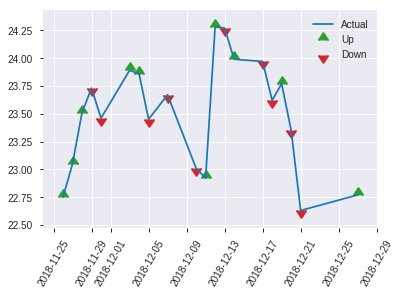


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20650401679626626
RMSE: 0.45442713034794285
LogLoss: 0.61082366259627
Mean Per-Class Error: 0.2825098814229249
AUC: 0.7638339920948616
pr_auc: 0.7106649651479897
Gini: 0.5276679841897232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2431225631938001: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   61   0.4621   (61.0/132.0)
1      17   98   0.1478   (17.0/115.0)
Total  88   159  0.3158   (78.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243123     0.715328  158
max f2                       0.0510386    0.830925  231
max f0point5                 0.356274     0.693739  118
max accuracy                 0.356274     0.716599  118
max precision                0.984491     1         0
max recall                   0.0510386    1         231
max specificity              0.984491     1         0
max absolute_mcc             0.345276     0.433952  122
max min_per_class_accuracy   0.356274     0.713043  118
max mean_per_class_accuracy  0.345276     0.71749   122

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 38.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.960609           1.43188   1.43188            0.666667         0.971785   0.666667                    0.971785            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.933041           1.07391   1.2887             0.5              0.946004   0.6                         0.961473            0.00869565      0.026087                   7.3913    28.8696
    3        0.0323887                   0.901188           2.14783   1.61087            1                0.917837   0.75                        0.945109            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.872617           2.14783   1.71826            1                0.893552   0.8                         0.934798            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.849518           2.14783   1.81739            1                0.861162   0.846154                    0.917805            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.756305           1.96884   1.89009            0.916667         0.799743   0.88                        0.861135            0.0956522       0.191304                   96.8841   89.0087
    7        0.149798                    0.667162           1.43188   1.74148            0.666667         0.706522   0.810811                    0.81099             0.0695652       0.26087                    43.1884   74.1481
    8        0.202429                    0.637725           1.65217   1.71826            0.769231         0.650043   0.8                         0.769144            0.0869565       0.347826                   65.2174   71.8261
    9        0.299595                    0.52558            1.34239   1.59636            0.625            0.584775   0.743243                    0.709349            0.130435        0.478261                   34.2391   59.6357
    10       0.40081                     0.431901           1.20278   1.49697            0.56             0.480339   0.69697                     0.651518            0.121739        0.6                        20.2783   49.697
    11       0.502024                    0.342236           1.2887    1.45498            0.6              0.386354   0.677419                    0.598057            0.130435        0.730435                   28.8696   45.4979
    12       0.59919                     0.268086           0.626449  1.32062            0.291667         0.309159   0.614865                    0.551209            0.0608696       0.791304                   -37.3551  32.0623
    13       0.700405                    0.198346           0.687304  1.2291             0.32             0.235039   0.572254                    0.50552             0.0695652       0.86087                    -31.2696  22.9103
    14       0.797571                    0.117107           0.626449  1.15568            0.291667         0.147538   0.538071                    0.461908            0.0608696       0.921739                   -37.3551  15.5683
    15       0.898785                    0.0672712          0.515478  1.08359            0.24             0.0918692  0.504505                    0.420237            0.0521739       0.973913                   -48.4522  8.35879
    16       1                           0.0206765          0.257739  1                  0.12             0.0442124  0.465587                    0

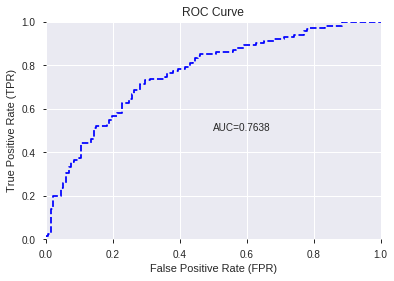

This function is available for GLM models only


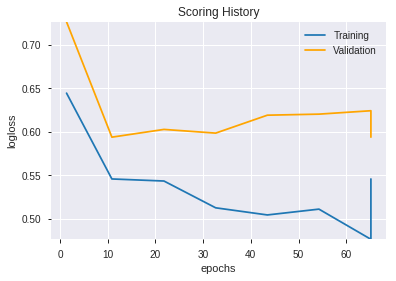

--2019-08-26 14:17:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


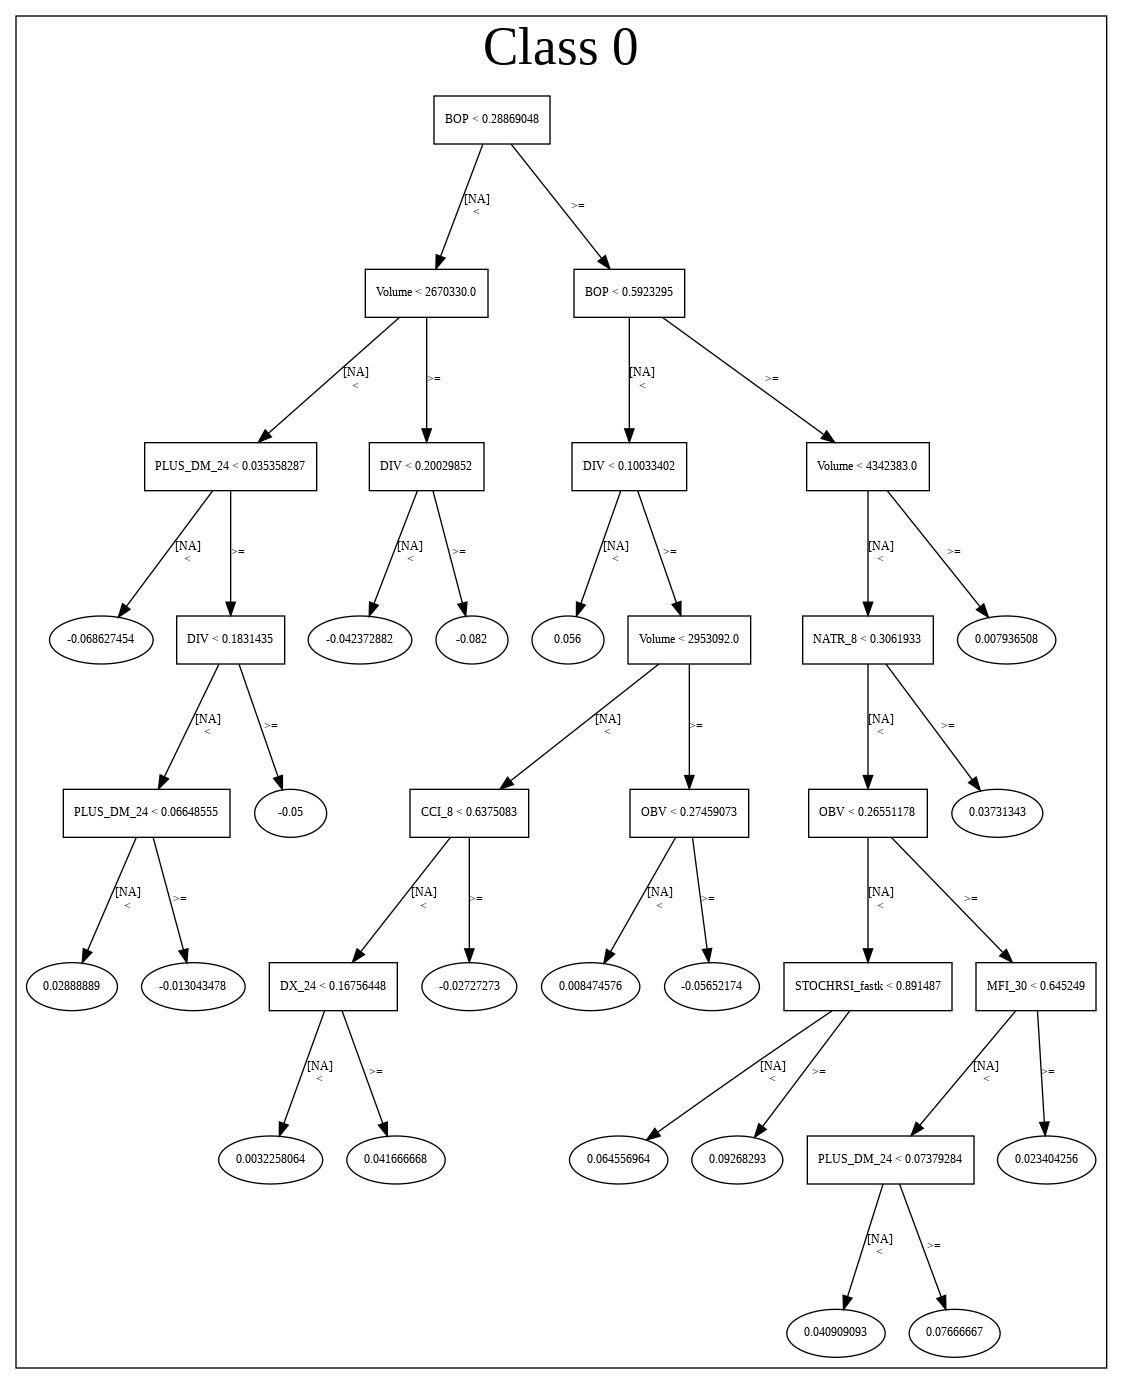

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_140706_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_140706_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'Volume',
 'STOCHRSI_fastk',
 'SUB',
 'STOCHRSI_fastd',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'STOCHF_fastk',
 'NATR_8',
 'CDLSHORTLINE',
 'ULTOSC',
 'WILLR_12',
 'STOCH_slowk',
 'CDLENGULFING',
 'STOCHF_fastd',
 'CCI_8',
 'WILLR_24',
 'WILLR_20',
 'CMO_12',
 'RSI_14',
 'WILLR_8',
 'RSI_8',
 'RSI_12',
 'WILLR_30',
 'WILLR_14',
 'CCI_12',
 'CMO_14',
 'CCI_20',
 'CDLBELTHOLD',
 'MOM_8',
 'ROCR100_8',
 'CCI_14',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'CDLMARUBOZU',
 'CMO_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_141755_model_1  0.794928  0.563305              0.286594  0.431756  0.186413

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.826251           1.000000    0.100197
1               CMO_12             0.781221           0.945500    0.094736
2               CMO_14             0.771577           0.933829    0.093567
3               RSI_14             0.490918           0.594151    0.059532
4               CCI_14             0.473697           0.573308    0.057444
5         STOCHF_fastk             0.442641           0.535722    0.053678
6                  DIV             0.417549           0.505354    0.050635
7               RSI_12             0.383585           0.464247    0.046516
8               CCI_12             0.364737           0.441435    0.044230
9                CCI_8             0.328500           0.397578    0.039836
10        STOCHF_fastd             0.241222           0.291948    0.029252
11         STOCH_slowk             0.228272           0.276275    0.027682
12                 SUB             0.222641           0.269459    0.026999
13            WILLR_12             0.196482           0.237800    0.023827
14            WILLR_24             0.187495           0.226923    0.022737
15       CDLHANGINGMAN             0.177989           0.215417    0.021584
16               RSI_8             0.158296           0.191583    0.019196
17            WILLR_14             0.152251           0.184267    0.018463
18              NATR_8             0.141324           0.171043    0.017138
19         CDLLONGLINE             0.128699           0.155763    0.015607
20              ULTOSC             0.124554           0.150746    0.015104
21               MOM_8             0.112127           0.135706    0.013597
22            WILLR_30             0.111216           0.134603    0.013487
23              Volume             0.101084           0.122341    0.012258
24              TRANGE             0.100119           0.121173    0.012141
25             WILLR_8             0.098327           0.119003    0.011924
26      STOCHRSI_fastd             0.094268           0.114092    0.011432
27              CCI_20             0.089613           0.108458    0.010867
28         CDLBELTHOLD             0.070510           0.085337    0.008550
29        CDLSHORTLINE             0.049644           0.060084    0.006020
30        CDLENGULFING             0.038632           0.046755    0.004685
31               CMO_8             0.037750           0.045689    0.004578
32            WILLR_20             0.036114           0.043708    0.004379
33  CDLCLOSINGMARUBOZU             0.021366           0.025859    0.002591
34      STOCHRSI_fastk             0.013039           0.015782    0.001581
35           ROCR100_8             0.008625           0.010439    0.001046
36              ROCR_8             0.008225           0.009955    0.000997
37              ROCP_8             0.007694           0.009312    0.000933
38               ROC_8             0.006766           0.008188    0.000820
39         CDLMARUBOZU             0.001263           0.001528    0.000153

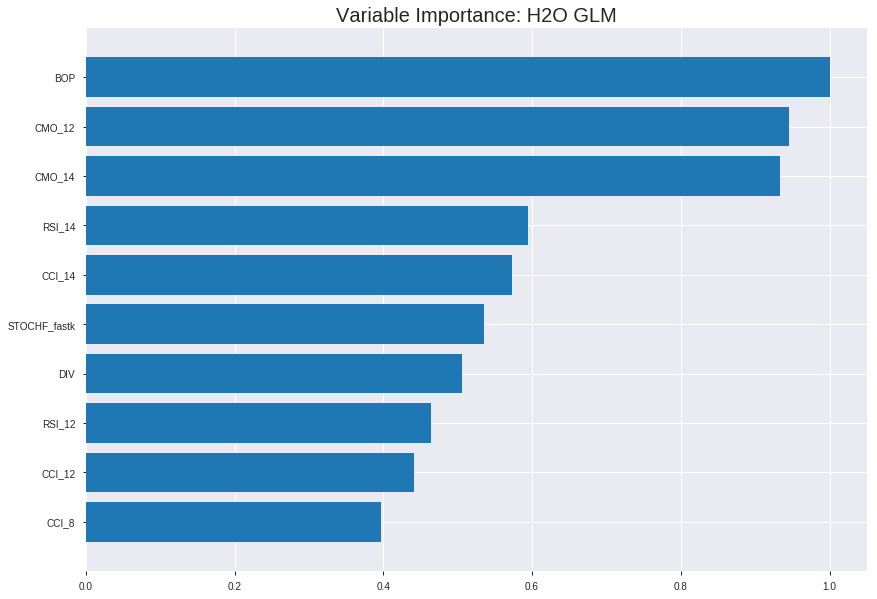

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_141755_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18404343793934397
RMSE: 0.429002841411737
LogLoss: 0.549426083304038
Null degrees of freedom: 1721
Residual degrees of freedom: 1681
Null deviance: 2370.782545663055
Residual deviance: 1892.223430899107
AIC: 1974.223430899107
AUC: 0.790745847888705
pr_auc: 0.795945314193748
Gini: 0.5814916957774099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43397726941154524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  327   0.4208   (327.0/777.0)
1      136  809   0.1439   (136.0/945.0)
Total  586  1136  0.2689   (463.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433977     0.777511  243
max f2                       0.189759     0.869688  341
max f0point5                 0.564136     0.764588  189
max accuracy                 0.554628     0.73403   193
max precision                0.959091     1         0
max recall                   0.0531752    1         390
max specificity              0.959091     1         0
max absolute_mcc             0.564136     0.466885  189
max min_per_class_accuracy   0.55654      0.730159  192
max mean_per_class_accuracy  0.564136     0.734492  189

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.937525           1.82222   1.82222            1                0.941833  1                           0.941833            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.922735           1.60784   1.7181             0.882353         0.931145  0.942857                    0.936642            0.015873        0.0349206                  60.7843   71.8095
    3        0.0301974                   0.913297           1.60784   1.68205            0.882353         0.917493  0.923077                    0.930382            0.015873        0.0507937                  60.7843   68.2051
    4        0.0400697                   0.905994           1.71503   1.69018            0.941176         0.909703  0.927536                    0.925287            0.0169312       0.0677249                  71.5033   69.0177
    5        0.0505226                   0.895716           1.21481   1.59183            0.666667         0.900923  0.873563                    0.920246            0.0126984       0.0804233                  21.4815   59.1826
    6        0.100465                    0.860481           1.50439   1.54836            0.825581         0.877328  0.849711                    0.898911            0.0751323       0.155556                   50.4393   54.8362
    7        0.150407                    0.830563           1.50439   1.53376            0.825581         0.845416  0.841699                    0.881148            0.0751323       0.230688                   50.4393   53.3762
    8        0.200348                    0.8016             1.50439   1.52644            0.825581         0.816472  0.837681                    0.865026            0.0751323       0.30582                    50.4393   52.6441
    9        0.300232                    0.734016           1.44083   1.49796            0.790698         0.76784   0.82205                     0.832694            0.143915        0.449735                   44.0827   49.7958
    10       0.400116                    0.657969           1.32429   1.4546             0.726744         0.701283  0.798258                    0.799889            0.132275        0.582011                   32.4289   45.4604
    11       0.5                         0.571867           1.25013   1.41376            0.686047         0.613862  0.775842                    0.762726            0.124868        0.706878                   25.0129   41.3757
    12       0.599884                    0.488136           0.953488  1.33712            0.523256         0.532999  0.733785                    0.724476            0.0952381       0.802116                   -4.65116  33.712
    13       0.699768                    0.398798           0.741602  1.25212            0.406977         0.44394   0.687137                    0.684432            0.0740741       0.87619                    -25.8398  25.2116
    14       0.799652                    0.291013           0.572093  1.16718            0.313953         0.347273  0.640523                    0.642318            0.0571429       0.933333                   -42.7907  16.7175
    15       0.899535                    0.179492           0.455556  1.08816            0.25             0.23595   0.597159                    0.597195            0.0455026       0.978836                   -54.4444  8.81572
    16       1                           0.00248032         0.210662  1                  0.115607         0.115286  0.54878                     0.54878           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19618179092306864
RMSE: 0.44292413675828124
LogLoss: 0.5762913693372899
Null degrees of freedom: 491
Residual degrees of freedom: 451
Null deviance: 676.5834633095117
Residual deviance: 567.0707074278931
AIC: 649.0707074278931
AUC: 0.7616560828877005
pr_auc: 0.7676712222209869
Gini: 0.523312165775401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4030725948327244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  119  0.5409   (119.0/220.0)
1      28   244  0.1029   (28.0/272.0)
Total  129  363  0.2988   (147.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403073     0.768504  288
max f2                       0.159577     0.87153   370
max f0point5                 0.608439     0.741186  196
max accuracy                 0.461855     0.707317  261
max precision                0.941435     1         0
max recall                   0.123004     1         382
max specificity              0.941435     1         0
max absolute_mcc             0.608439     0.409671  196
max min_per_class_accuracy   0.581521     0.7       207
max mean_per_class_accuracy  0.608439     0.705983  196

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 56.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.926794           1.80882   1.80882            1                0.934175  1                           0.934175            0.0183824       0.0183824                  80.8824   80.8824
    2        0.0203252                   0.907412           1.44706   1.62794            0.8              0.91897   0.9                         0.926572            0.0147059       0.0330882                  44.7059   62.7941
    3        0.0304878                   0.895922           1.44706   1.56765            0.8              0.902924  0.866667                    0.91869             0.0147059       0.0477941                  44.7059   56.7647
    4        0.0406504                   0.887791           0.723529  1.35662            0.4              0.892841  0.75                        0.912227            0.00735294      0.0551471                  -27.6471  35.6618
    5        0.050813                    0.880437           1.44706   1.37471            0.8              0.884642  0.76                        0.90671             0.0147059       0.0698529                  44.7059   37.4706
    6        0.101626                    0.8347             1.59176   1.48324            0.88             0.855687  0.82                        0.881199            0.0808824       0.150735                   59.1765   48.3235
    7        0.150407                    0.808335           1.58272   1.5155             0.875            0.823018  0.837838                    0.862329            0.0772059       0.227941                   58.2721   51.5501
    8        0.20122                     0.781259           1.66412   1.55303            0.92             0.794719  0.858586                    0.845256            0.0845588       0.3125                     66.4118   55.303
    9        0.300813                    0.732095           1.2551    1.45439            0.693878         0.750138  0.804054                    0.813764            0.125           0.4375                     25.5102   45.4392
    10       0.400407                    0.669217           1.2551    1.40482            0.693878         0.698213  0.77665                     0.785023            0.125           0.5625                     25.5102   40.4822
    11       0.5                         0.600497           1.18127   1.36029            0.653061         0.639507  0.752033                    0.756038            0.117647        0.680147                   18.1273   36.0294
    12       0.599593                    0.517284           0.885954  1.28151            0.489796         0.561883  0.708475                    0.723788            0.0882353       0.768382                   -11.4046  28.1505
    13       0.699187                    0.434524           0.922869  1.23042            0.510204         0.475587  0.680233                    0.688434            0.0919118       0.860294                   -7.71309  23.0421
    14       0.79878                     0.339094           0.627551  1.15525            0.346939         0.386103  0.638677                    0.650739            0.0625          0.922794                   -37.2449  15.5254
    15       0.898374                    0.212591           0.479892  1.08038            0.265306         0.277621  0.597285                    0.609375            0.0477941       0.970588                   -52.0108  8.03833
    16       1                           0.0165949          0.289412  1                  0.16             0.133305  0.552846                    0.560994          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 14:17:55  0.000 sec   2            .22E2     41            1.3530143017570258  1.3542373156134067
     2019-08-26 14:17:55  0.010 sec   4            .14E2     41            1.3420139657017534  1.3446486952605978
     2019-08-26 14:17:55  0.020 sec   6            .84E1     41            1.327513061665445   1.3320993705115447
     2019-08-26 14:17:55  0.030 sec   8            .52E1     41            1.309251842468735   1.316443299756386
     2019-08-26 14:17:55  0.037 sec   10           .33E1     41            1.2871047258342254  1.297701294916736
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 14:17:55  0.227 sec   44           .24E-3    41            1.0990345324339938  1.152637390285761
     2019-08-26 14:17:55  0.236 sec   45           .15E-3    41            1.0989441164890876  1.1525832426196159
     2019-08-26 14:17:55  0.245 sec   46           .91E-4    41            1.098852166608076   1.1525827386745795
     2019-08-26 14:17:55  0.254 sec   47           .57E-4    41            1.098756529335008   1.1526280583317088
     2019-08-26 14:17:55  0.263 sec   48           .35E-4    41            1.0986589797146173  1.152710592202154


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7449392712550608)

('F1', 0.7265917602996256)

('auc', 0.7949275362318841)

('logloss', 0.5633053442213284)

('mean_per_class_error', 0.2571146245059288)

('rmse', 0.43175629086833545)

('mse', 0.1864134947043827)

glm prediction progress: |████████████████████████████████████████████████| 100%


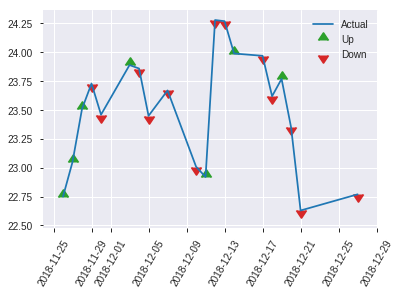


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1864134947043827
RMSE: 0.43175629086833545
LogLoss: 0.5633053442213284
Null degrees of freedom: 246
Residual degrees of freedom: 206
Null deviance: 348.1046065632917
Residual deviance: 278.27284004533624
AIC: 360.27284004533624
AUC: 0.7949275362318841
pr_auc: 0.7515292263534586
Gini: 0.5898550724637681
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30683916125487287: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   55   0.4167   (55.0/132.0)
1      18   97   0.1565   (18.0/115.0)
Total  95   152  0.2955   (73.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306839     0.726592  151
max f2                       0.175233     0.839695  194
max f0point5                 0.445947     0.728242  111
max accuracy                 0.445947     0.744939  111
max precision                0.892422     1         0
max recall                   0.0162668    1         244
max specificity              0.892422     1         0
max absolute_mcc             0.445947     0.486734  111
max min_per_class_accuracy   0.391291     0.734848  119
max mean_per_class_accuracy  0.445947     0.742885  111

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 41.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.859158           1.43188   1.43188            0.666667         0.878467   0.666667                    0.878467            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.837722           2.14783   1.71826            1                0.850993   0.8                         0.867477            0.0173913       0.0347826                  114.783   71.8261
    3        0.0323887                   0.824647           1.43188   1.61087            0.666667         0.829973   0.75                        0.853413            0.0173913       0.0521739                  43.1884   61.087
    4        0.0404858                   0.814855           2.14783   1.71826            1                0.819805   0.8                         0.846691            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.805065           2.14783   1.81739            1                0.812743   0.846154                    0.838857            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.754021           2.14783   1.976              1                0.773893   0.92                        0.807675            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.717771           1.78986   1.91563            0.833333         0.74142    0.891892                    0.786187            0.0869565       0.286957                   78.9855   91.5629
    8        0.202429                    0.657484           1.48696   1.80417            0.692308         0.689512   0.84                        0.761051            0.0782609       0.365217                   48.6957   80.4174
    9        0.299595                    0.592681           1.34239   1.65441            0.625            0.628598   0.77027                     0.718093            0.130435        0.495652                   34.2391   65.4407
    10       0.40081                     0.496676           1.37461   1.58375            0.64             0.544404   0.737374                    0.674232            0.13913         0.634783                   37.4609   58.3751
    11       0.502024                    0.382038           1.11687   1.48962            0.52             0.440128   0.693548                    0.627034            0.113043        0.747826                   11.687    48.9621
    12       0.59919                     0.31264            0.715942  1.36416            0.333333         0.33894    0.635135                    0.580316            0.0695652       0.817391                   -28.4058  36.416
    13       0.700405                    0.257908           0.601391  1.25393            0.28             0.289596   0.583815                    0.538304            0.0608696       0.878261                   -39.8609  25.3933
    14       0.797571                    0.163389           0.805435  1.19929            0.375            0.215665   0.558376                    0.498998            0.0782609       0.956522                   -19.4565  19.9294
    15       0.898785                    0.0976696          0.171826  1.08359            0.08             0.133158   0.504505                    0.4578              0.0173913       0.973913                   -82.8174  8.35879
    16       1                           0.000558394        0.257739  1                  0.12             0.0567901  0.465587                    0.41

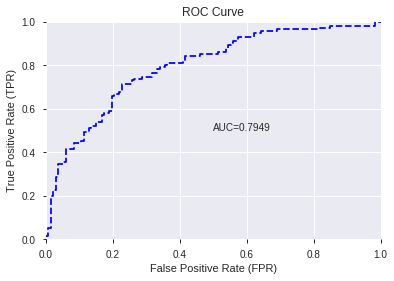

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


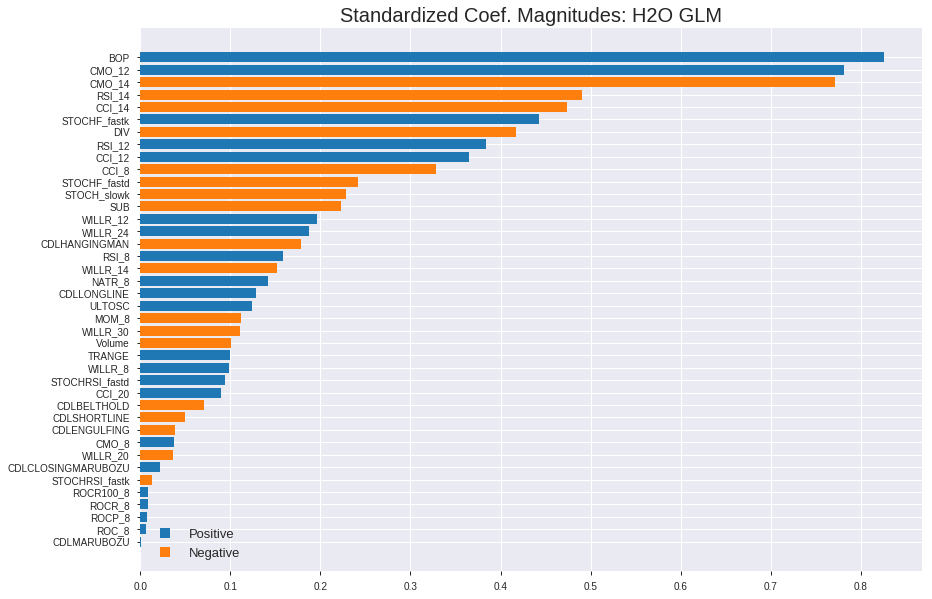

'log_likelihood'
--2019-08-26 14:17:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


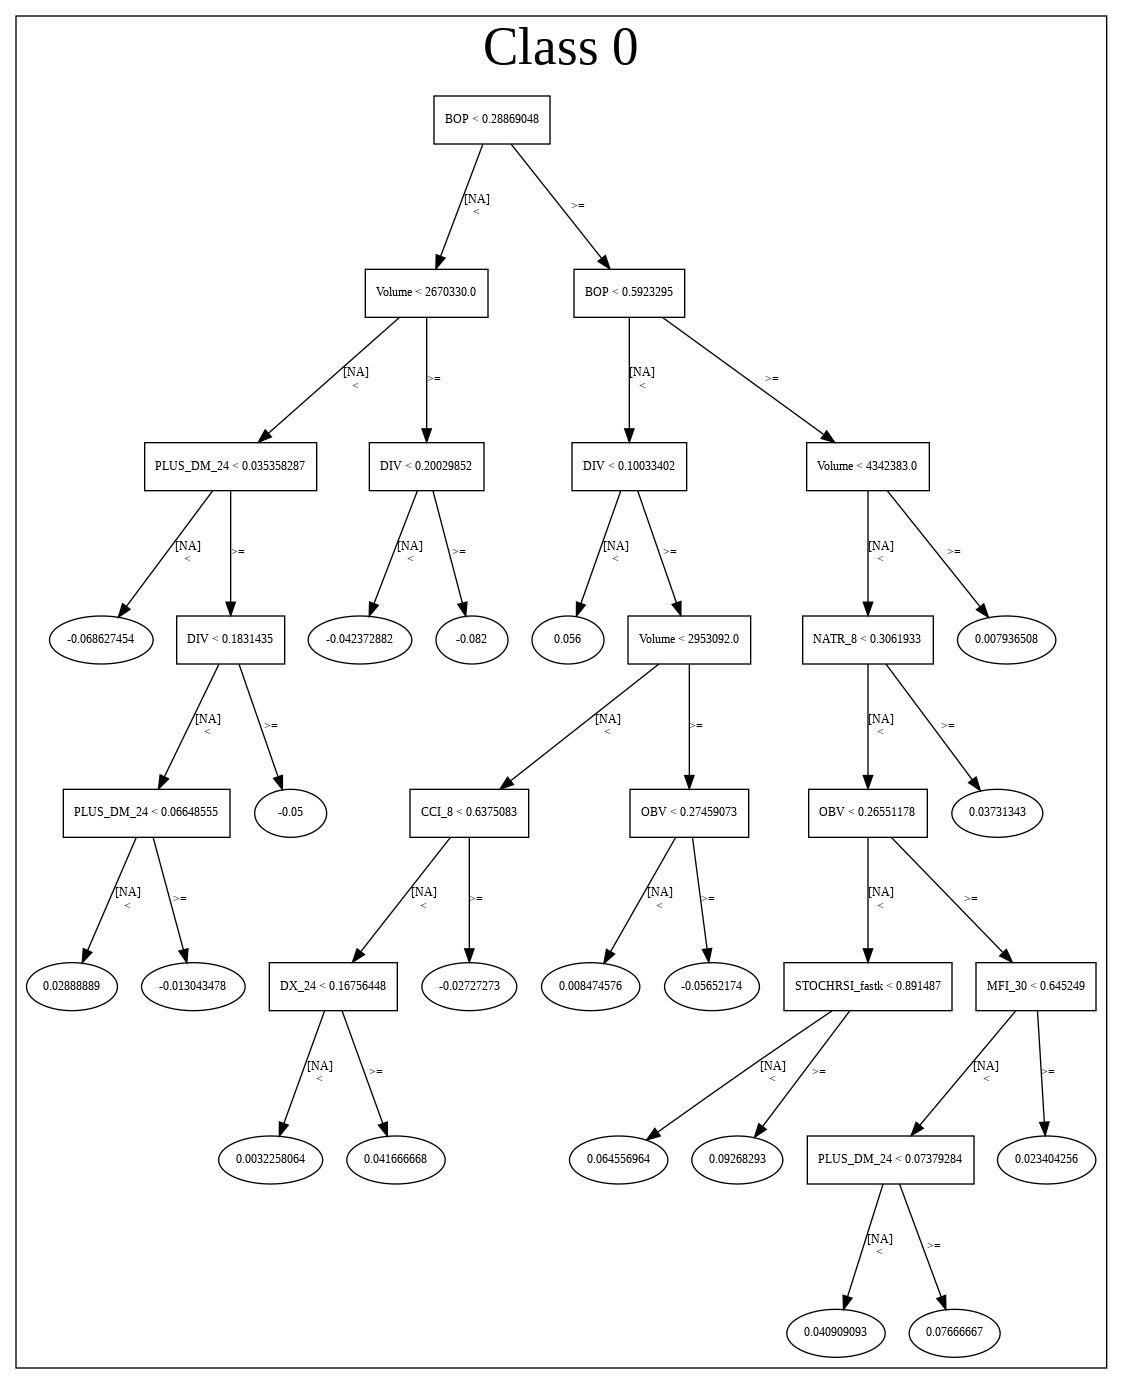

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_141755_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_141755_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CMO_12',
 'CMO_14',
 'RSI_14',
 'CCI_14',
 'STOCHF_fastk',
 'DIV',
 'RSI_12',
 'CCI_12',
 'CCI_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'SUB',
 'WILLR_12',
 'WILLR_24',
 'CDLHANGINGMAN',
 'RSI_8',
 'WILLR_14',
 'NATR_8',
 'CDLLONGLINE',
 'ULTOSC',
 'MOM_8',
 'WILLR_30',
 'Volume',
 'TRANGE',
 'WILLR_8',
 'STOCHRSI_fastd',
 'CCI_20',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CMO_8',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'CDLMARUBOZU']

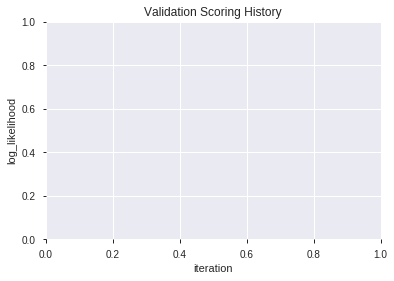

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_141807_model_4  0.777734  0.573373              0.276219  0.440508  0.194047
1  XGBoost_grid_1_AutoML_20190826_141807_model_2  0.776746  0.581026              0.308630  0.444863  0.197903
2  XGBoost_grid_1_AutoML_20190826_141807_model_6  0.776021  0.578458              0.315086  0.443660  0.196834
3               XGBoost_3_AutoML_20190826_141807  0.774111  0.577355              0.284914  0.442834  0.196102
4               XGBoost_2_AutoML_20190826_141807  0.771937  0.578896              0.294038  0.443458  0.196655
5  XGBoost_grid_1_AutoML_20190826_141807_model_3  0.764888  0.577381              0.305402  0.444297  0.197400
6  XGBoost_grid_1_AutoML_20190826_141807_model_1  0.764361  0.583140              0.309750  0.444570  0.197642
7               XGBoost_1_AutoML_20190826_141807  0.761397  0.585362              0.311430  0.447111  0.199908
8  XGBoost_grid_1_AutoML_20190826_141807_model_7  0.754941  0.584819              0.300758  0.447831  0.200552
9  XGBoost_grid_1_AutoML_20190826_141807_model_5  0.738801  0.599973              0.347200  0.455014  0.207038

variable  relative_importance  scaled_importance  percentage
0              BOP          2506.120117           1.000000    0.467007
1              DIV           604.834961           0.241343    0.112709
2     STOCHF_fastk           314.794006           0.125610    0.058661
3           Volume           217.907104           0.086950    0.040606
4              SUB           190.653015           0.076075    0.035528
5            CCI_8           175.735352           0.070122    0.032748
6      STOCH_slowk           163.522476           0.065249    0.030472
7   STOCHRSI_fastk           151.207535           0.060335    0.028177
8           NATR_8           134.185425           0.053543    0.025005
9           CMO_14           100.787956           0.040217    0.018782
10          TRANGE            94.938965           0.037883    0.017692
11          ULTOSC            71.680626           0.028602    0.013357
12        WILLR_30            63.987747           0.025533    0.011924
13        WILLR_20            62.789272           0.025054    0.011701
14          CCI_14            61.274139           0.024450    0.011418
15          CCI_12            57.584278           0.022977    0.010731
16  STOCHRSI_fastd            53.829483           0.021479    0.010031
17           ROC_8            51.655571           0.020612    0.009626
18        WILLR_24            47.185242           0.018828    0.008793
19          CCI_20            44.769539           0.017864    0.008343
20          CMO_12            43.966793           0.017544    0.008193
21           CMO_8            35.220192           0.014054    0.006563
22         WILLR_8            34.924347           0.013936    0.006508
23        WILLR_14            32.065704           0.012795    0.005975
24           MOM_8            28.086060           0.011207    0.005234
25        WILLR_12            11.964062           0.004774    0.002229
26     CDLLONGLINE            10.669304           0.004257    0.001988

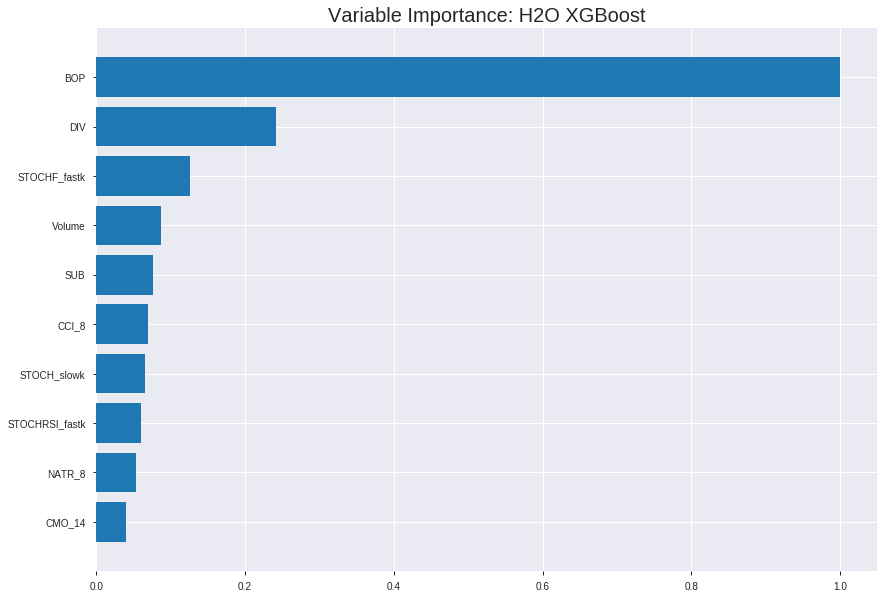

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_141807_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1671749494311942
RMSE: 0.40887033327351374
LogLoss: 0.5084708693694734
Mean Per-Class Error: 0.2359073359073358
AUC: 0.8335103811294288
pr_auc: 0.8462467237128665
Gini: 0.6670207622588575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47293558716773987: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      499  278   0.3578   (278.0/777.0)
1      137  808   0.145    (137.0/945.0)
Total  636  1086  0.241    (415.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472936     0.795667  225
max f2                       0.278369     0.881844  314
max f0point5                 0.656017     0.790581  132
max accuracy                 0.565399     0.764808  180
max precision                0.898293     1         0
max recall                   0.110557     1         384
max specificity              0.898293     1         0
max absolute_mcc             0.565399     0.526821  180
max min_per_class_accuracy   0.570983     0.761905  177
max mean_per_class_accuracy  0.565399     0.764093  180

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.881941           1.82222   1.82222            1                0.887306  1                           0.887306            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.865909           1.71503   1.77016            0.941176         0.873182  0.971429                    0.880445            0.0169312       0.0359788                  71.5033   77.0159
    3        0.0301974                   0.861237           1.82222   1.78718            1                0.86341   0.980769                    0.874876            0.0179894       0.0539683                  82.2222   78.7179
    4        0.0400697                   0.855701           1.82222   1.79581            1                0.858126  0.985507                    0.870749            0.0179894       0.0719577                  82.2222   79.5813
    5        0.0505226                   0.848958           1.61975   1.75939            0.888889         0.852065  0.965517                    0.866883            0.0169312       0.0888889                  61.9753   75.9387
    6        0.100465                    0.831503           1.65271   1.70636            0.906977         0.840237  0.936416                    0.853637            0.0825397       0.171429                   65.2713   70.6358
    7        0.150407                    0.810664           1.58915   1.66744            0.872093         0.821237  0.915058                    0.842879            0.0793651       0.250794                   58.9147   66.7439
    8        0.200348                    0.791608           1.58915   1.64792            0.872093         0.801784  0.904348                    0.832635            0.0793651       0.330159                   58.9147   64.7923
    9        0.300232                    0.737383           1.41964   1.57198            0.77907          0.764975  0.862669                    0.810125            0.141799        0.471958                   41.9638   57.1975
    10       0.400116                    0.665701           1.43023   1.53659            0.784884         0.704871  0.843251                    0.78385             0.142857        0.614815                   43.0233   53.6591
    11       0.5                         0.587796           1.17597   1.46455            0.645349         0.627145  0.803717                    0.752545            0.11746         0.732275                   17.5969   46.455
    12       0.599884                    0.500667           0.921705  1.37416            0.505814         0.545716  0.754114                    0.718107            0.0920635       0.824339                   -7.82946  37.4164
    13       0.699768                    0.405822           0.741602  1.28387            0.406977         0.452615  0.704564                    0.680211            0.0740741       0.898413                   -25.8398  28.3873
    14       0.799652                    0.304474           0.572093  1.19496            0.313953         0.353641  0.655773                    0.63942             0.0571429       0.955556                   -42.7907  19.4965
    15       0.899535                    0.181737           0.339018  1.09992            0.186047         0.247119  0.603615                    0.595859            0.0338624       0.989418                   -66.0982  9.99211
    16       1                           0.0800346          0.105331  1                  0.0578035        0.126997  0.54878                     0.548755          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19802816056618716
RMSE: 0.44500355118379353
LogLoss: 0.5795861909067002
Mean Per-Class Error: 0.3105280748663102
AUC: 0.7612550133689839
pr_auc: 0.7891431073593485
Gini: 0.5225100267379679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4334425628185272: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   127  0.5773   (127.0/220.0)
1      25   247  0.0919   (25.0/272.0)
Total  118  374  0.3089   (152.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433443     0.764706  295
max f2                       0.230491     0.868726  376
max f0point5                 0.622066     0.719453  186
max accuracy                 0.516294     0.703252  251
max precision                0.86806      1         0
max recall                   0.136961     1         389
max specificity              0.86806      1         0
max absolute_mcc             0.491347     0.397046  262
max min_per_class_accuracy   0.609277     0.681818  196
max mean_per_class_accuracy  0.516294     0.689472  251

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 57.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.854789           1.80882   1.80882            1                0.860703  1                           0.860703            0.0183824       0.0183824                  80.8824    80.8824
    2        0.0203252                   0.844142           1.80882   1.80882            1                0.849289  1                           0.854996            0.0183824       0.0367647                  80.8824    80.8824
    3        0.0304878                   0.834905           1.44706   1.68824            0.8              0.840267  0.933333                    0.850086            0.0147059       0.0514706                  44.7059    68.8235
    4        0.0406504                   0.829737           1.80882   1.71838            1                0.831595  0.95                        0.845463            0.0183824       0.0698529                  80.8824    71.8382
    5        0.050813                    0.827382           1.08529   1.59176            0.6              0.828226  0.88                        0.842016            0.0110294       0.0808824                  8.52941    59.1765
    6        0.101626                    0.810051           1.73647   1.66412            0.96             0.820247  0.92                        0.831131            0.0882353       0.169118                   73.6471    66.4118
    7        0.150407                    0.791341           1.50735   1.61328            0.833333         0.79997   0.891892                    0.821025            0.0735294       0.242647                   50.7353    61.3275
    8        0.20122                     0.765493           1.59176   1.60784            0.88             0.780842  0.888889                    0.810878            0.0808824       0.323529                   59.1765    60.7843
    9        0.300813                    0.708532           1.2551    1.49106            0.693878         0.733063  0.824324                    0.785115            0.125           0.448529                   25.5102    49.1057
    10       0.400407                    0.67056            1.07053   1.38646            0.591837         0.688924  0.766497                    0.761189            0.106618        0.555147                   7.05282    38.6459
    11       0.5                         0.620301           1.07053   1.32353            0.591837         0.65105   0.731707                    0.739251            0.106618        0.661765                   7.05282    32.3529
    12       0.599593                    0.545984           0.996699  1.26924            0.55102          0.583018  0.701695                    0.7133              0.0992647       0.761029                   -0.330132  26.9242
    13       0.699187                    0.477952           0.959784  1.22516            0.530612         0.512673  0.677326                    0.684723            0.0955882       0.856618                   -4.02161   22.5162
    14       0.79878                     0.393681           0.664466  1.15525            0.367347         0.439243  0.638677                    0.654116            0.0661765       0.922794                   -33.5534   15.5254
    15       0.898374                    0.287017           0.516807  1.08448            0.285714         0.339497  0.599548                    0.619237            0.0514706       0.974265                   -48.3193   8.44756
    16       1                           0.0911558          0.253235  1                  0.14             0.19993   0.552846                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:18:12  2.301 sec   0                  0.5              0.693147            0.5             0                  1                0.45122                          0.5                0.693147              0.5               0                    1                  0.447154
    2019-08-26 14:18:12  2.349 sec   5                  0.474428         0.642988            0.797916        0.791435           1.51852          0.277584                         0.483959           0.661426              0.750426          0.764472             1.44706            0.315041
    2019-08-26 14:18:12  2.385 sec   10                 0.456203         0.607685            0.805705        0.811648           1.41728          0.295006                         0.471554           0.636983              0.751546          0.776446             1.08529            0.317073
    2019-08-26 14:18:12  2.419 sec   15                 0.443731         0.58303             0.809083        0.816323           1.51852          0.270035                         0.463005           0.619767              0.757487          0.788478             1.44706            0.329268
    2019-08-26 14:18:13  2.456 sec   20                 0.435322         0.565988            0.812646        0.821017           1.72099          0.263647                         0.457126           0.607615              0.76204           0.785168             1.44706            0.310976
    2019-08-26 14:18:13  2.499 sec   25                 0.429373         0.553493            0.815747        0.826302           1.61975          0.263066                         0.452927           0.598681              0.765232          0.788448             1.44706            0.306911
    2019-08-26 14:18:13  2.542 sec   30                 0.424745         0.543496            0.817828        0.831604           1.82222          0.254936                         0.44991            0.591987              0.764973          0.790978             1.80882            0.306911
    2019-08-26 14:18:13  2.589 sec   35                 0.42144          0.536185            0.819577        0.832625           1.72099          0.250871                         0.44816            0.587876              0.763862          0.789987             1.80882            0.304878
    2019-08-26 14:18:13  2.634 sec   40                 0.418675         0.530076            0.822122        0.836724           1.82222          0.249129                         0.446868           0.584858              0.764213          0.788835             1.44706            0.300813
    2019-08-26 14:18:13  2.682 sec   45                 0.416326         0.524913            0.82454         0.836041           1.82222          0.249129                         0.446525           0.583781              0.763035          0.787552             1.80882            0.300813
    2019-08-26 14:18:13  2.727 sec   50                 0.41429          0.520325            0.82684         0.839714           1.82222          0.246225                         0.446351           0.583096              0.76265           0.788343             1.80882            0.300813
    2019-08-26 14:18:13  2.776 sec   55                 0.412099         0.515801            0.830108        0.844699           1.82222          0.246225                         0.446215           0.582538              0.761915          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2506.1201171875        1.0                    0.4670073937508953
DIV           604.8349609375         0.2413431649941335     0.1127090424835026
STOCHF_fastk  314.79400634765625     0.12561010311865445    0.05866084688622402
Volume        217.9071044921875      0.08694998415987112    0.04060628548918305
SUB           190.65301513671875     0.07607497095976373    0.035527573917594306
---           ---                    ---                    ---
WILLR_8       34.924346923828125     0.013935623709458136   0.0065080393088472275
WILLR_14      32.065704345703125     0.012794959078692903   0.005975340492489729
MOM_8         28.0860595703125       0.011206988594717542   0.005233746535415047
WILLR_12      11.964061737060547     0.0047739378711373365  0.002229464283128545
CDLLONGLINE   10.669303894042969     0.004257299488907428   0.0019881903387316767


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7327935222672065)

('F1', 0.7418181818181818)

('auc', 0.777733860342556)

('logloss', 0.5733733538721688)

('mean_per_class_error', 0.2617588932806324)

('rmse', 0.44050755486487153)

('mse', 0.19404690589302778)

xgboost prediction progress: |████████████████████████████████████████████| 100%


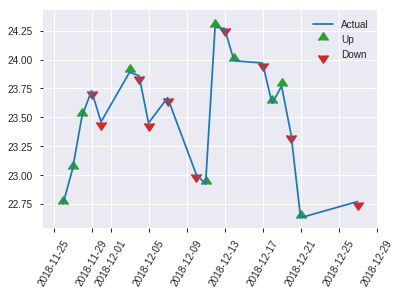


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19404690589302778
RMSE: 0.44050755486487153
LogLoss: 0.5733733538721688
Mean Per-Class Error: 0.2617588932806324
AUC: 0.777733860342556
pr_auc: 0.7026841369353053
Gini: 0.555467720685112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4283130168914795: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   58   0.4394   (58.0/132.0)
1      13   102  0.113    (13.0/115.0)
Total  87   160  0.2874   (71.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428313     0.741818  159
max f2                       0.252928     0.842027  210
max f0point5                 0.488695     0.700447  138
max accuracy                 0.488695     0.732794  138
max precision                0.750346     0.833333  29
max recall                   0.131684     1         238
max specificity              0.826135     0.992424  0
max absolute_mcc             0.488695     0.479141  138
max min_per_class_accuracy   0.532144     0.704545  120
max mean_per_class_accuracy  0.488695     0.738241  138

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.82139            1.43188   1.43188            0.666667         0.823343  0.666667                    0.823343            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.816843           1.07391   1.2887             0.5              0.820029  0.6                         0.822017            0.00869565      0.026087                   7.3913    28.8696
    3        0.0323887                   0.812932           2.14783   1.61087            1                0.815775  0.75                        0.819676            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.810236           2.14783   1.71826            1                0.810741  0.8                         0.817889            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.80446            1.43188   1.65217            0.666667         0.807538  0.769231                    0.8155              0.0173913       0.0869565                  43.1884   65.2174
    6        0.101215                    0.769267           1.78986   1.71826            0.833333         0.785388  0.8                         0.801047            0.0869565       0.173913                   78.9855   71.8261
    7        0.149798                    0.730734           1.78986   1.74148            0.833333         0.748916  0.810811                    0.784139            0.0869565       0.26087                    78.9855   74.1481
    8        0.202429                    0.702402           1.48696   1.6753             0.692308         0.717231  0.78                        0.766743            0.0782609       0.33913                    48.6957   67.5304
    9        0.299595                    0.647502           1.2529    1.53831            0.583333         0.671743  0.716216                    0.735932            0.121739        0.46087                    25.2899   53.8308
    10       0.40081                     0.610125           1.46052   1.51866            0.68             0.628579  0.707071                    0.708823            0.147826        0.608696                   46.0522   51.8665
    11       0.502024                    0.527414           1.03096   1.42034            0.48             0.568737  0.66129                     0.68058             0.104348        0.713043                   3.09565   42.0337
    12       0.59919                     0.463085           1.16341   1.37867            0.541667         0.493923  0.641892                    0.650311            0.113043        0.826087                   16.3406   37.8672
    13       0.700405                    0.367242           0.601391  1.26635            0.28             0.417351  0.589595                    0.616647            0.0608696       0.886957                   -39.8609  26.6348
    14       0.797571                    0.280055           0.626449  1.18839            0.291667         0.324724  0.553299                    0.581082            0.0608696       0.947826                   -37.3551  18.8391
    15       0.898785                    0.223745           0.343652  1.09326            0.16             0.252572  0.509009                    0.544088            0.0347826       0.982609                   -65.6348  9.32628
    16       1                           0.115144           0.171826  1                  0.08             0.170549  0.465587                    0.50628           

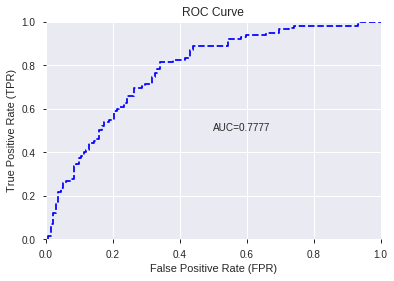

This function is available for GLM models only


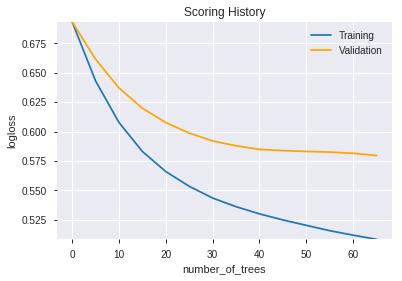

--2019-08-26 14:18:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

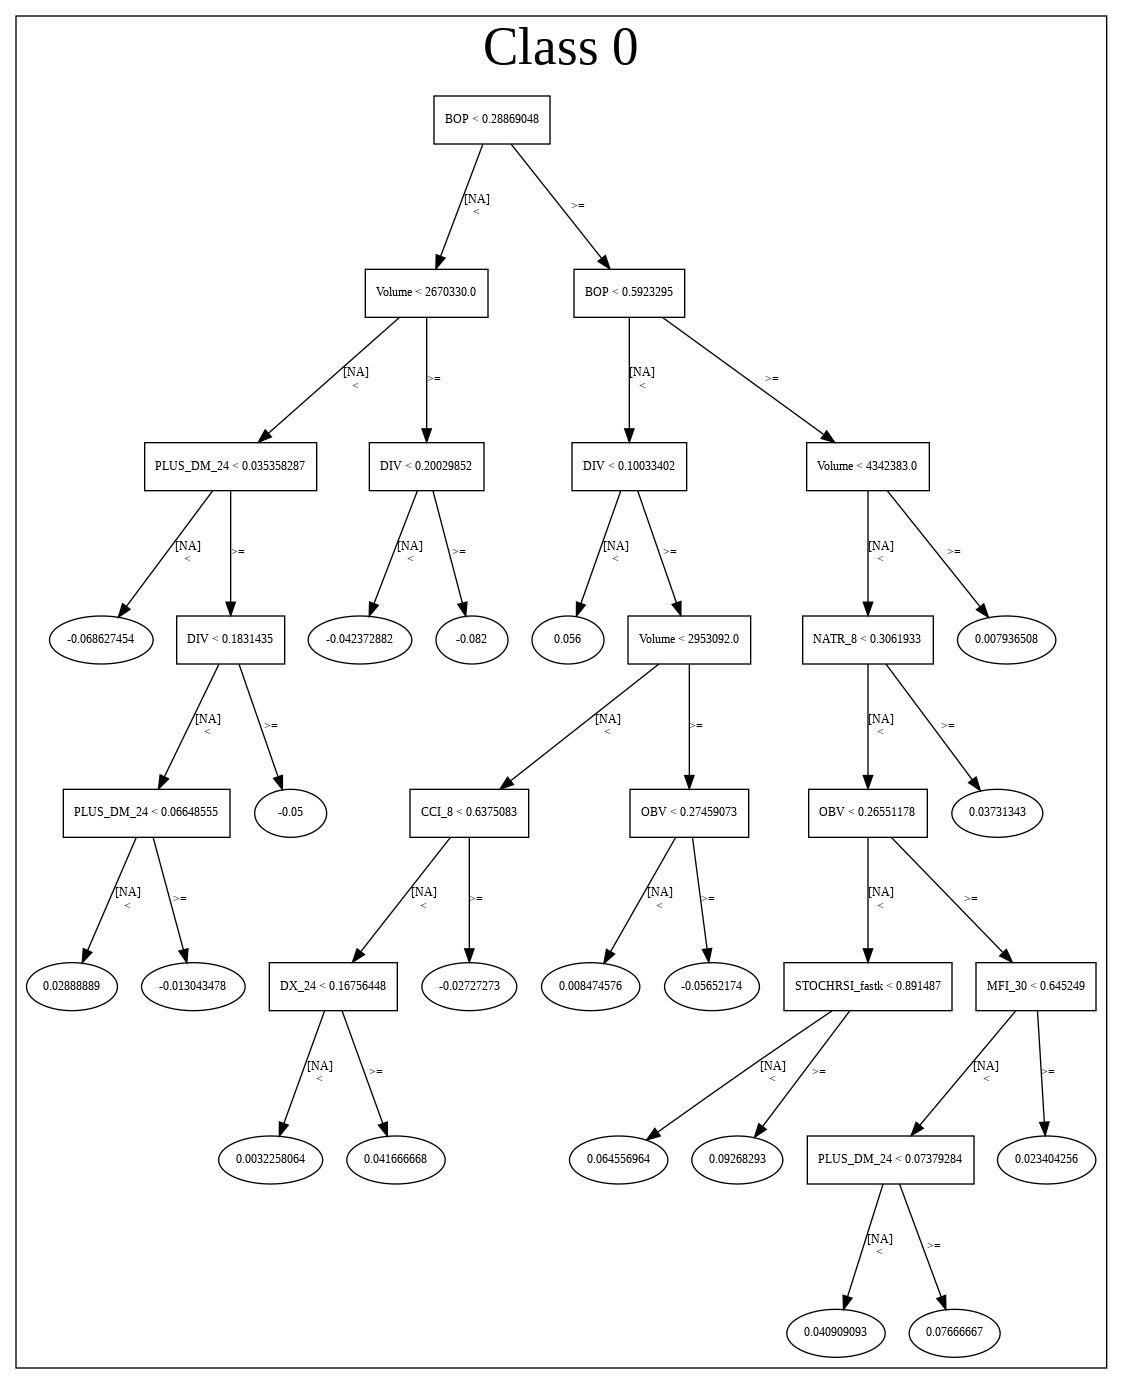

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_141807_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_141807_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'Volume',
 'SUB',
 'CCI_8',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'NATR_8',
 'CMO_14',
 'TRANGE',
 'ULTOSC',
 'WILLR_30',
 'WILLR_20',
 'CCI_14',
 'CCI_12',
 'STOCHRSI_fastd',
 'ROC_8',
 'WILLR_24',
 'CCI_20',
 'CMO_12',
 'CMO_8',
 'WILLR_8',
 'WILLR_14',
 'MOM_8',
 'WILLR_12',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

54

['BBANDS_lowerband_20_3_5',
 'BOP',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_8',
 'AROONOSC_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'WILLR_12',
 'MINUS_DI_14',
 'PLUS_DM_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14',
 'aroonup_20',
 'AROONOSC_20',
 'CCI_20',
 'CMO_20',
 'MFI_20',
 'ROCR_20',
 'RSI_20',
 'AROONOSC_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MINUS_DI_30',
 'PLUS_DI_30',
 'ROC_30',
 'WILLR_30',
 'MACDEXT_signal',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLLONGLINE',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'CORREL_12',
 'CORREL_14',
 'LINEARREG_ANGLE_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_141928_model_9  0.751120  0.620726              0.273946  0.462284  0.213706
1  DeepLearning_grid_1_AutoML_20190826_141928_model_8  0.745389  0.630011              0.351416  0.455045  0.207066
2  DeepLearning_grid_1_AutoML_20190826_141928_model_6  0.735968  0.628663              0.363340  0.463640  0.214962
3  DeepLearning_grid_1_AutoML_20190826_141928_model_4  0.735178  0.845978              0.382708  0.485556  0.235765
4  DeepLearning_grid_1_AutoML_20190826_141928_model_2  0.724835  1.437606              0.316337  0.562198  0.316067
5  DeepLearning_grid_1_AutoML_20190826_141928_model_3  0.706126  2.580533              0.352964  0.610164  0.372300
6  DeepLearning_grid_1_AutoML_20190826_141928_model_5  0.688801  0.812814              0.350988  0.497050  0.247059
7  DeepLearning_grid_1_AutoML_20190826_141928_model_1  0.661660  4.938241              0.374144  0.666835  0.444669
8  DeepLearning_grid_1_AutoML_20190826_141928_model_7  0.654611  0.817270              0.359552  0.514488  0.264698
9               DeepLearning_1_AutoML_20190826_141928  0.635310  0.980831              0.446542  0.549417  0.301859

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.035982
1                    TRANGE             0.736701           0.736701    0.026508
2               CDLLONGLINE             0.659464           0.659464    0.023729
3              STOCHF_fastk             0.555436           0.555436    0.019986
4            STOCHRSI_fastk             0.546481           0.546481    0.019664
5                  WILLR_14             0.531356           0.531356    0.019119
6                AROONOSC_8             0.527949           0.527949    0.018997
7               AROONOSC_20             0.517384           0.517384    0.018617
8         LINEARREG_SLOPE_8             0.515975           0.515975    0.018566
9                    ROCR_8             0.515765           0.515765    0.018558
10               PLUS_DI_30             0.513182           0.513182    0.018465
11                   BETA_8             0.512788           0.512788    0.018451
12  BBANDS_lowerband_20_3_5             0.511997           0.511997    0.018423
13                   ULTOSC             0.510042           0.510042    0.018352
14                  WILLR_8             0.509966           0.509966    0.018350
15               MINUS_DI_8             0.509450           0.509450    0.018331
16              MINUS_DI_30             0.509375           0.509375    0.018328
17                 WILLR_24             0.509370           0.509370    0.018328
18                 WILLR_30             0.508044           0.508044    0.018281
19                 WILLR_12             0.507596           0.507596    0.018264
20                    VAR_8             0.501795           0.501795    0.018056
21       LINEARREG_ANGLE_14             0.500448           0.500448    0.018007
22               PLUS_DI_12             0.500300           0.500300    0.018002
23              AROONOSC_12             0.499865           0.499865    0.017986
24     HT_PHASOR_quadrature             0.499276           0.499276    0.017965
25             MACDEXT_hist             0.498896           0.498896    0.017951
26           MACDEXT_signal             0.497725           0.497725    0.017909
27                aroonup_8             0.497644           0.497644    0.017906
28                  ROCP_14             0.496924           0.496924    0.017880
29                   CMO_30             0.496590           0.496590    0.017868
30                   ROC_12             0.495996           0.495996    0.017847
31              STOCH_slowd             0.495719           0.495719    0.017837
32                   CMO_20             0.495536           0.495536    0.017830
33               aroonup_20             0.495353           0.495353    0.017824
34                      PPO             0.493968           0.493968    0.017774
35                   MFI_20             0.493930           0.493930    0.017773
36           STOCHRSI_fastd             0.493761           0.493761    0.017767
37                  ROCR_20             0.491760           0.491760    0.017695
38                  ROCR_14             0.491683           0.491683    0.017692
39                CORREL_12             0.486978           0.486978    0.017523
40              AROONOSC_24             0.485587           0.485587    0.017472
41               ROCR100_14             0.485195           0.485195    0.017458
42                   CCI_20             0.483359           0.483359    0.017392
43                   CCI_30             0.482717           0.482717    0.017369
44                CORREL_14             0.482156           0.482156    0.017349
45                ROCR100_8             0.481527           0.481527    0.017326
46             STOCHF_fastd             0.479143           0.479143    0.017241
47                    CCI_8             0.477497           0.477497    0.017181
48               MINUS_DM_8             0.476539           0.476539    0.017147
49               PL

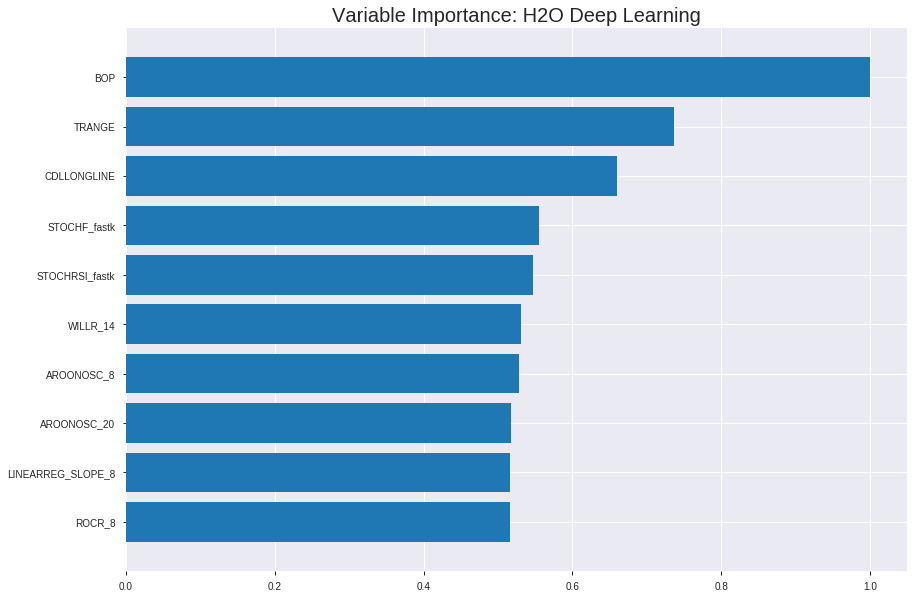

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_141928_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19101046848567793
RMSE: 0.4370474442044913
LogLoss: 0.5650593927567928
Mean Per-Class Error: 0.28617188617188616
AUC: 0.77577373291659
pr_auc: 0.784570784254945
Gini: 0.55154746583318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35309979947141734: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      294  483   0.6216   (483.0/777.0)
1      58   887   0.0614   (58.0/945.0)
Total  352  1370  0.3142   (541.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3531       0.766307  293
max f2                       0.227218     0.868584  342
max f0point5                 0.586672     0.744254  181
max accuracy                 0.565437     0.716028  192
max precision                0.954333     1         0
max recall                   0.0889728    1         395
max specificity              0.954333     1         0
max absolute_mcc             0.565437     0.427212  192
max min_per_class_accuracy   0.582381     0.710425  184
max mean_per_class_accuracy  0.579078     0.713828  185

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 55.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.918185           1.72099   1.72099            0.944444         0.932549  0.944444                    0.932549            0.0179894       0.0179894                  72.0988   72.0988
    2        0.0203252                   0.903924           1.50065   1.61397            0.823529         0.911082  0.885714                    0.922122            0.0148148       0.0328042                  50.0654   61.3968
    3        0.0301974                   0.890603           1.60784   1.61197            0.882353         0.896437  0.884615                    0.913725            0.015873        0.0486772                  60.7843   61.1966
    4        0.0400697                   0.881316           1.71503   1.63736            0.941176         0.886032  0.898551                    0.906902            0.0169312       0.0656085                  71.5033   63.7359
    5        0.0505226                   0.870014           1.72099   1.65466            0.944444         0.875505  0.908046                    0.900406            0.0179894       0.0835979                  72.0988   65.4662
    6        0.100465                    0.836921           1.44083   1.54836            0.790698         0.851682  0.849711                    0.876185            0.0719577       0.155556                   44.0827   54.8362
    7        0.150407                    0.79743            1.54677   1.54783            0.848837         0.817419  0.849421                    0.856672            0.0772487       0.232804                   54.677    54.7834
    8        0.200348                    0.769201           1.4832    1.53172            0.813953         0.783784  0.84058                     0.838503            0.0740741       0.306878                   48.3204   53.1723
    9        0.300232                    0.708157           1.35607   1.47329            0.744186         0.739787  0.808511                    0.805661            0.13545         0.442328                   35.6072   47.3286
    10       0.400116                    0.650113           1.28191   1.42551            0.703488         0.679094  0.782293                    0.774065            0.128042        0.57037                    28.1912   42.5512
    11       0.5                         0.593845           1.14419   1.36931            0.627907         0.623249  0.751452                    0.743937            0.114286        0.684656                   14.4186   36.9312
    12       0.599884                    0.518693           0.974677  1.3036             0.534884         0.560321  0.715392                    0.713364            0.0973545       0.782011                   -2.5323   30.3603
    13       0.699768                    0.440783           0.826357  1.23548            0.453488         0.478988  0.678008                    0.679909            0.0825397       0.86455                    -17.3643  23.5482
    14       0.799652                    0.346901           0.752196  1.17511            0.412791         0.394905  0.64488                     0.64431             0.0751323       0.939683                   -24.7804  17.5115
    15       0.899535                    0.216951           0.381395  1.08698            0.209302         0.285446  0.596514                    0.604462            0.0380952       0.977778                   -61.8605  8.69808
    16       1                           0.0647128          0.221195  1                  0.121387         0.154442  0.54878                     0.55925          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20730719816463414
RMSE: 0.45531000226728396
LogLoss: 0.6006852896701523
Mean Per-Class Error: 0.32516711229946527
AUC: 0.7311998663101604
pr_auc: 0.7547912693070432
Gini: 0.46239973262032086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4194425527596385: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   127  0.5773   (127.0/220.0)
1      33   239  0.1213   (33.0/272.0)
Total  126  366  0.3252   (160.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419443     0.749216  289
max f2                       0.16465      0.869845  373
max f0point5                 0.559948     0.711349  187
max accuracy                 0.47413      0.676829  258
max precision                0.902263     1         0
max recall                   0.107327     1         392
max specificity              0.902263     1         0
max absolute_mcc             0.559948     0.347995  187
max min_per_class_accuracy   0.542844     0.668182  202
max mean_per_class_accuracy  0.559948     0.674833  187

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101626                   0.879546           1.80882   1.80882            1                0.891251  1                           0.891251            0.0183824       0.0183824                  80.8824    80.8824
    2        0.0203252                   0.868285           1.44706   1.62794            0.8              0.875365  0.9                         0.883308            0.0147059       0.0330882                  44.7059    62.7941
    3        0.0304878                   0.847436           1.44706   1.56765            0.8              0.863199  0.866667                    0.876605            0.0147059       0.0477941                  44.7059    56.7647
    4        0.0406504                   0.825927           1.44706   1.5375             0.8              0.835119  0.85                        0.866234            0.0147059       0.0625                     44.7059    53.75
    5        0.050813                    0.818477           1.44706   1.51941            0.8              0.821872  0.84                        0.857361            0.0147059       0.0772059                  44.7059    51.9412
    6        0.101626                    0.77264            1.66412   1.59176            0.92             0.792406  0.88                        0.824884            0.0845588       0.161765                   66.4118    59.1765
    7        0.150407                    0.721157           1.50735   1.56439            0.833333         0.746836  0.864865                    0.799571            0.0735294       0.235294                   50.7353    56.4388
    8        0.20122                     0.694022           1.30235   1.49822            0.72             0.708961  0.828283                    0.77669             0.0661765       0.301471                   30.2353    49.8217
    9        0.300813                    0.645323           1.14436   1.38106            0.632653         0.67045   0.763514                    0.741516            0.113971        0.415441                   14.4358    38.1061
    10       0.400407                    0.593187           1.21819   1.34055            0.673469         0.617995  0.741117                    0.710792            0.121324        0.536765                   21.8187    34.0549
    11       0.5                         0.54751            1.14436   1.30147            0.632653         0.570667  0.719512                    0.682881            0.113971        0.650735                   14.4358    30.1471
    12       0.599593                    0.504511           0.885954  1.23245            0.489796         0.529768  0.681356                    0.657449            0.0882353       0.738971                   -11.4046   23.2453
    13       0.699187                    0.451804           0.996699  1.19887            0.55102          0.483407  0.662791                    0.632658            0.0992647       0.838235                   -0.330132  19.8871
    14       0.79878                     0.379534           0.738295  1.14145            0.408163         0.416153  0.631043                    0.605664            0.0735294       0.911765                   -26.1705   14.1446
    15       0.898374                    0.238017           0.590636  1.08038            0.326531         0.319018  0.597285                    0.573886            0.0588235       0.970588                   -40.9364   8.03833
    16       1                           0.0751804          0.289412  1                  0.16             0.159045  0.552846                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:28:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:28:33  3 min 23.481 sec  524 obs/sec       0.735192  1             1266       0.530015         0.92911             -0.134461      0.759501        0.768896           1.72099          0.308362                         0.501932           0.7704                -0.0191267       0.711731          0.733088             1.80882            0.353659
    2019-08-26 14:28:47  3 min 37.718 sec  511 obs/sec       4.38211   6             7546       0.437047         0.565059            0.228616       0.775774        0.784571           1.72099          0.31417                          0.45531            0.600685              0.161404         0.7312            0.754791             1.80882            0.325203
    2019-08-26 14:29:06  3 min 56.955 sec  592 obs/sec       10.9954   15            18934      0.434731         0.5628              0.236772       0.792474        0.796328           1.61975          0.278746                         0.458926           0.611333              0.148031         0.731275          0.747581             1.44706            0.329268
    2019-08-26 14:29:26  4 min 17.079 sec  656 obs/sec       19.1208   26            32926      0.426008         0.543071            0.267092       0.79811         0.801418           1.72099          0.2741                           0.455127           0.605978              0.162078         0.733648          0.747332             1.44706            0.313008
    2019-08-26 14:29:46  4 min 37.085 sec  706 obs/sec       27.9524   38            48134      0.426004         0.544396            0.267106       0.801301        0.803538           1.72099          0.261905                         0.456977           0.607949              0.155253         0.733339          0.752888             1.80882            0.335366
    2019-08-26 14:30:08  4 min 58.647 sec  750 obs/sec       38.1672   52            65724      0.421938         0.535124            0.281032       0.805215        0.809815           1.72099          0.260163                         0.461326           0.619003              0.139097         0.727223          0.748336             1.80882            0.327236
    2019-08-26 14:30:28  5 min 19.473 sec  783 obs/sec       48.3792   66            83309      0.419895         0.531776            0.287976       0.811121        0.814956           1.72099          0.253775                         0.459693           0.614681              0.145179         0.724348          0.73956              1.80882            0.329268
    2019-08-26 14:30:30  5 min 21.553 sec  783 obs/sec       48.3792   66            83309      0.437047         0.565059            0.228616       0.775774        0.784571           1.72099          0.31417                          0.45531            0.600685              0.161404         0.7312            0.754791             1.80882            0.325203

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.03598216358139922
TRANGE          0.7367008924484253     0.7367008924484253   0.02650809202264203
CDLLONGLINE     0.6594639420509338     0.6594639420509338   0.023728939438911075
STOCHF_fastk    0.5554361343383789     0.5554361343383789   0.01998579384478358
STOCHRSI_fastk  0.5464807152748108     0.5464807152748108   0.01966355849109829
---             ---                    ---                  ---
PLUS_DM_14      0.4717676341533661     0.4717676341533661   0.01697522018451612
MINUS_DI_14     0.4690993130207062     0.4690993130207062   0.016879208217033047
ROCP_12         0.4665764272212982     0.4665764272212982   0.01678842932750156
ROC_30          0.4640006124973297     0.4640006124973297   0.01669574594074835
RSI_20          0.4539170265197754     0.4539170265197754   0.016332916700616887


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.728744939271255)

('F1', 0.7022222222222221)

('auc', 0.7511198945981555)

('logloss', 0.6207261882237737)

('mean_per_class_error', 0.2739459815546772)

('rmse', 0.4622836788791786)

('mse', 0.21370619975806754)

deeplearning prediction progress: |███████████████████████████████████████| 100%


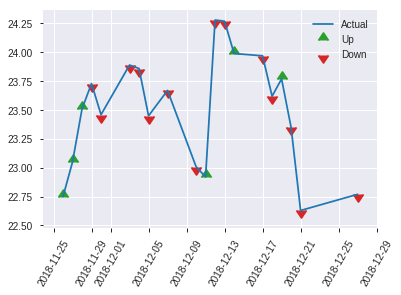


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21370619975806754
RMSE: 0.4622836788791786
LogLoss: 0.6207261882237737
Mean Per-Class Error: 0.2739459815546772
AUC: 0.7511198945981555
pr_auc: 0.7268359941060099
Gini: 0.5022397891963111
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42251767621015746: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      101  31   0.2348   (31.0/132.0)
1      36   79   0.313    (36.0/115.0)
Total  137  110  0.2713   (67.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422518     0.702222  109
max f2                       0.100297     0.814448  245
max f0point5                 0.429182     0.717017  101
max accuracy                 0.429182     0.728745  101
max precision                0.573356     0.939394  32
max recall                   0.100297     1         245
max specificity              0.708886     0.992424  0
max absolute_mcc             0.422518     0.453755  109
max min_per_class_accuracy   0.405077     0.704348  118
max mean_per_class_accuracy  0.422518     0.726054  109

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 38.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.695643           1.43188   1.43188            0.666667         0.704041  0.666667                    0.704041            0.0173913       0.0173913                  43.1884   43.1884
    2        0.0202429                   0.671387           1.07391   1.2887             0.5              0.684472  0.6                         0.696214            0.00869565      0.026087                   7.3913    28.8696
    3        0.0323887                   0.645383           2.14783   1.61087            1                0.659722  0.75                        0.682529            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.641209           2.14783   1.71826            1                0.643781  0.8                         0.67478             0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.638726           2.14783   1.81739            1                0.640044  0.846154                    0.666764            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.595744           2.14783   1.976              1                0.614265  0.92                        0.641564            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.552247           1.78986   1.91563            0.833333         0.575485  0.891892                    0.620133            0.0869565       0.286957                   78.9855   91.5629
    8        0.202429                    0.520329           1.65217   1.84713            0.769231         0.531539  0.86                        0.597099            0.0869565       0.373913                   65.2174   84.713
    9        0.299595                    0.476121           1.07391   1.59636            0.5              0.496646  0.743243                    0.56452             0.104348        0.478261                   7.3913    59.6357
    10       0.40081                     0.432539           1.46052   1.56206            0.68             0.454007  0.727273                    0.536612            0.147826        0.626087                   46.0522   56.2055
    11       0.502024                    0.393935           0.773217  1.40302            0.36             0.41636   0.653226                    0.512368            0.0782609       0.704348                   -22.6783  40.3015
    12       0.59919                     0.343151           0.715942  1.2916             0.333333         0.365792  0.601351                    0.488599            0.0695652       0.773913                   -28.4058  29.1598
    13       0.700405                    0.304477           0.687304  1.20427            0.32             0.323658  0.560694                    0.464763            0.0695652       0.843478                   -31.2696  20.4272
    14       0.797571                    0.25335            0.536957  1.12298            0.25             0.278915  0.522843                    0.442122            0.0521739       0.895652                   -46.3043  12.2975
    15       0.898785                    0.177929           0.343652  1.03521            0.16             0.211111  0.481982                    0.416107            0.0347826       0.930435                   -65.6348  3.52135
    16       1                           0.0952415          0.687304  1                  0.32             0.136322  0.465587                    0.387789            0.

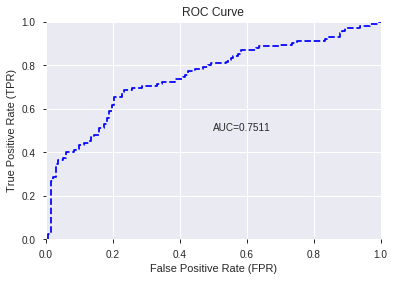

This function is available for GLM models only


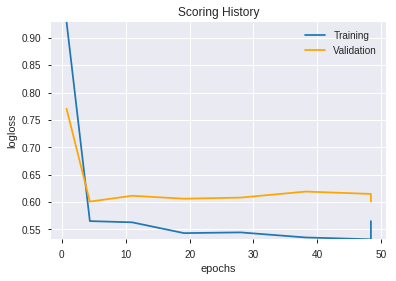

--2019-08-26 14:30:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


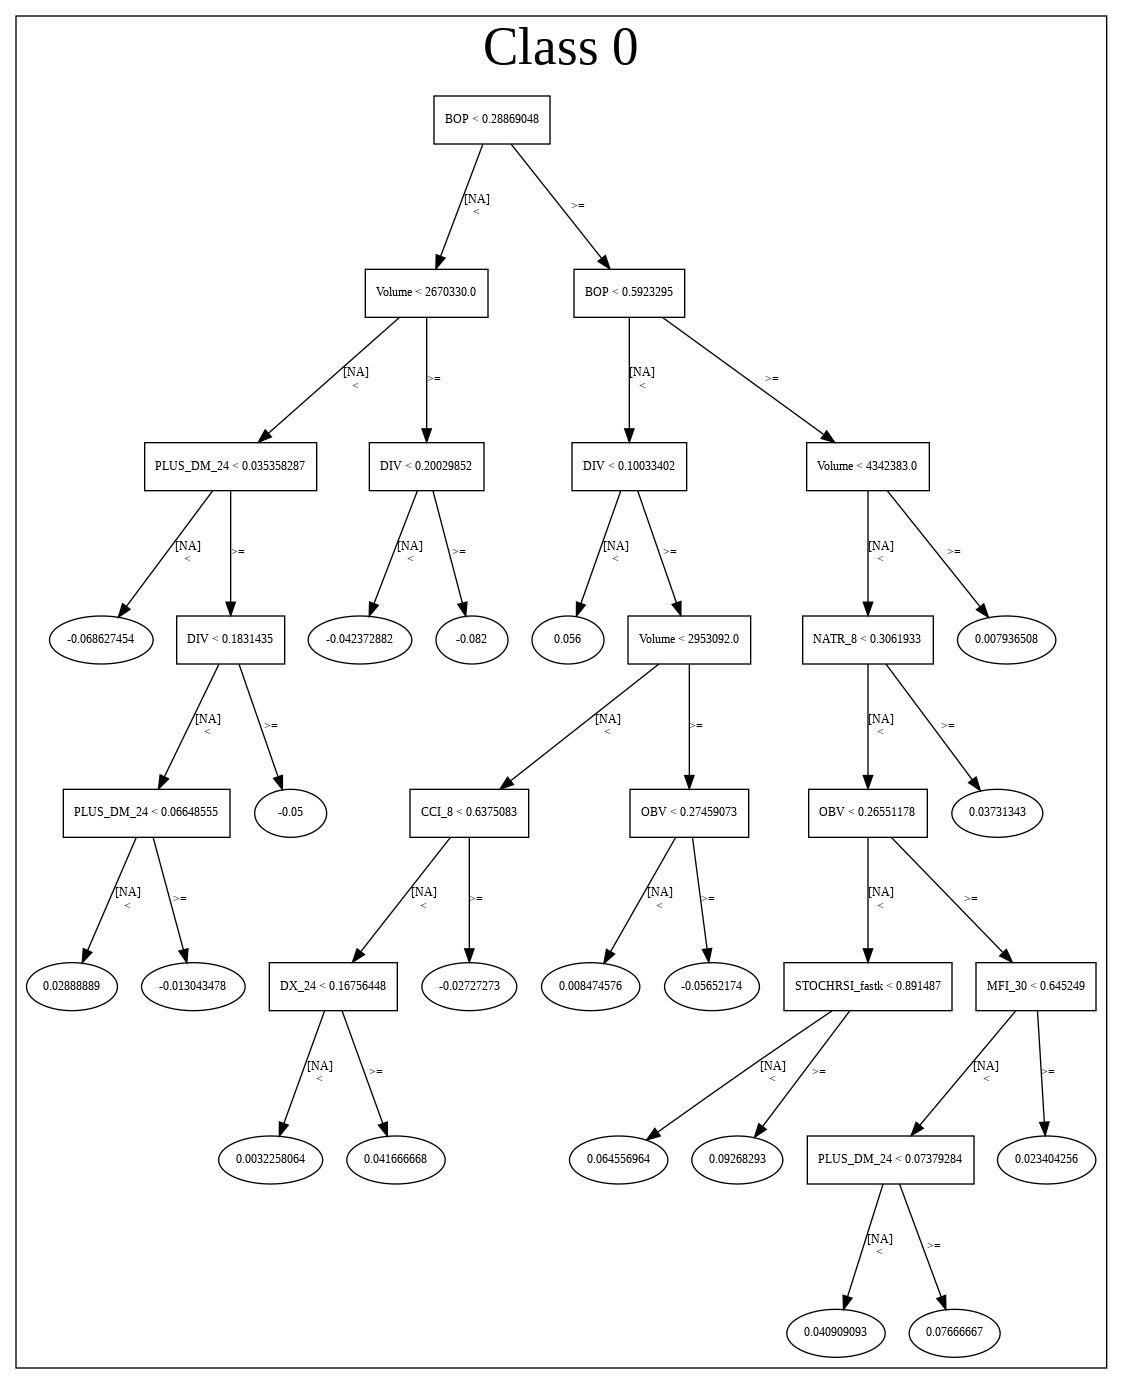

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_141928_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_141928_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_14',
 'AROONOSC_8',
 'AROONOSC_20',
 'LINEARREG_SLOPE_8',
 'ROCR_8',
 'PLUS_DI_30',
 'BETA_8',
 'BBANDS_lowerband_20_3_5',
 'ULTOSC',
 'WILLR_8',
 'MINUS_DI_8',
 'MINUS_DI_30',
 'WILLR_24',
 'WILLR_30',
 'WILLR_12',
 'VAR_8',
 'LINEARREG_ANGLE_14',
 'PLUS_DI_12',
 'AROONOSC_12',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'MACDEXT_signal',
 'aroonup_8',
 'ROCP_14',
 'CMO_30',
 'ROC_12',
 'STOCH_slowd',
 'CMO_20',
 'aroonup_20',
 'PPO',
 'MFI_20',
 'STOCHRSI_fastd',
 'ROCR_20',
 'ROCR_14',
 'CORREL_12',
 'AROONOSC_24',
 'ROCR100_14',
 'CCI_20',
 'CCI_30',
 'CORREL_14',
 'ROCR100_8',
 'STOCHF_fastd',
 'CCI_8',
 'MINUS_DM_8',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'ROCP_12',
 'ROC_30',
 'RSI_20']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_143047_model_1  0.758827  0.610096              0.351845  0.446798  0.199629

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.407277           1.000000    0.153125
1                    TRANGE             0.240574           0.590689    0.090449
2               CDLLONGLINE             0.192529           0.472722    0.072385
3              STOCHF_fastk             0.140398           0.344723    0.052786
4            STOCHRSI_fastk             0.130067           0.319356    0.048901
5               STOCH_slowd             0.084427           0.207296    0.031742
6                  WILLR_12             0.083264           0.204442    0.031305
7                   WILLR_8             0.079767           0.195855    0.029990
8   BBANDS_lowerband_20_3_5             0.074167           0.182105    0.027885
9                AROONOSC_8             0.072843           0.178855    0.027387
10                aroonup_8             0.067626           0.166044    0.025425
11               PLUS_DI_30             0.062760           0.154097    0.023596
12             STOCHF_fastd             0.061375           0.150696    0.023075
13                 WILLR_14             0.060830           0.149357    0.022870
14                   ULTOSC             0.059253           0.145485    0.022277
15                 WILLR_24             0.053241           0.130723    0.020017
16                CORREL_12             0.052649           0.129270    0.019794
17                  ROCR_20             0.052195           0.128155    0.019624
18           STOCHRSI_fastd             0.046851           0.115034    0.017615
19                   ROC_30             0.037173           0.091272    0.013976
20              AROONOSC_24             0.035858           0.088044    0.013482
21        LINEARREG_SLOPE_8             0.035286           0.086639    0.013267
22                 WILLR_30             0.033562           0.082406    0.012618
23                ROCR100_8             0.033066           0.081188    0.012432
24                   ROCR_8             0.033065           0.081185    0.012431
25               PLUS_DI_12             0.032470           0.079724    0.012208
26              AROONOSC_20             0.027591           0.067746    0.010374
27               MINUS_DI_8             0.026610           0.065337    0.010005
28                    CCI_8             0.026342           0.064679    0.009904
29                   BETA_8             0.024812           0.060922    0.009329
30               MINUS_DM_8             0.024478           0.060102    0.009203
31              AROONOSC_12             0.023590           0.057922    0.008869
32       LINEARREG_ANGLE_14             0.020042           0.049210    0.007535
33               PLUS_DM_14             0.018611           0.045696    0.006997
34                   CMO_20             0.018060           0.044343    0.006790
35                   CCI_20             0.017908           0.043971    0.006733
36                   RSI_20             0.017651           0.043338    0.006636
37                CORREL_14             0.017396           0.042714    0.006541
38              MINUS_DI_30             0.016092           0.039511    0.006050
39                   MFI_20             0.015253           0.037452    0.005735
40                      PPO             0.012921           0.031725    0.004858
41     HT_PHASOR_quadrature             0.012187           0.029923    0.004582
42                  ROCP_12             0.011088           0.027225    0.004169
43                   ROC_12             0.011051           0.027133    0.004155
44              MINUS_DI_14             0.008492           0.020852    0.003193
45                    VAR_8             0.008275           0.020319    0.003111
46               aroonup_20             0.007148           0.017551    0.002688
47               ROCR100_14             0.005663           0.013904    0.002129
48                  ROCR_14             0.005481           0.013457    0.002061
49                 

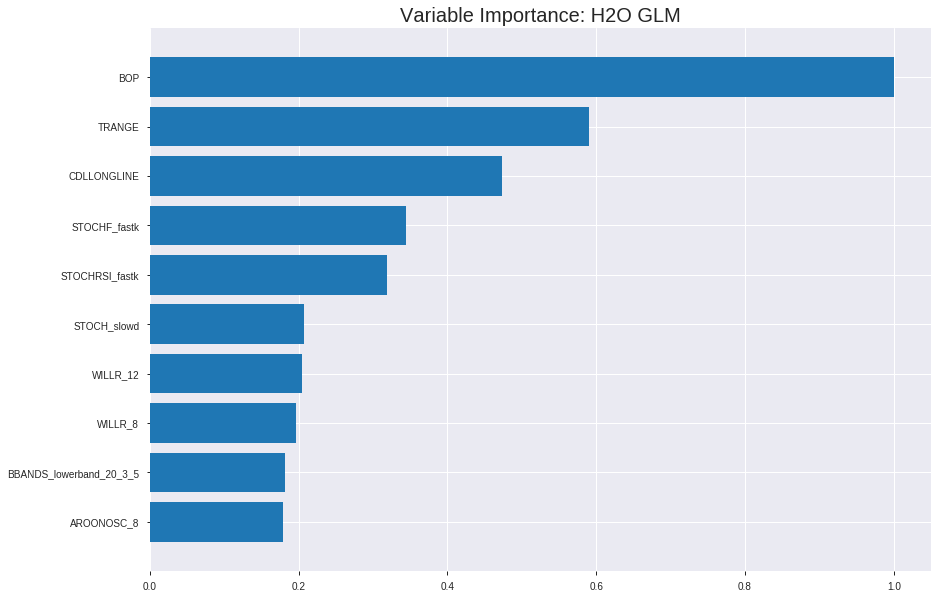

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_143047_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19172751293187767
RMSE: 0.4378670037030396
LogLoss: 0.5681000119905371
Null degrees of freedom: 1721
Residual degrees of freedom: 1667
Null deviance: 2370.782545663055
Residual deviance: 1956.5364412954095
AIC: 2066.5364412954095
AUC: 0.7813330337139861
pr_auc: 0.7844930801226948
Gini: 0.5626660674279722
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44666195030353945: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      404  373   0.4801   (373.0/777.0)
1      123  822   0.1302   (123.0/945.0)
Total  527  1195  0.288    (496.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446662     0.768224  251
max f2                       0.222887     0.869726  361
max f0point5                 0.607301     0.753877  159
max accuracy                 0.489822     0.722997  227
max precision                0.931513     1         0
max recall                   0.144926     1         389
max specificity              0.931513     1         0
max absolute_mcc             0.536992     0.43937   200
max min_per_class_accuracy   0.553998     0.711712  190
max mean_per_class_accuracy  0.536992     0.719634  200

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.874391           1.61975   1.61975            0.888889         0.891574  0.888889                    0.891574            0.0169312       0.0169312                  61.9753   61.9753
    2        0.0203252                   0.864341           1.60784   1.61397            0.882353         0.869169  0.885714                    0.880691            0.015873        0.0328042                  60.7843   61.3968
    3        0.0301974                   0.852022           1.50065   1.57692            0.823529         0.857027  0.865385                    0.872955            0.0148148       0.047619                   50.0654   57.6923
    4        0.0400697                   0.844244           1.60784   1.58454            0.882353         0.847712  0.869565                    0.866736            0.015873        0.0634921                  60.7843   58.4541
    5        0.0505226                   0.836255           1.51852   1.57088            0.833333         0.840638  0.862069                    0.861336            0.015873        0.0793651                  51.8519   57.0881
    6        0.100465                    0.785988           1.52558   1.54836            0.837209         0.807225  0.849711                    0.834437            0.0761905       0.155556                   52.5581   54.8362
    7        0.150407                    0.755029           1.50439   1.53376            0.825581         0.76959   0.841699                    0.812905            0.0751323       0.230688                   50.4393   53.3762
    8        0.200348                    0.72446            1.44083   1.5106             0.790698         0.739251  0.828986                    0.794545            0.0719577       0.302646                   44.0827   51.0596
    9        0.300232                    0.676366           1.46202   1.49443            0.802326         0.700421  0.820116                    0.763231            0.146032        0.448677                   46.2016   49.4434
    10       0.400116                    0.627343           1.29251   1.44403            0.709302         0.652069  0.792453                    0.735481            0.129101        0.577778                   29.2506   44.4025
    11       0.5                         0.564574           1.19716   1.39471            0.656977         0.595995  0.765389                    0.707616            0.119577        0.697354                   19.7158   39.4709
    12       0.599884                    0.50452            0.9323    1.31772            0.511628         0.535112  0.723136                    0.678893            0.0931217       0.790476                   -6.77003  31.7715
    13       0.699768                    0.441851           0.794574  1.24304            0.436047         0.475086  0.682158                    0.649802            0.0793651       0.869841                   -20.5426  24.3043
    14       0.799652                    0.374453           0.61447   1.16453            0.337209         0.410599  0.63907                     0.619923            0.0613757       0.931217                   -38.553   16.4528
    15       0.899535                    0.26772            0.476744  1.08816            0.261628         0.326023  0.597159                    0.587289            0.047619        0.978836                   -52.3256  8.81572
    16       1                           0.0583418          0.210662  1                  0.115607         0.203988  0.54878                     0.548781         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20906999553267253
RMSE: 0.45724172549393666
LogLoss: 0.6064389059142403
Null degrees of freedom: 491
Residual degrees of freedom: 437
Null deviance: 676.5834633095117
Residual deviance: 596.7358834196125
AIC: 706.7358834196125
AUC: 0.7310327540106951
pr_auc: 0.7500195064754631
Gini: 0.46206550802139024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40336331691296445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   147  0.6682   (147.0/220.0)
1      20   252  0.0735   (20.0/272.0)
Total  93   399  0.3394   (167.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403363     0.751118  316
max f2                       0.18533      0.865385  379
max f0point5                 0.635308     0.71875   165
max accuracy                 0.583366     0.676829  206
max precision                0.895281     1         0
max recall                   0.0658847    1         396
max specificity              0.895281     1         0
max absolute_mcc             0.635308     0.361547  165
max min_per_class_accuracy   0.593373     0.672794  196
max mean_per_class_accuracy  0.635308     0.680047  165

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 57.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.884671           1.80882   1.80882            1                0.889123  1                           0.889123            0.0183824       0.0183824                  80.8824   80.8824
    2        0.0203252                   0.865134           1.44706   1.62794            0.8              0.877842  0.9                         0.883483            0.0147059       0.0330882                  44.7059   62.7941
    3        0.0304878                   0.856684           1.08529   1.44706            0.6              0.861472  0.8                         0.876146            0.0110294       0.0441176                  8.52941   44.7059
    4        0.0406504                   0.851421           1.44706   1.44706            0.8              0.85377   0.8                         0.870552            0.0147059       0.0588235                  44.7059   44.7059
    5        0.050813                    0.838307           1.44706   1.44706            0.8              0.843882  0.8                         0.865218            0.0147059       0.0735294                  44.7059   44.7059
    6        0.101626                    0.803141           1.51941   1.48324            0.84             0.820993  0.82                        0.843106            0.0772059       0.150735                   51.9412   48.3235
    7        0.150407                    0.771362           1.65809   1.53994            0.916667         0.787927  0.851351                    0.82521             0.0808824       0.231618                   65.8088   53.9944
    8        0.20122                     0.742345           1.59176   1.55303            0.88             0.756602  0.858586                    0.807885            0.0808824       0.3125                     59.1765   55.303
    9        0.300813                    0.69382            1.10744   1.4055             0.612245         0.71725   0.777027                    0.777877            0.110294        0.422794                   10.7443   40.5505
    10       0.400407                    0.652442           1.29202   1.37728            0.714286         0.674128  0.761421                    0.752072            0.128676        0.551471                   29.2017   37.7277
    11       0.5                         0.604399           0.959784  1.29412            0.530612         0.628957  0.715447                    0.727549            0.0955882       0.647059                   -4.02161  29.4118
    12       0.599593                    0.557926           0.959784  1.23858            0.530612         0.57976   0.684746                    0.703001            0.0955882       0.742647                   -4.02161  23.8584
    13       0.699187                    0.481061           0.812125  1.17784            0.44898          0.51644   0.651163                    0.676427            0.0808824       0.823529                   -18.7875  17.7839
    14       0.79878                     0.410424           0.885954  1.14145            0.489796         0.447316  0.631043                    0.647861            0.0882353       0.911765                   -11.4046  14.1446
    15       0.898374                    0.280374           0.479892  1.06811            0.265306         0.348664  0.590498                    0.614692            0.0477941       0.959559                   -52.0108  6.81062
    16       1                           0.0384154          0.397941  1                  0.22             0.186027  0.552846                    0.571128          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:30:47  0.000 sec   2            22        55            1.36024           1.36094
    2019-08-26 14:30:47  0.011 sec   4            14        55            1.35208           1.35397
    2019-08-26 14:30:47  0.022 sec   6            8.4       55            1.34074           1.34436
    2019-08-26 14:30:47  0.033 sec   8            5.2       55            1.3255            1.33166
    2019-08-26 14:30:47  0.049 sec   10           3.3       55            1.30586           1.31571
    2019-08-26 14:30:48  0.061 sec   12           2         55            1.28187           1.29706
    2019-08-26 14:30:48  0.072 sec   14           1.3       55            1.25457           1.27705
    2019-08-26 14:30:48  0.086 sec   16           0.78      55            1.22588           1.2574
    2019-08-26 14:30:48  0.098 sec   18           0.48      55            1.19812           1.23971
    2019-08-26 14:30:48  0.109 sec   20           0.3       55            1.17328           1.2253
    2019-08-26 14:30:48  0.120 sec   22           0.19      55            1.15253           1.21579
    2019-08-26 14:30:48  0.131 sec   24           0.12      55            1.1362            1.21288
    2019-08-26 14:30:48  0.142 sec   26           0.072     55            1.12393           1.21785
    2019-08-26 14:30:48  0.154 sec   28           0.045     55            1.11503           1.22992
    2019-08-26 14:30:48  0.165 sec   30           0.028     55            1.10866           1.24691
    2019-08-26 14:30:48  0.177 sec   32           0.017     55            1.10409           1.26605
    2019-08-26 14:30:48  0.189 sec   34           0.011     55            1.10073           1.28474

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7165991902834008)

('F1', 0.7032258064516129)

('auc', 0.7588274044795784)

('logloss', 0.6100957677204967)

('mean_per_class_error', 0.300592885375494)

('rmse', 0.44679820294123024)

('mse', 0.19962863415151275)

glm prediction progress: |████████████████████████████████████████████████| 100%


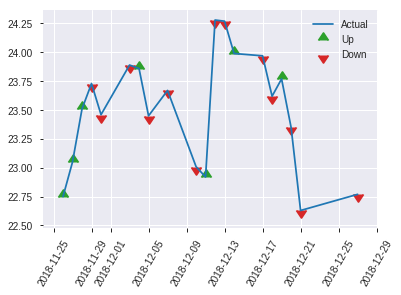


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19962863415151275
RMSE: 0.44679820294123024
LogLoss: 0.6100957677204967
Null degrees of freedom: 246
Residual degrees of freedom: 192
Null deviance: 348.1046065632917
Residual deviance: 301.3873092539253
AIC: 411.3873092539253
AUC: 0.7588274044795784
pr_auc: 0.7282525939033602
Gini: 0.5176548089591568
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2718115667420205: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   86   0.6515   (86.0/132.0)
1      6    109  0.0522   (6.0/115.0)
Total  52   195  0.3725   (92.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.271812     0.703226  194
max f2                       0.271812     0.832061  194
max f0point5                 0.64138      0.74344   56
max accuracy                 0.64138      0.716599  56
max precision                0.736036     0.935484  30
max recall                   0.000873368  1         245
max specificity              0.867531     0.992424  0
max absolute_mcc             0.64138      0.471227  56
max min_per_class_accuracy   0.484818     0.666667  120
max mean_per_class_accuracy  0.518787     0.699407  101

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 45.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.845795           0.715942  0.715942           0.333333         0.859329   0.333333                    0.859329            0.00869565      0.00869565                 -28.4058  -28.4058
    2        0.0202429                   0.840045           2.14783   1.2887             1                0.843117   0.6                         0.852844            0.0173913       0.026087                   114.783   28.8696
    3        0.0323887                   0.831464           2.14783   1.61087            1                0.837485   0.75                        0.847085            0.026087        0.0521739                  114.783   61.087
    4        0.0404858                   0.824772           2.14783   1.71826            1                0.825849   0.8                         0.842838            0.0173913       0.0695652                  114.783   71.8261
    5        0.0526316                   0.81612            2.14783   1.81739            1                0.821891   0.846154                    0.838004            0.026087        0.0956522                  114.783   81.7391
    6        0.101215                    0.751539           2.14783   1.976              1                0.783212   0.92                        0.811704            0.104348        0.2                        114.783   97.6
    7        0.149798                    0.698025           1.78986   1.91563            0.833333         0.727857   0.891892                    0.78451             0.0869565       0.286957                   78.9855   91.5629
    8        0.202429                    0.661563           1.81739   1.89009            0.846154         0.687162   0.88                        0.7592              0.0956522       0.382609                   81.7391   89.0087
    9        0.299595                    0.598742           1.07391   1.62538            0.5              0.629195   0.756757                    0.717036            0.104348        0.486957                   7.3913    62.5382
    10       0.40081                     0.52215            1.11687   1.49697            0.52             0.565813   0.69697                     0.678849            0.113043        0.6                        11.687    49.697
    11       0.502024                    0.480349           0.773217  1.35105            0.36             0.500517   0.629032                    0.642895            0.0782609       0.678261                   -22.6783  35.1052
    12       0.59919                     0.391637           0.894928  1.27709            0.416667         0.430171   0.594595                    0.608399            0.0869565       0.765217                   -10.5072  27.7086
    13       0.700405                    0.342581           0.945043  1.2291             0.44             0.364706   0.572254                    0.573183            0.0956522       0.86087                    -5.49565  22.9103
    14       0.797571                    0.256578           0.894928  1.18839            0.416667         0.303416   0.553299                    0.540318            0.0869565       0.947826                   -10.5072  18.8391
    15       0.898785                    0.154814           0.171826  1.07391            0.08             0.202609   0.5                         0.502288            0.0173913       0.965217                   -82.8174  7.3913
    16       1                           0.000548484        0.343652  1                  0.16             0.0734952  0.465587                    0.45

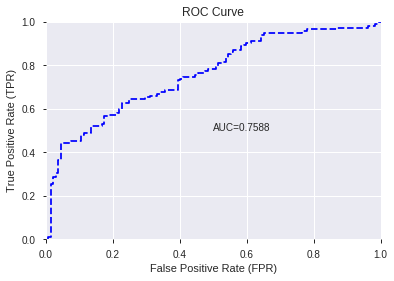

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


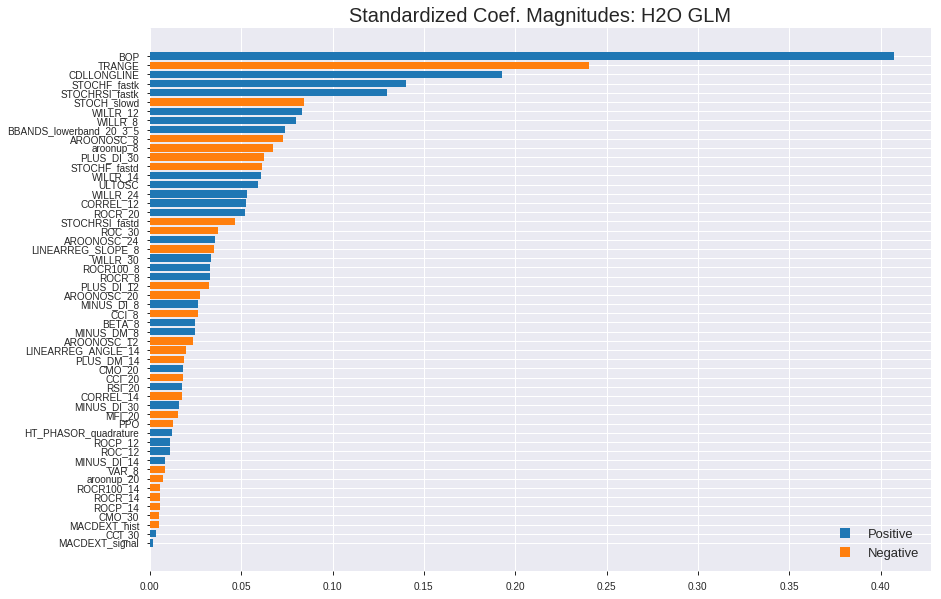

'log_likelihood'
--2019-08-26 14:30:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


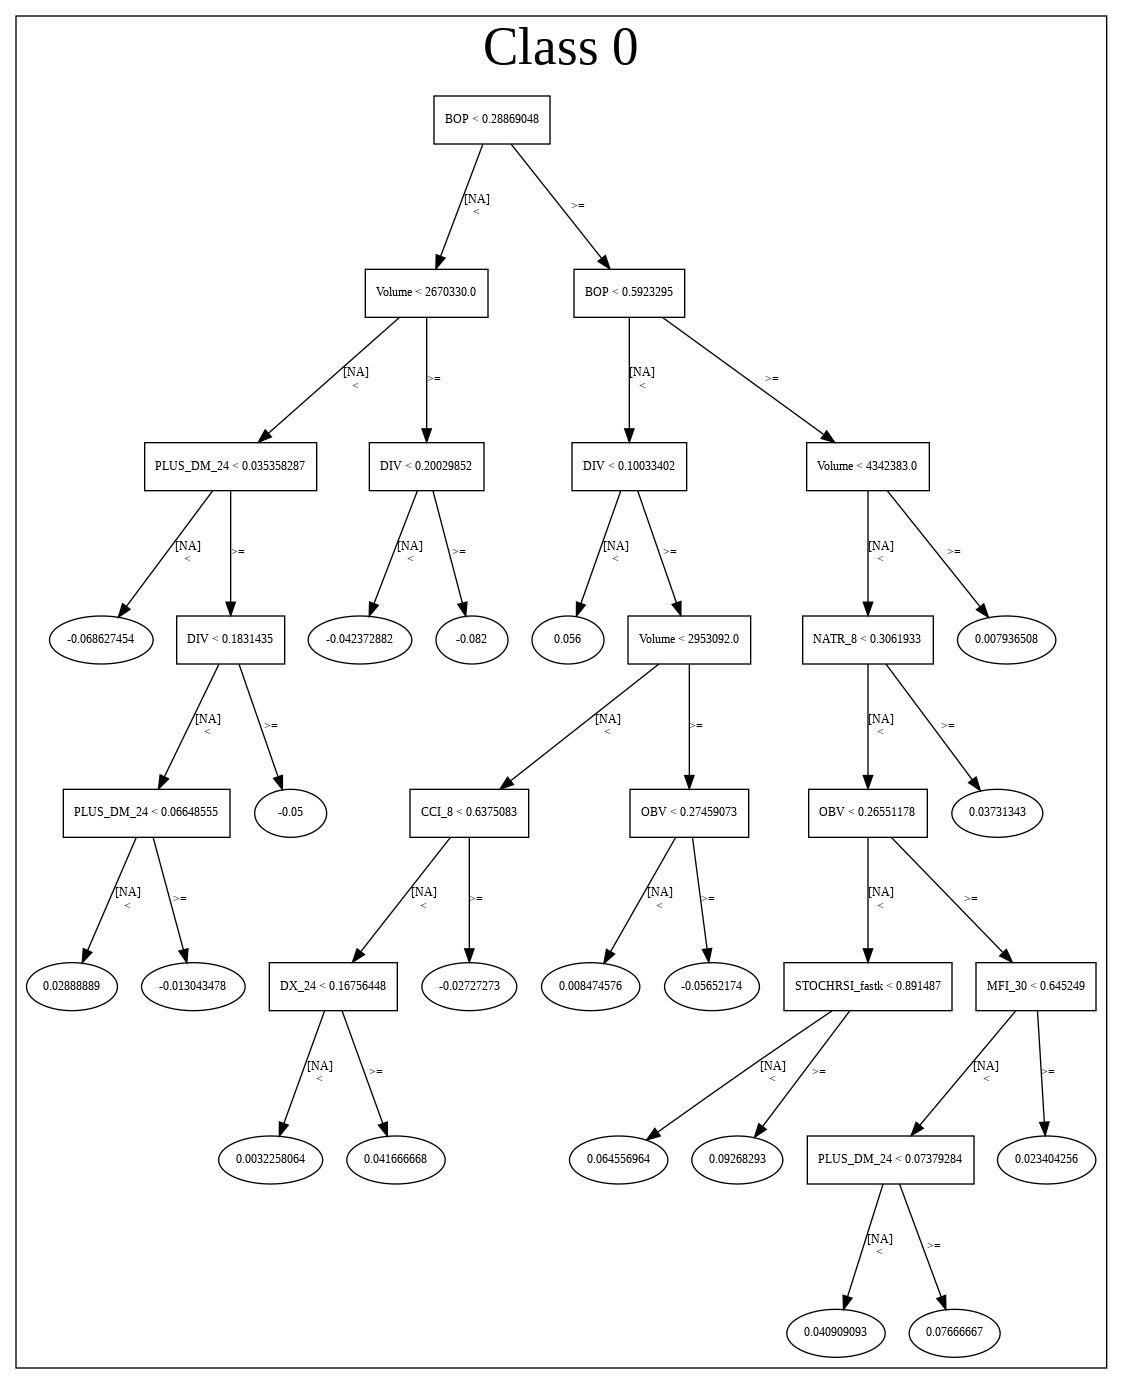

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_143047_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_143047_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'WILLR_12',
 'WILLR_8',
 'BBANDS_lowerband_20_3_5',
 'AROONOSC_8',
 'aroonup_8',
 'PLUS_DI_30',
 'STOCHF_fastd',
 'WILLR_14',
 'ULTOSC',
 'WILLR_24',
 'CORREL_12',
 'ROCR_20',
 'STOCHRSI_fastd',
 'ROC_30',
 'AROONOSC_24',
 'LINEARREG_SLOPE_8',
 'WILLR_30',
 'ROCR100_8',
 'ROCR_8',
 'PLUS_DI_12',
 'AROONOSC_20',
 'MINUS_DI_8',
 'CCI_8',
 'BETA_8',
 'MINUS_DM_8',
 'AROONOSC_12',
 'LINEARREG_ANGLE_14',
 'PLUS_DM_14',
 'CMO_20',
 'CCI_20',
 'RSI_20',
 'CORREL_14',
 'MINUS_DI_30',
 'MFI_20',
 'PPO',
 'HT_PHASOR_quadrature',
 'ROCP_12',
 'ROC_12',
 'MINUS_DI_14',
 'VAR_8',
 'aroonup_20',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'CMO_30',
 'MACDEXT_hist',
 'CCI_30',
 'MACDEXT_signal']

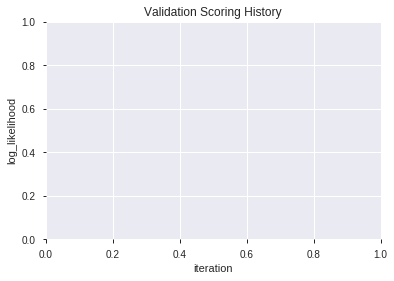

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_143059_model_4  0.768314  0.577706              0.272991  0.441905  0.195280
1  XGBoost_grid_1_AutoML_20190826_143059_model_1  0.759684  0.588055              0.266238  0.447972  0.200679
2               XGBoost_1_AutoML_20190826_143059  0.759025  0.586386              0.266798  0.446746  0.199582
3  XGBoost_grid_1_AutoML_20190826_143059_model_2  0.758300  0.593491              0.319005  0.450471  0.202924
4               XGBoost_3_AutoML_20190826_143059  0.757839  0.588450              0.263439  0.448300  0.200973
5               XGBoost_2_AutoML_20190826_143059  0.757049  0.585099              0.301186  0.446417  0.199288
6  XGBoost_grid_1_AutoML_20190826_143059_model_5  0.751910  0.592183              0.278722  0.448592  0.201234
7  XGBoost_grid_1_AutoML_20190826_143059_model_3  0.750593  0.591878              0.272266  0.449701  0.202231
8  XGBoost_grid_1_AutoML_20190826_143059_model_7  0.741370  0.598717              0.334025  0.453849  0.205979
9  XGBoost_grid_1_AutoML_20190826_143059_model_6  0.741304  0.602559              0.320685  0.455685  0.207649

variable  relative_importance  scaled_importance  percentage
0                       BOP          2522.736328           1.000000    0.440900
1                    TRANGE           481.533264           0.190877    0.084158
2              STOCHF_fastk           249.569870           0.098928    0.043617
3      HT_PHASOR_quadrature           196.817429           0.078017    0.034398
4                 aroonup_8           170.150208           0.067447    0.029737
5                  WILLR_24           118.410690           0.046937    0.020695
6            STOCHRSI_fastk           114.282295           0.045301    0.019973
7                PLUS_DI_30           110.660759           0.043865    0.019340
8   BBANDS_lowerband_20_3_5           103.577087           0.041057    0.018102
9            MACDEXT_signal            94.213493           0.037346    0.016466
10                    VAR_8            92.549698           0.036686    0.016175
11               PLUS_DM_14            91.533394           0.036283    0.015997
12                    CCI_8            75.520218           0.029936    0.013199
13                CORREL_14            74.378510           0.029483    0.012999
14                   CMO_30            72.575027           0.028768    0.012684
15              STOCH_slowd            72.288315           0.028655    0.012634
16              MINUS_DI_30            70.546188           0.027964    0.012329
17                   BETA_8            64.351456           0.025509    0.011247
18                  ROCP_14            58.808002           0.023311    0.010278
19             STOCHF_fastd            58.447704           0.023168    0.010215
20                   ROCR_8            57.780342           0.022904    0.010098
21             MACDEXT_hist            56.242672           0.022294    0.009830
22               MINUS_DM_8            55.465446           0.021986    0.009694
23               PLUS_DI_12            52.759979           0.020914    0.009221
24                CORREL_12            40.545296           0.016072    0.007086
25                   CMO_20            40.297729           0.015974    0.007043
26                  ROCR_20            40.095642           0.015894    0.007008
27                   ULTOSC            35.502640           0.014073    0.006205
28               MINUS_DI_8            34.340221           0.013612    0.006002
29                 WILLR_14            34.182350           0.013550    0.005974
30                   ROC_12            32.339329           0.012819    0.005652
31        LINEARREG_SLOPE_8            31.147421           0.012347    0.005444
32                  WILLR_8            30.419062           0.012058    0.005316
33                   MFI_20            29.652412           0.011754    0.005182
34                      PPO            28.759995           0.011400    0.005026
35               AROONOSC_8            28.162693           0.011164    0.004922
36              MINUS_DI_14            26.603970           0.010546    0.004650
37              AROONOSC_20            25.713917           0.010193    0.004494
38                 WILLR_12            24.551506           0.009732    0.004291
39              AROONOSC_24            21.378233           0.008474    0.003736
40           STOCHRSI_fastd            19.131889           0.007584    0.003344
41       LINEARREG_ANGLE_14            14.237555           0.005644    0.002488
42                   ROC_30            13.320021           0.005280    0.002328
43                   CCI_30            11.988918           0.004752    0.002095
44              AROONOSC_12            11.604767           0.004600    0.002028
45              CDLLONGLINE            11.133720           0.004413    0.001946
46               aroonup_20             8.990993           0.003564    0.001571
47                 WILLR_30             6.942331           0.002752    0.001213
48                   CCI_20             5.552472           0.002201    0.000970

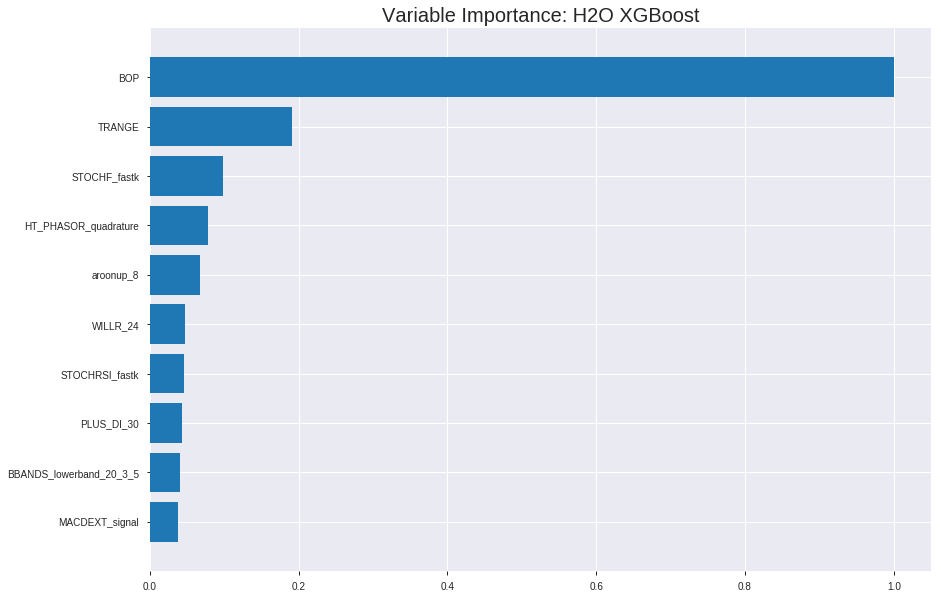

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_143059_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16431636982654832
RMSE: 0.4053595562294644
LogLoss: 0.5027664504181392
Mean Per-Class Error: 0.22847132847132845
AUC: 0.8428721238245048
pr_auc: 0.8569068448659712
Gini: 0.6857442476490097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.457784503698349: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      482  295   0.3797   (295.0/777.0)
1      121  824   0.128    (121.0/945.0)
Total  603  1119  0.2416   (416.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457785     0.79845   237
max f2                       0.262578     0.883477  326
max f0point5                 0.622697     0.80049   154
max accuracy                 0.544881     0.7741    193
max precision                0.90058      1         0
max recall                   0.148572     1         375
max specificity              0.90058      1         0
max absolute_mcc             0.544881     0.543511  193
max min_per_class_accuracy   0.57025      0.767053  181
max mean_per_class_accuracy  0.544881     0.771529  193

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.87421            1.82222    1.82222            1                0.884467  1                           0.884467            0.0190476       0.0190476                  82.2222   82.2222
    2        0.0203252                   0.867392           1.71503    1.77016            0.941176         0.87015   0.971429                    0.877513            0.0169312       0.0359788                  71.5033   77.0159
    3        0.0301974                   0.858794           1.82222    1.78718            1                0.863223  0.980769                    0.872841            0.0179894       0.0539683                  82.2222   78.7179
    4        0.0400697                   0.852909           1.82222    1.79581            1                0.855893  0.985507                    0.868666            0.0179894       0.0719577                  82.2222   79.5813
    5        0.0505226                   0.847197           1.72099    1.78033            0.944444         0.849985  0.977011                    0.864801            0.0179894       0.0899471                  72.0988   78.0332
    6        0.100465                    0.82413            1.65271    1.71689            0.906977         0.83516   0.942197                    0.850066            0.0825397       0.172487                   65.2713   71.6891
    7        0.150407                    0.803436           1.6739     1.70262            0.918605         0.813578  0.934363                    0.83795             0.0835979       0.256085                   67.3902   70.2617
    8        0.200348                    0.783328           1.65271    1.69018            0.906977         0.793439  0.927536                    0.826855            0.0825397       0.338624                   65.2713   69.0177
    9        0.300232                    0.735203           1.40904    1.59665            0.773256         0.757796  0.876209                    0.80388             0.140741        0.479365                   40.9044   59.6647
    10       0.400116                    0.665212           1.36667    1.53924            0.75             0.701513  0.844702                    0.778325            0.136508        0.615873                   36.6667   53.9236
    11       0.5                         0.590081           1.26072    1.4836             0.69186          0.628403  0.81417                     0.748375            0.125926        0.741799                   26.0724   48.3598
    12       0.599884                    0.504698           0.921705   1.39004            0.505814         0.547928  0.762827                    0.715               0.0920635       0.833862                   -7.82946  39.004
    13       0.699768                    0.39161            0.678036   1.28841            0.372093         0.450411  0.707054                    0.677233            0.0677249       0.901587                   -32.1964  28.8409
    14       0.799652                    0.298343           0.529716   1.19364            0.290698         0.346129  0.655047                    0.635875            0.0529101       0.954497                   -47.0284  19.3642
    15       0.899535                    0.196242           0.413178   1.10698            0.226744         0.250398  0.607489                    0.593072            0.0412698       0.995767                   -58.6822  10.6979
    16       1                           0.0800141          0.0421323  1                  0.0231214        0.15135   0.54878                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1981800504582009
RMSE: 0.44517417990961794
LogLoss: 0.5811467400857937
Mean Per-Class Error: 0.2969251336898395
AUC: 0.763937165775401
pr_auc: 0.7923022521565212
Gini: 0.5278743315508021
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4320419132709503: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  112  0.5091   (112.0/220.0)
1      34   238  0.125    (34.0/272.0)
Total  142  350  0.2967   (146.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432042     0.765273  275
max f2                       0.189308     0.86859   379
max f0point5                 0.624539     0.740741  168
max accuracy                 0.44246      0.703252  266
max precision                0.877062     1         0
max recall                   0.176687     1         386
max specificity              0.877062     1         0
max absolute_mcc             0.624539     0.404843  168
max min_per_class_accuracy   0.578777     0.691176  192
max mean_per_class_accuracy  0.624539     0.703075  168

Gains/Lift Table: Avg response rate: 55.28 %, avg score: 55.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.842342           1.44706   1.44706            0.8              0.859116  0.8                         0.859116            0.0147059       0.0147059                  44.7059   44.7059
    2        0.0203252                   0.834229           1.80882   1.62794            1                0.838285  0.9                         0.8487              0.0183824       0.0330882                  80.8824   62.7941
    3        0.0304878                   0.825964           1.80882   1.68824            1                0.832263  0.933333                    0.843221            0.0183824       0.0514706                  80.8824   68.8235
    4        0.0406504                   0.820726           1.80882   1.71838            1                0.822219  0.95                        0.837971            0.0183824       0.0698529                  80.8824   71.8382
    5        0.050813                    0.813738           1.44706   1.66412            0.8              0.817693  0.92                        0.833915            0.0147059       0.0845588                  44.7059   66.4118
    6        0.101626                    0.787516           1.73647   1.70029            0.96             0.799754  0.94                        0.816834            0.0882353       0.172794                   73.6471   70.0294
    7        0.150407                    0.767483           1.58272   1.66216            0.875            0.77744   0.918919                    0.804058            0.0772059       0.25                       58.2721   66.2162
    8        0.20122                     0.751227           1.44706   1.60784            0.8              0.75954   0.888889                    0.792816            0.0735294       0.323529                   44.7059   60.7843
    9        0.300813                    0.707393           1.10744   1.44217            0.612245         0.72707   0.797297                    0.771049            0.110294        0.433824                   10.7443   44.217
    10       0.400407                    0.653753           1.32893   1.414              0.734694         0.677213  0.781726                    0.747709            0.132353        0.566176                   32.8932   41.4004
    11       0.5                         0.59483            1.10744   1.35294            0.612245         0.628907  0.747967                    0.724045            0.110294        0.676471                   10.7443   35.2941
    12       0.599593                    0.508091           0.885954  1.27537            0.489796         0.550721  0.705085                    0.695256            0.0882353       0.764706                   -11.4046  27.5374
    13       0.699187                    0.438527           0.959784  1.23042            0.530612         0.47102   0.680233                    0.663315            0.0955882       0.860294                   -4.02161  23.0421
    14       0.79878                     0.360474           0.479892  1.13684            0.265306         0.403022  0.628499                    0.630861            0.0477941       0.908088                   -52.0108  13.6843
    15       0.898374                    0.256531           0.590636  1.07629            0.326531         0.314523  0.595023                    0.595792            0.0588235       0.966912                   -40.9364  7.62909
    16       1                           0.122914           0.325588  1                  0.18             0.196631  0.552846                    0.555227          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:31:05  2.805 sec   0                  0.5              0.693147            0.5             0                  1                0.45122                          0.5                0.693147              0.5               0                    1                  0.447154
    2019-08-26 14:31:05  2.864 sec   5                  0.474777         0.64366             0.801481        0.812682           1.65657          0.293264                         0.483002           0.659552              0.749148          0.775079             1.50735            0.373984
    2019-08-26 14:31:05  2.906 sec   10                 0.456797         0.608924            0.806928        0.820767           1.72099          0.260163                         0.470002           0.63398               0.750735          0.785059             1.80882            0.349593
    2019-08-26 14:31:05  2.949 sec   15                 0.444594         0.585024            0.812052        0.830826           1.72099          0.264808                         0.461863           0.617676              0.753067          0.785356             1.80882            0.327236
    2019-08-26 14:31:05  2.996 sec   20                 0.435827         0.567485            0.815336        0.831951           1.72099          0.271777                         0.455902           0.605453              0.759083          0.789919             1.44706            0.333333
    2019-08-26 14:31:05  3.046 sec   25                 0.429461         0.554293            0.818572        0.833881           1.82222          0.263647                         0.452514           0.59833               0.761422          0.794932             1.80882            0.308943
    2019-08-26 14:31:05  3.115 sec   30                 0.424811         0.544358            0.82089         0.838251           1.82222          0.263647                         0.449898           0.592559              0.761673          0.792789             1.44706            0.323171
    2019-08-26 14:31:05  3.173 sec   35                 0.420466         0.535234            0.825566        0.843062           1.82222          0.259582                         0.448427           0.589213              0.761314          0.791691             1.44706            0.321138
    2019-08-26 14:31:05  3.230 sec   40                 0.417184         0.528228            0.828849        0.845121           1.82222          0.252613                         0.447913           0.587901              0.761263          0.791032             1.44706            0.319106
    2019-08-26 14:31:05  3.282 sec   45                 0.414468         0.522475            0.832184        0.848758           1.82222          0.25029                          0.446224           0.584394              0.765592          0.792094             1.44706            0.29878
    2019-08-26 14:31:05  3.358 sec   50                 0.411837         0.516734            0.835386        0.850624           1.82222          0.249129                         0.446188           0.583867              0.764973          0.79352              1.44706            0.29878
    2019-08-26 14:31:06  3.442 sec   55                 0.40943          0.511687            0.838576        0.854585           1.82222          0.228804                         0.445961           0.583295              0.764773          0.7

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BOP                   2522.736328125         1.0                    0.4408995792402206
TRANGE                481.53326416015625     0.19087736549861764    0.08415775013482232
STOCHF_fastk          249.5698699951172      0.09892824200958315    0.043617420276999934
HT_PHASOR_quadrature  196.8174285888672      0.07801743939492475    0.034397856202621736
aroonup_8             170.15020751953125     0.06744668700513533    0.02973721592171102
---                   ---                    ---                    ---
AROONOSC_12           11.604766845703125     0.004600071246577029   0.0020281694770908493
CDLLONGLINE           11.133720397949219     0.004413350802390138   0.0019458445118133018
aroonup_20            8.99099349975586       0.0035639846303074925  0.0015713593239211866
WILLR_30              6.942331314086914      0.0027519052374556864  0.0012133138613031715
CCI_20                5.552472114562988      0.0022009720368556356  0.0009704076449691411


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7206477732793523)

('F1', 0.7426470588235294)

('auc', 0.7683135704874836)

('logloss', 0.5777056258288091)

('mean_per_class_error', 0.27299077733860333)

('rmse', 0.4419052828057269)

('mse', 0.19528027897160946)

xgboost prediction progress: |████████████████████████████████████████████| 100%


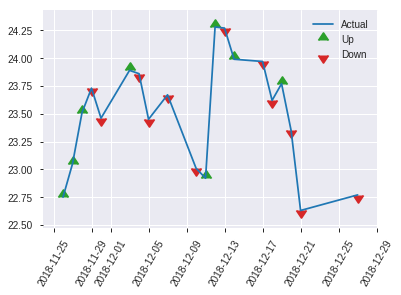


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19528027897160946
RMSE: 0.4419052828057269
LogLoss: 0.5777056258288091
Mean Per-Class Error: 0.27299077733860333
AUC: 0.7683135704874836
pr_auc: 0.7108954600732533
Gini: 0.5366271409749672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4145335257053375: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   56   0.4242   (56.0/132.0)
1      14   101  0.1217   (14.0/115.0)
Total  90   157  0.2834   (70.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414534     0.742647  156
max f2                       0.152971     0.820257  240
max f0point5                 0.576845     0.712831  93
max accuracy                 0.576845     0.720648  93
max precision                0.825592     1         0
max recall                   0.152971     1         240
max specificity              0.825592     1         0
max absolute_mcc             0.414534     0.470585  156
max min_per_class_accuracy   0.473916     0.704545  120
max mean_per_class_accuracy  0.414534     0.727009  156

Gains/Lift Table: Avg response rate: 46.56 %, avg score: 48.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.805088           2.14783   2.14783            1                0.813591  1                           0.813591            0.026087        0.026087                   114.783   114.783
    2        0.0202429                   0.798976           2.14783   2.14783            1                0.801555  1                           0.808777            0.0173913       0.0434783                  114.783   114.783
    3        0.0323887                   0.791767           1.43188   1.87935            0.666667         0.796917  0.875                       0.804329            0.0173913       0.0608696                  43.1884   87.9348
    4        0.0404858                   0.783532           1.07391   1.71826            0.5              0.786749  0.8                         0.800813            0.00869565      0.0695652                  7.3913    71.8261
    5        0.0526316                   0.780109           1.43188   1.65217            0.666667         0.781826  0.769231                    0.796432            0.0173913       0.0869565                  43.1884   65.2174
    6        0.101215                    0.755798           1.61087   1.63235            0.75             0.770908  0.76                        0.78418             0.0782609       0.165217                   61.087    63.2348
    7        0.149798                    0.734893           1.61087   1.62538            0.75             0.747216  0.756757                    0.772192            0.0782609       0.243478                   61.087    62.5382
    8        0.202429                    0.701739           1.48696   1.58939            0.692308         0.716908  0.74                        0.757818            0.0782609       0.321739                   48.6957   58.9391
    9        0.299595                    0.636558           1.61087   1.59636            0.75             0.674294  0.743243                    0.730729            0.156522        0.478261                   61.087    59.6357
    10       0.40081                     0.554578           1.46052   1.56206            0.68             0.60295   0.727273                    0.698462            0.147826        0.626087                   46.0522   56.2055
    11       0.502024                    0.465119           0.945043  1.43766            0.44             0.500327  0.669355                    0.658515            0.0956522       0.721739                   -5.49565  43.7658
    12       0.59919                     0.425968           1.07391   1.37867            0.5              0.446436  0.641892                    0.624124            0.104348        0.826087                   7.3913    37.8672
    13       0.700405                    0.339738           0.687304  1.27876            0.32             0.394129  0.595376                    0.590888            0.0695652       0.895652                   -31.2696  27.8764
    14       0.797571                    0.284595           0.357971  1.16659            0.166667         0.304008  0.543147                    0.555938            0.0347826       0.930435                   -64.2029  16.6586
    15       0.898785                    0.19971            0.257739  1.06424            0.12             0.241173  0.495495                    0.520491            0.026087        0.956522                   -74.2261  6.42382
    16       1                           0.133297           0.429565  1                  0.2              0.166588  0.465587                    0.484671         

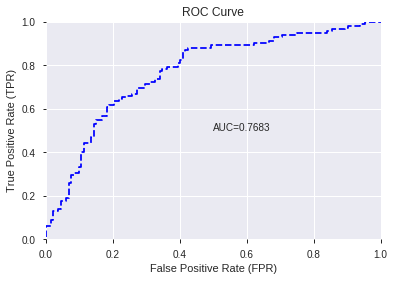

This function is available for GLM models only


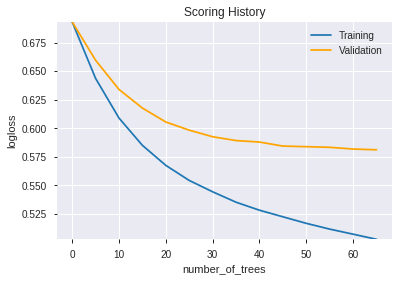

--2019-08-26 14:31:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

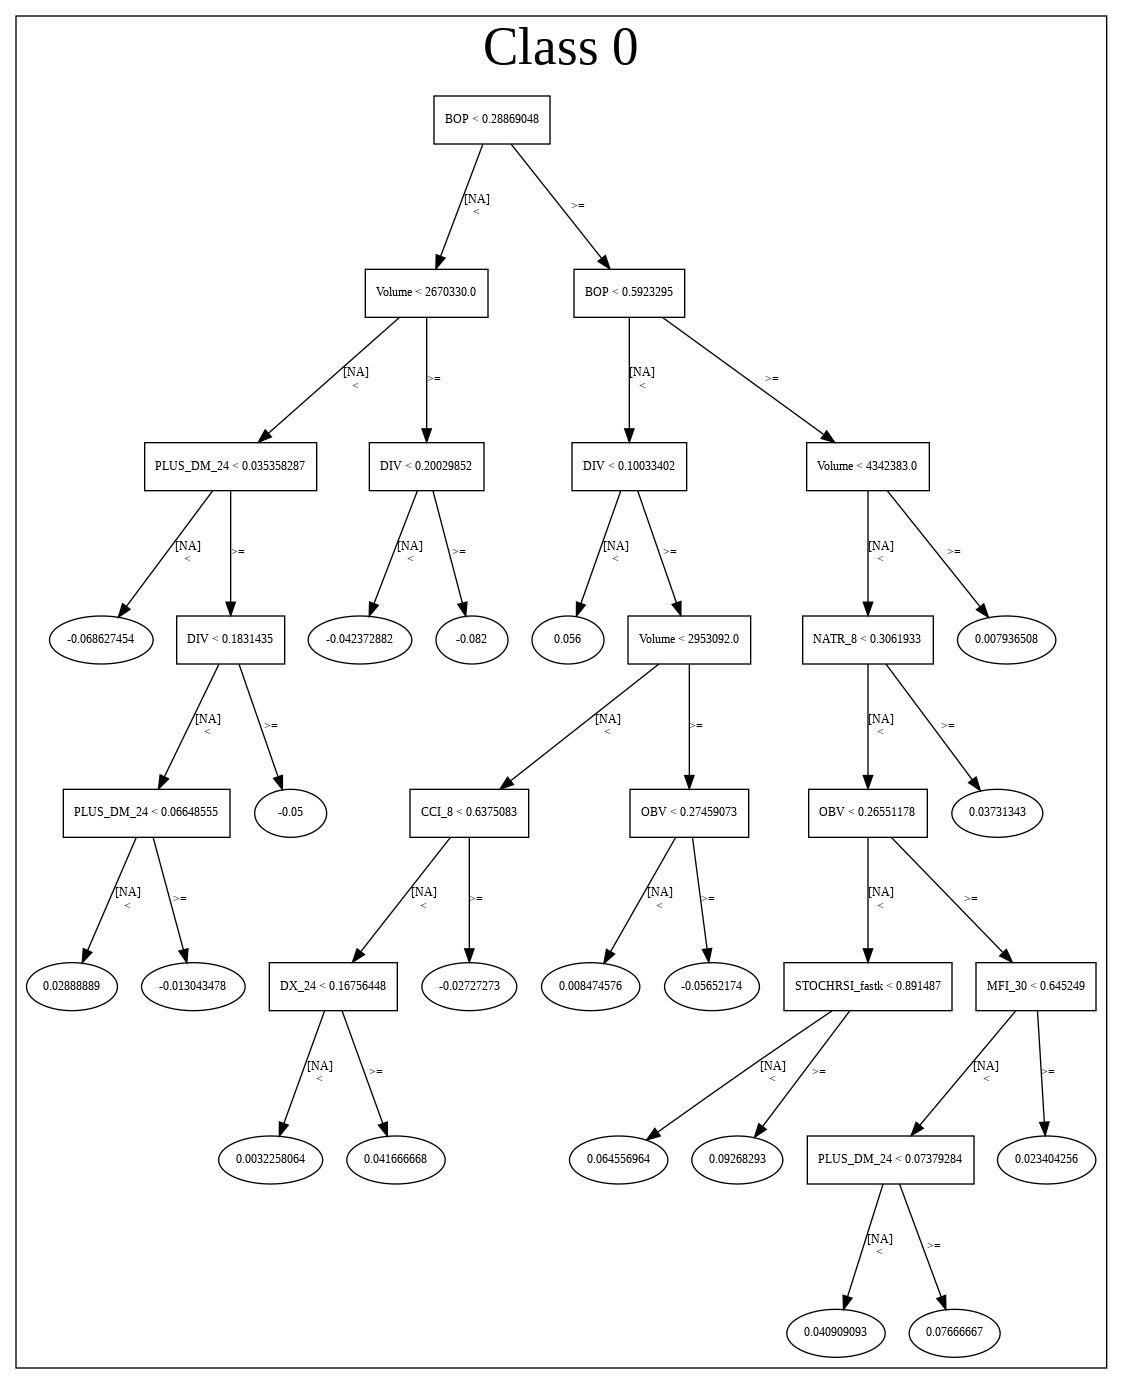

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_143059_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_143059_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_ba53',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'aroonup_8',
 'WILLR_24',
 'STOCHRSI_fastk',
 'PLUS_DI_30',
 'BBANDS_lowerband_20_3_5',
 'MACDEXT_signal',
 'VAR_8',
 'PLUS_DM_14',
 'CCI_8',
 'CORREL_14',
 'CMO_30',
 'STOCH_slowd',
 'MINUS_DI_30',
 'BETA_8',
 'ROCP_14',
 'STOCHF_fastd',
 'ROCR_8',
 'MACDEXT_hist',
 'MINUS_DM_8',
 'PLUS_DI_12',
 'CORREL_12',
 'CMO_20',
 'ROCR_20',
 'ULTOSC',
 'MINUS_DI_8',
 'WILLR_14',
 'ROC_12',
 'LINEARREG_SLOPE_8',
 'WILLR_8',
 'MFI_20',
 'PPO',
 'AROONOSC_8',
 'MINUS_DI_14',
 'AROONOSC_20',
 'WILLR_12',
 'AROONOSC_24',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_14',
 'ROC_30',
 'CCI_30',
 'AROONOSC_12',
 'CDLLONGLINE',
 'aroonup_20',
 'WILLR_30',
 'CCI_20']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.729
GLM             0.745
XGBoost         0.745
dtype: float64

DeepLearning    GLM  XGBoost
All          0.466  0.466    0.741
DLF          0.725  0.725    0.745
Fwe          0.717  0.745    0.733
RFE          0.729  0.717    0.721
XGBF         0.721  0.725    0.745





F1


DeepLearning    0.715
GLM             0.727
XGBoost         0.765
dtype: float64

DeepLearning    GLM  XGBoost
All          0.635  0.635    0.752
DLF          0.702  0.710    0.765
Fwe          0.715  0.727    0.742
RFE          0.702  0.703    0.743
XGBF         0.705  0.710    0.765





auc


DeepLearning    0.765
GLM             0.795
XGBoost         0.794
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.486    0.790
DLF          0.765  0.775    0.794
Fwe          0.764  0.795    0.778
RFE          0.751  0.759    0.768
XGBF         0.761  0.775    0.794





logloss


DeepLearning    18.449
GLM             17.305
XGBoost          0.584
dtype: float64

DeepLearning     GLM  XGBoost
All         18.449  17.305    0.584
DLF          0.612   0.653    0.557
Fwe          0.611   0.563    0.573
RFE          0.621   0.610    0.578
XGBF         0.602   0.653    0.557





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.273
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.258
DLF          0.288  0.285    0.249
Fwe          0.283  0.257    0.262
RFE          0.274  0.301    0.273
XGBF         0.282  0.285    0.249





rmse


DeepLearning    0.731
GLM             0.731
XGBoost         0.446
dtype: float64

DeepLearning    GLM  XGBoost
All          0.731  0.731    0.446
DLF          0.459  0.467    0.432
Fwe          0.454  0.432    0.441
RFE          0.462  0.447    0.442
XGBF         0.451  0.467    0.432





mse


DeepLearning    0.534
GLM             0.534
XGBoost         0.198
dtype: float64

DeepLearning    GLM  XGBoost
All          0.534  0.534    0.198
DLF          0.211  0.219    0.187
Fwe          0.207  0.186    0.194
RFE          0.214  0.200    0.195
XGBF         0.204  0.219    0.187

{'F1':       DeepLearning    GLM  XGBoost
 All          0.635    NaN      NaN
 DLF          0.702    NaN      NaN
 DLF            NaN  0.710      NaN
 DLF            NaN    NaN    0.765
 All            NaN  0.635      NaN
 All            NaN    NaN    0.752
 XGBF         0.705    NaN      NaN
 XGBF           NaN  0.710      NaN
 XGBF           NaN    NaN    0.765
 Fwe          0.715    NaN      NaN
 Fwe            NaN  0.727      NaN
 Fwe            NaN    NaN    0.742
 RFE          0.702    NaN      NaN
 RFE            NaN  0.703      NaN
 RFE            NaN    NaN    0.743,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.466    NaN      NaN
 DLF          0.725    NaN      NaN
 DLF            NaN  0.725      NaN
 DLF            NaN    NaN    0.745
 All            NaN  0.466      NaN
 All            NaN    NaN    0.741
 XGBF         0.721    NaN      NaN
 XGBF           NaN  0.725      NaN
 XGBF           NaN    NaN    0.745
 Fwe          0.717    NaN      NaN
 Fwe     